In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
home = os.path.expanduser("~")
project_path =  home+'/Dropbox/Work_main/to_be_transition_project/'
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [4]:
data_folder = os.path.relpath('.')
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [5]:
data_files

['./32-16-15--26-05-2023abm_result_feather']

In [6]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [7]:
datadf['first_tb'].unique()

array([ 9.96      ,  5.13333333, 12.01      , ..., 12.51428571,
       10.66111111,  1.35      ])

In [8]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
N = datadf['N'].unique()[0]

In [10]:
np.log10(N), R0s

(8.0, array([1.5, 2.5, 3.5, 4.5]))

In [14]:
%load_ext autoreload

In [12]:
#get folder name of cwd



In [11]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results/parameter_runs/'+ folder_name
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [12]:
results_folder

'../../../../../Work_main/to_be_transition_project/results/parameter_runs/initial_freqs'

In [15]:
parallel_subfolder

'results/parameter_runs/initial_freqs'

In [16]:
if len(data_files)==1:
    dataname = data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]
    results_name = results_folder+'/'+dataname
else:
    raise ValueError

In [17]:
filtered_df = datadf[~datadf.isin([np.inf, -np.inf]).any(axis=1)]

In [18]:
def get_p_evo_from_df(R0,mu,xi, datadf):
    dpdf = datadf.query(f'infection_rate =={R0} & mutation_rate=={mu} & xi=={xi}')
    return 1-len(dpdf[datadf.isin([np.inf, -np.inf]).any(axis=1)])/len(dpdf)

if not os.path.exists(results_name+'p_evo_df.feather'):
    p_evo_df = pd.DataFrame.from_dict({i:(mu,xi,r ,get_p_evo_from_df(r,mu,xi,datadf)) for i,(mu,xi,r) in enumerate(funcs.product(mu_s,xi_s,R0s))},orient='index', columns=['mu','xi','R0','p_evo'])
    p_evo_df.to_feather(results_name+'p_evo_df.feather')
else:
    p_evo_df = pd.read_feather(results_name+'p_evo_df.feather')
    

In [19]:
filtered_df['muN'] =np.round(filtered_df['mutation_rate']*filtered_df['N'])
p_evo_df['N']=N
p_evo_df['muN'] =np.round(p_evo_df['mu']*p_evo_df['N'],0)
filtered_df['first_d_over_xi']=filtered_df['first_d']/filtered_df['xi']




/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
p_alpha = datadf['p_alpha'].unique()[0]
xi_d = -1/np.log(1-p_alpha)

In [21]:
mu_s*N

array([  10.        ,   25.11886432,   63.09573445,  158.48931925,
        398.10717055, 1000.        ])

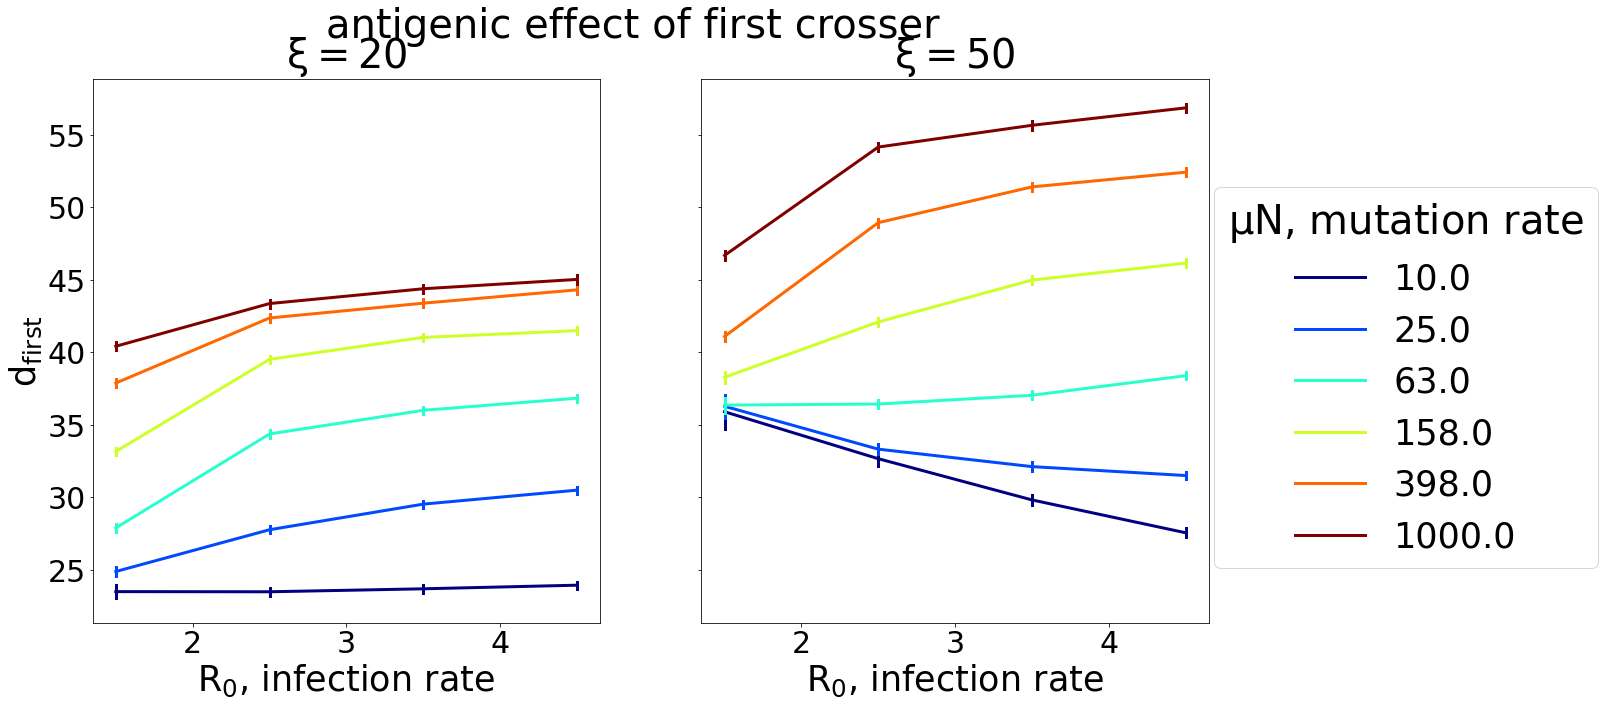

In [22]:
fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    
    zeta = xi_d/xi
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x='infection_rate',y='first_d', hue='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    # sns.lineplot(data =solutions_df[solutions_df['xi']==xi],x='R0',y='d_opt', hue='muN', ax= ax[0],palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    # for mu in mu_s:
    #     ax[ix].plot(R0s, xi_d* np.log(mu*N*np.log(R0s)/R0s /(1-p_alpha)), color=color_mus[mu], linestyle='--')
    # ax[1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
for a in ax:
    
    a.set_xlabel(r'$R_0$, infection rate')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
    # a.set_ylim(10,40)
ax[-1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
fig.suptitle(r'antigenic effect of first crosser', fontsize=40)
fig.savefig(results_name+'first_d_vs_R0_comparison_all_mutants.pdf')

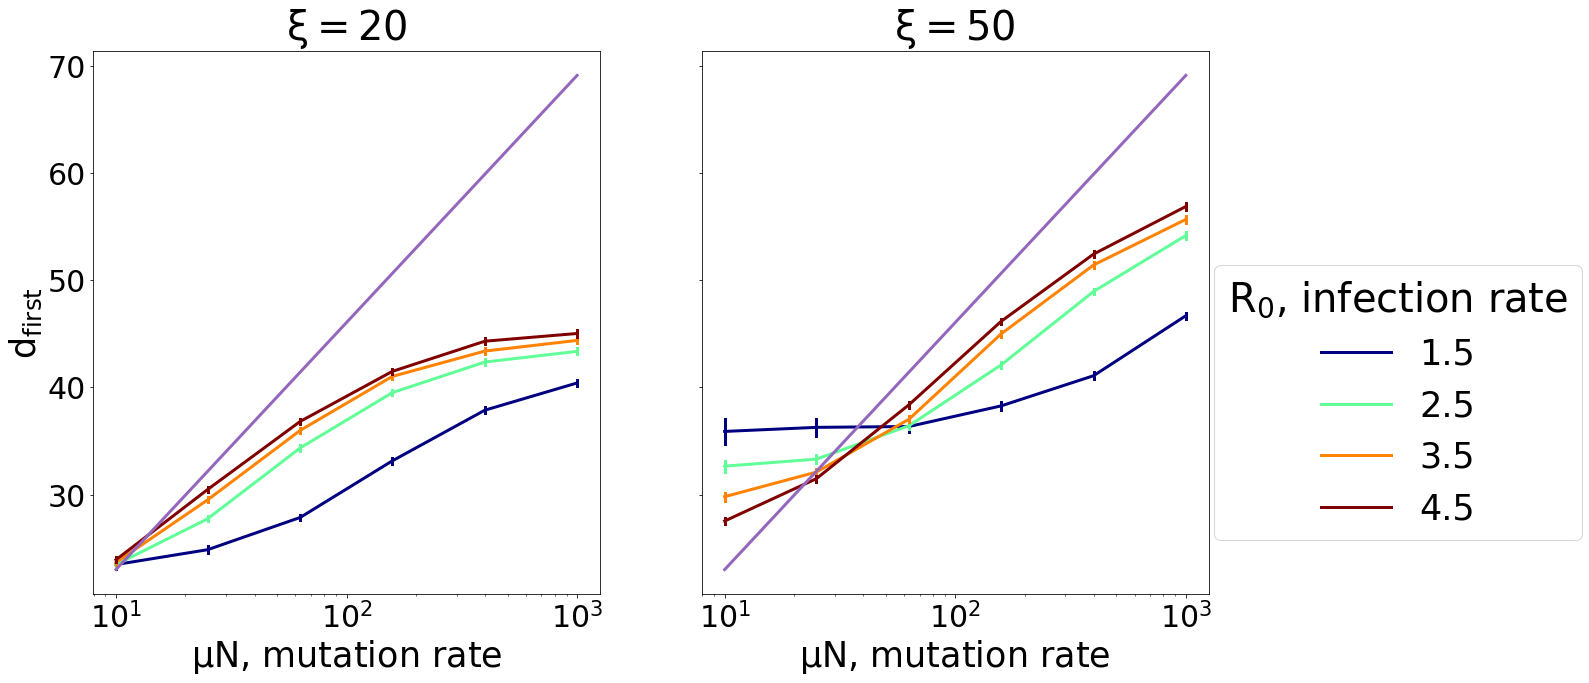

In [23]:
colors_R0 = funcs.color_dict(R0s, plt.cm.jet)

#create a dataframe for fits 
fit_df = pd.DataFrame(columns=['xi','R0','a','b'])

fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    qfiltered = filtered_df.query(f'xi=={xi}')
    sns.lineplot(data =qfiltered,hue='infection_rate',y='first_d', x='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    
    #for every R0, fit first_d  to a + b*np.log(mu_s*N)
    for R0 in R0s:
        qR0 = qfiltered.query(f'infection_rate=={R0}')
        b,a = np.polyfit(np.log(qR0['muN'])[:-3],qR0['first_d'][:-3],1)
        # ax[ix].plot(mu_s*N, a + b*np.log(mu_s*N), color=colors_R0[R0], linestyle='--')
        #add a,b to fit_df
        fit_df = fit_df.append({'xi':xi,'R0':R0,'a':a,'b':b},ignore_index=True)

    ax[ix].plot(mu_s*N,1/p_alpha* np.log(mu_s*N))

    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    ax[ix].set_xscale('log')
for a in ax:
    
    a.set_xlabel(r'$\mu N$, mutation rate')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
ax[-1].legend(title=r'$R_0$, infection rate',loc=(1.01,.1),title_fontsize=40)


<AxesSubplot:xlabel='R0', ylabel='a'>

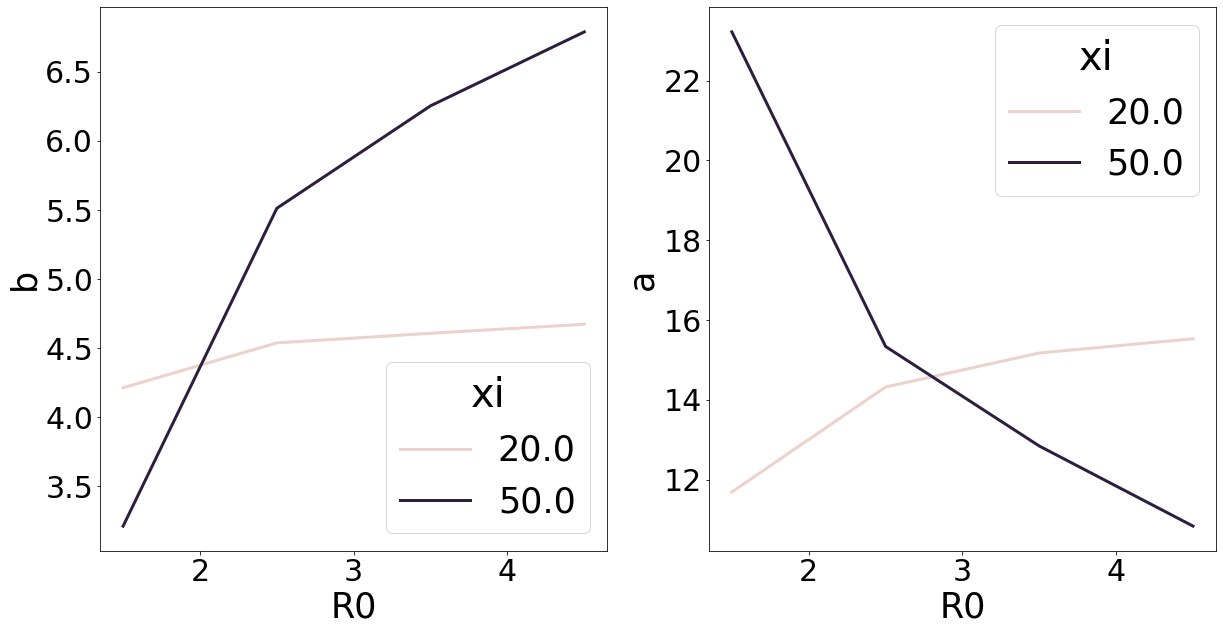

In [24]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.lineplot(fit_df, x='R0', y='b', hue='xi',ax=ax[0],)
sns.lineplot(fit_df, x='R0', y='a', hue='xi',ax=ax[1])

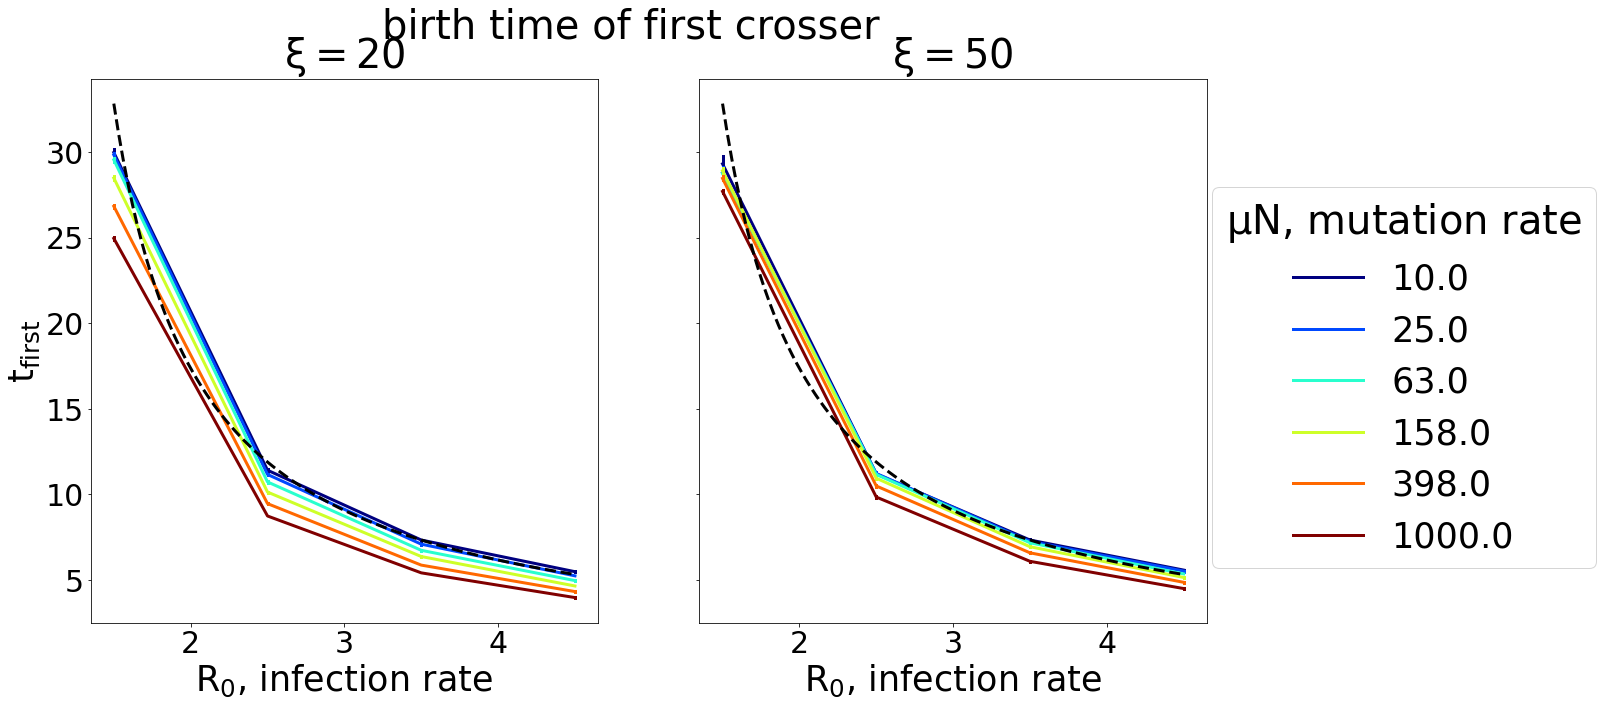

In [25]:
%autoreload
fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    
    zeta = xi_d/xi
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x='infection_rate',y='first_tb', hue='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    # sns.lineplot(data =solutions_df[solutions_df['xi']==xi],x='R0',y='d_opt', hue='muN', ax= ax[0],palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)


    # ax[1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
manyR0s = np.linspace(1.5,4.5,100)
for a in ax:
    a.plot(manyR0s,funcs.t_peaks(manyR0s,N),color='black',linestyle='--')
    # sns.lineplot(solutions_df, x='R0',y='avg_d_geom', hue='muN', ax= a,palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    a.set_xlabel(r'$R_0$, infection rate')

    a.set_ylabel(r'$t_{\mathrm{first}}$')

ax[-1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
fig.suptitle(r'birth time of first crosser', fontsize=40)

fig.savefig(results_name+'first_tb_vs_R0_comparison_all_mutants.pdf')

In [26]:
#create a column tx-tpeak in filtered df using funcs.t_peaks(R0,N)
filtered_df['t_x-t_peak'] = filtered_df.apply(lambda row: row['t_x']-funcs.t_peaks(row['infection_rate'],N),axis=1)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


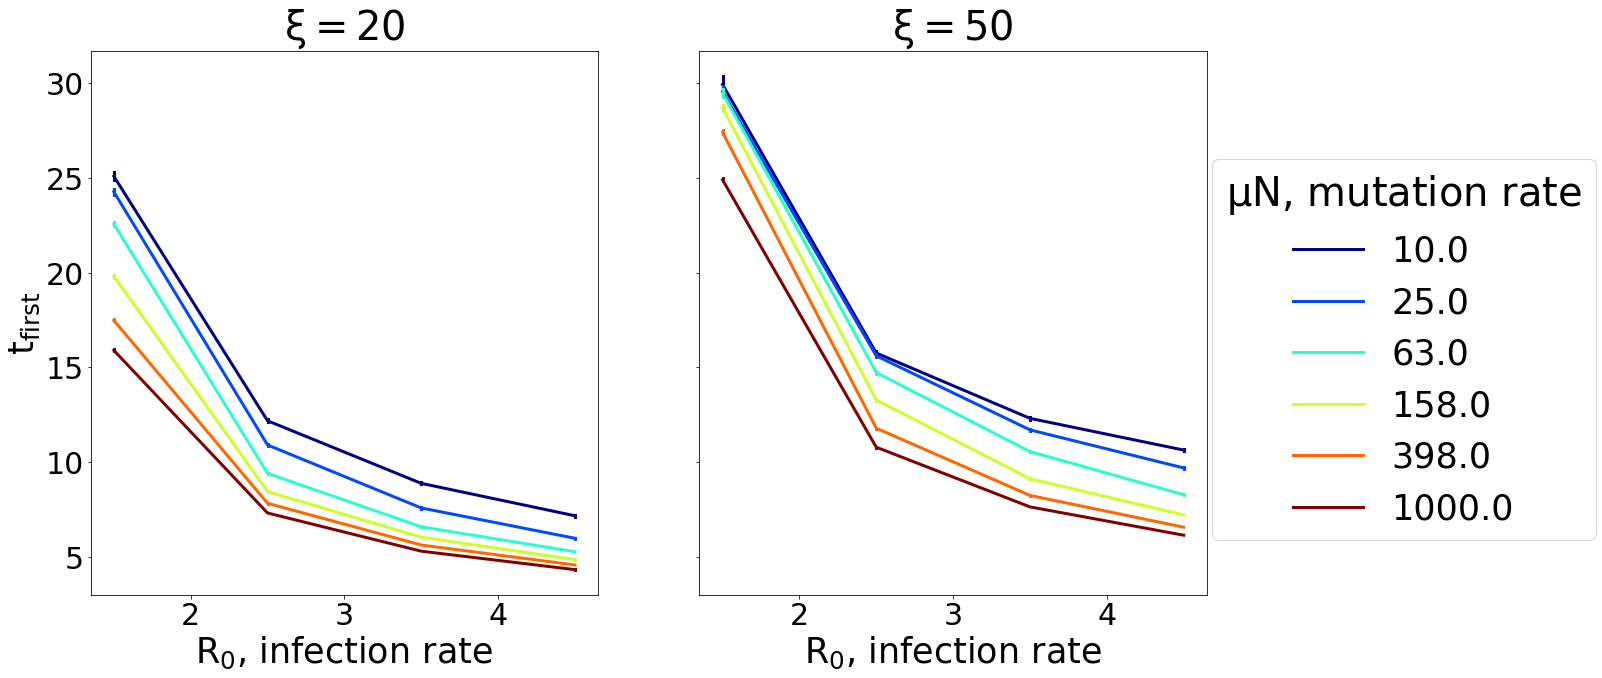

In [27]:
%autoreload
fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    
    zeta = xi_d/xi
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    sns.lineplot(data =filtered_df[filtered_df['xi']==xi],x='infection_rate',y='t_x-t_peak', hue='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    # sns.lineplot(data =solutions_df[solutions_df['xi']==xi],x='R0',y='d_opt', hue='muN', ax= ax[0],palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)


    # ax[1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
manyR0s = np.linspace(1.5,4.5,100)
for a in ax:
    # a.plot(R0s,np.log(N* funcs.y_peak(R0s))/(1-R0s*funcs.x_inf(R0s,0)),color='black',linestyle='--')
    # sns.lineplot(solutions_df, x='R0',y='avg_d_geom', hue='muN', ax= a,palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
    a.set_xlabel(r'$R_0$, infection rate')

    a.set_ylabel(r'$t_{\mathrm{first}}$')

ax[-1].legend(title=r'$\mu N$, mutation rate',loc=(1.01,.1),title_fontsize=40)
# fig.suptitle(r'birth time of first crosser', fontsize=40)

In [28]:
R0 = 2.5
T = funcs.T_ext_deterministic(R0,0,N)
ts_det = np.linspace(0,T,1000)
dt = ts_det[1]-ts_det[0]
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,0)).T

y_func = interp1d(ts_det,y)
x_func = interp1d(ts_det,x)
z_func = interp1d(ts_det,z)



In [29]:
def p_d_func(d,R0,p_alpha,xi,mu,N):
    T = funcs.T_ext_deterministic(R0,0,N)
    ts_det = np.linspace(0,T,500)
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,0)).T
    dt = ts_det[1]-ts_det[0]
    y_func = interp1d(ts_det,y)
    x_func = interp1d(ts_det,x)
    z_func = interp1d(ts_det,z)
    chi_y = lambda t,N: 1/(N*y_func(t))
    txx = lambda t, d, R0, xi, N: np.maximum(t,funcs.t_peak(R0,N))+   np.log((1-chi_y(t,N))/chi_y(t,N))/funcs.s_d_infinity(R0,d,xi)
    def zxx(t,d,R0,xi,N):
        if txx(t,d,R0,xi,N)>funcs.T_ext_deterministic(R0,0,N):
            return 1-funcs.x_inf(R0,0)
        if txx(t,d,R0,xi,N)<0:
            return 0
        return z_func(txx(t,d,R0,xi,N))    
    zx =np.vectorize(zxx)

    # deltaZ = z_func(ts_det)
    deltaZ = zx(ts_det, d,R0,xi,N )#-z_func(ts_det)
    deltaZ= np.maximum(deltaZ,0)
    vv=  funcs.rho_d(d,p_alpha)*mu*N* y* np.exp(-mu*N*deltaZ*(1-p_alpha)**d)
    return np.sum(vv[~np.isnan(vv)])*dt


def p_d_func_alt(d,R0,p_alpha,xi,mu,N):
    T = funcs.T_ext_deterministic(R0,0,N)
    ts_det = np.linspace(0,T,500)
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,0)).T
    dt = ts_det[1]-ts_det[0]
    y_func = interp1d(ts_det,y)
    x_func = interp1d(ts_det,x)
    z_func = interp1d(ts_det,z)
    chi_y = lambda t,N: 1/(N*y_func(t))
    txx = lambda t, d, R0, xi, N: np.maximum(t,funcs.t_peak(R0,N))+   np.log((1-chi_y(t,N))/chi_y(t,N))/funcs.s_d_infinity(R0,d,xi)
    def zxx(t,d,R0,xi,N):
        if txx(t,d,R0,xi,N)>funcs.T_ext_deterministic(R0,0,N):
            return 1-funcs.x_inf(R0,0)
        if txx(t,d,R0,xi,N)<0:
            return 0
        return z_func(txx(t,d,R0,xi,N))    
    zx =np.vectorize(zxx)

    # deltaZ = z_func(ts_det)
    deltaZ = zx(ts_det, d,R0,xi,N )#-z_func(ts_det)
    deltaZ= np.maximum(deltaZ,0)
    vv=  funcs.rho_d(d,p_alpha)*mu*N*(R0-1)/R0* y* np.exp(-mu*N*(R0-1)/R0*deltaZ*(1-p_alpha)**d)
    return np.sum(vv[~np.isnan(vv)])*dt


# def p_d_func2(d,R0,p_alpha,xi,mu,N):
#     deltaZ = zx(ts_det, d,R0,xi,N )-z_func(ts_det)
#     deltaZ= np.maximum(deltaZ,0)
#     vv=  funcs.rho_d(d,p_alpha)*mu*N* y* np.exp(-mu*N*deltaZ*(1-p_alpha)**d)
#     return np.sum(vv[~np.isnan(vv)])*dt

# def p_d_func3(d,R0,p_alpha,xi,mu,N):
#     deltaZ_sq = zx(ts_det, d,R0,xi,N )**2 - z_func(ts_det)**2
#     deltaY = yx(ts_det, d,R0,xi,N )-y_func(ts_det)
#     deltaZ_sq= np.maximum(deltaZ_sq,0)
#     c = np.exp(-d/xi)
#     vv=  funcs.rho_d(d,p_alpha)*mu*N* y*R0* ((1-c)*z)* np.exp(-mu*N*((1-c)*deltaZ_sq)*(1-p_alpha)**d)
#     return np.sum(vv[~np.isnan(vv)])*dt

In [30]:
#convert to a python function 1 + const + (-1 + E**(d/\[Xi]))*\[Xi]*Log(1 - p) - Log(((1 - E**(-d/\[Xi]))*(1 - p)**d*R0**2*\[Mu]*Subscript(z,DirectedInfinity(1)))/(-1 + R0 - Log(R0)))
def to_solve(d,p_alpha,R0,xi,mu,N, const= 1):
    z_inf = 1-funcs.x_inf(R0,0)
    return 1 + const + (-1 + np.exp(d/xi))*xi*np.log(1 - p_alpha) - np.log(((1 - np.exp(-d/xi))*(1 - p_alpha)**d*R0**2*mu*z_inf)/(-1 + R0 - np.log(R0)))

#function that finds the root of t_solve
def t_solve(p_alpha,R0,xi,mu,N):
    return spo.fsolve(to_solve, 0.1, args=(p_alpha,R0,xi,mu,N))[0]

#get dataframe of solutions of t_solve for mu in mu_s, R0 in R0s, and xi in xi_s
t_solve_df = pd.DataFrame(columns=['mu','R0','xi','d_opt'])

for mu in mu_s:
    for R0 in R0s:
        for xi in xi_s:
            t_solve_df = t_solve_df.append({'mu':mu,'R0':R0,'xi':xi,'d_opt':t_solve(p_alpha,R0,xi,mu,N)}, ignore_index=True)

t_solve_df['muN'] = t_solve_df['mu']*N


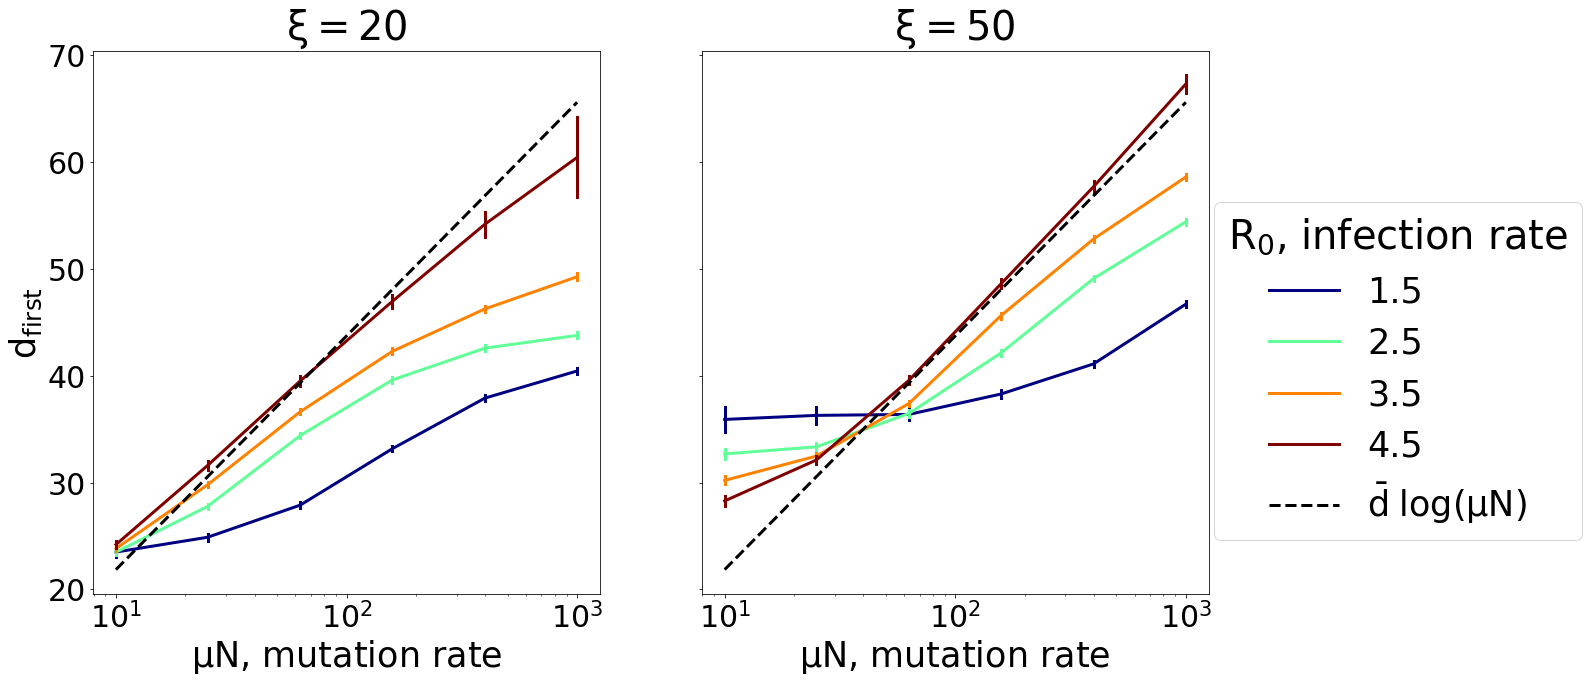

In [31]:
colors_R0 = funcs.color_dict(R0s, plt.cm.jet)

#create a dataframe for fits 
fit_df = pd.DataFrame(columns=['xi','R0','a','b'])

fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    qfiltered = filtered_df.query(f'xi=={xi} and first_tb>{funcs.t_peak(R0,N)}')
    sns.lineplot(data =qfiltered,hue='infection_rate',y='first_d', x='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())

    #sns.lineplot(t_solve_df.query(f'xi=={xi}'), y='d_opt', x='muN', ax= ax[ix],palette=plt.cm.jet,legend=legend, hue_norm=mpl.colors.LogNorm())
    # for R0 in R0s:
    ax[ix].plot(mu_s*N, -1/np.log(1-p_alpha)*np.log(N*mu_s), color='k', linestyle='--', label=r'$ \bar{d} \;\log(\mu N)$')
    

    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    ax[ix].set_xscale('log')
for a in ax:
    
    a.set_xlabel(r'$\mu N$, mutation rate')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
ax[-1].legend(title=r'$R_0$, infection rate',loc=(1.01,.1),title_fontsize=40)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel

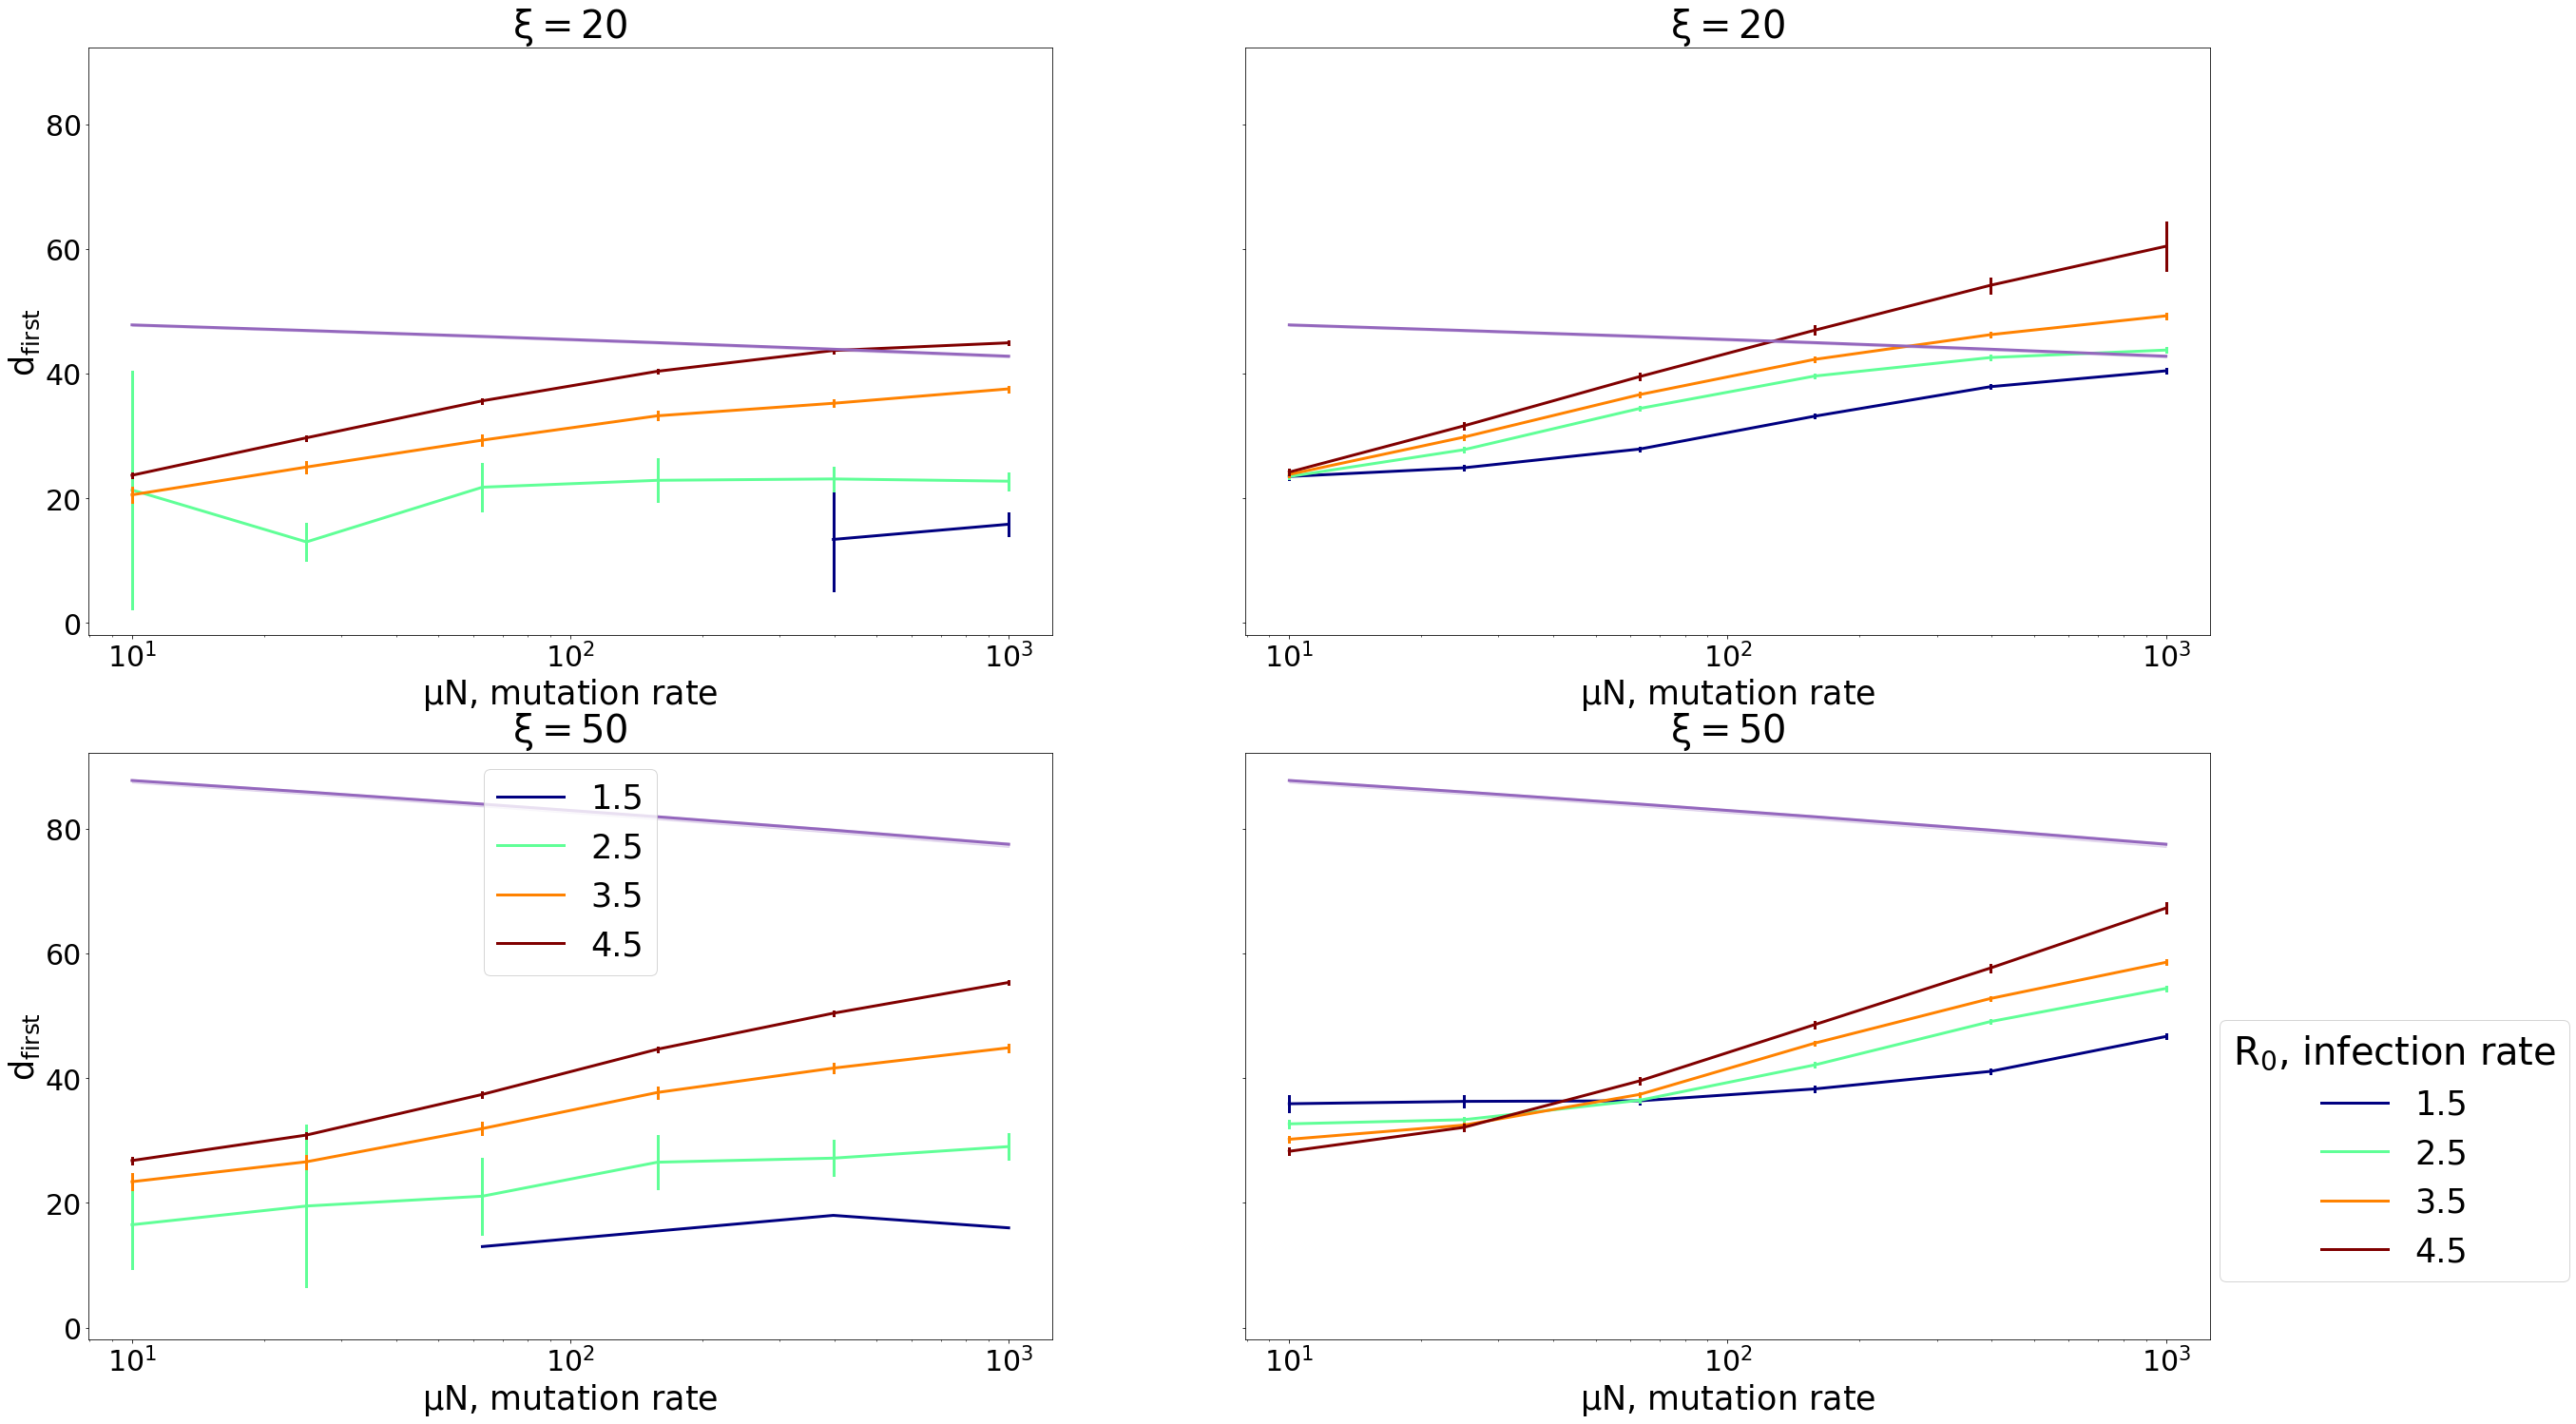

In [32]:
colors_R0 = funcs.color_dict(R0s, plt.cm.jet)

#create a dataframe for fits 
fit_df = pd.DataFrame(columns=['xi','R0','a','b'])

fig,ax =plt.subplots(2,len(xi_s), figsize=(len(xi_s)*20,25),sharey=True)
for ix,xi in enumerate(xi_s):
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None

    qfiltered_before = filtered_df.query(f'xi=={xi} and first_tb<{funcs.t_peak(R0,N)}')
    sns.lineplot(data =qfiltered_before,hue='infection_rate',y='first_d', x='muN', ax= ax[ix,0],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())
    
    qfiltered_after = filtered_df.query(f'xi=={xi} and first_tb>{funcs.t_peak(R0,N)}')
    sns.lineplot(data =qfiltered_after,hue='infection_rate',y='first_d', x='muN', ax= ax[ix,1],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())

    sns.lineplot(t_solve_df.query(f'xi=={xi}'), y='d_opt', x='muN', ax= ax[ix,1],palette=plt.cm.jet,legend=legend, hue_norm=mpl.colors.LogNorm())
    sns.lineplot(t_solve_df.query(f'xi=={xi}'), y='d_opt', x='muN', ax= ax[ix,0],palette=plt.cm.jet,legend=legend, hue_norm=mpl.colors.LogNorm())
    ax[ix,1].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    ax[ix,0].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    ax[ix,1].set_xscale('log')

for a in ax.flatten():
    # a.set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    a.set_xscale('log')
    a.set_xlabel(r'$\mu N$, mutation rate')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
ax[-1,1].legend(title=r'$R_0$, infection rate',loc=(1.01,.1),title_fontsize=40)

In [33]:
def get_constant_frequency_intersection(yfunc, zfunc, d,tb, R0, N, xi, kappa=0):
    y = yfunc(tb)
    z = zfunc(tb)
    c = np.exp(-d/xi)
    chi_0 = 1/(N*yfunc(tb))
    s_inf = funcs.s_d_infinity(R0,d,xi,kappa)
    if tb<funcs.t_peak(R0,N):
        t0 = funcs.t_peak(R0,N)-tb
    else:
        t0 = 0

    chi_mod = chi_0/s_inf
    predicted_delta_tx = t0 + (np.log((1-chi_0)/chi_0)-1)/s_inf#+(np.log((1-chi_mod)/chi_mod)-1)/s_inf
    return predicted_delta_tx



def add_column_constant_frequency_intersection(df, R0, kappa, N):
    ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
    dt = ts_det[1]-ts_det[0]
    x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
    #interpolate y
    y_func = interp1d(ts_det,y)
    z_func = interp1d(ts_det,z)

    df['predicted_delta_tx'] = df.apply(lambda row: get_constant_frequency_intersection(y_func, z_func, row['first_d'], row['first_tb'], R0, N, row['xi'], kappa), axis=1)
    df['chi0'] = df.apply(lambda row: 1/(N*y_func(row['first_tb'])), axis=1)


In [34]:
np.euler_gamma

0.5772156649015329

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a co

(3.845903444913164, 34.84620252748929)

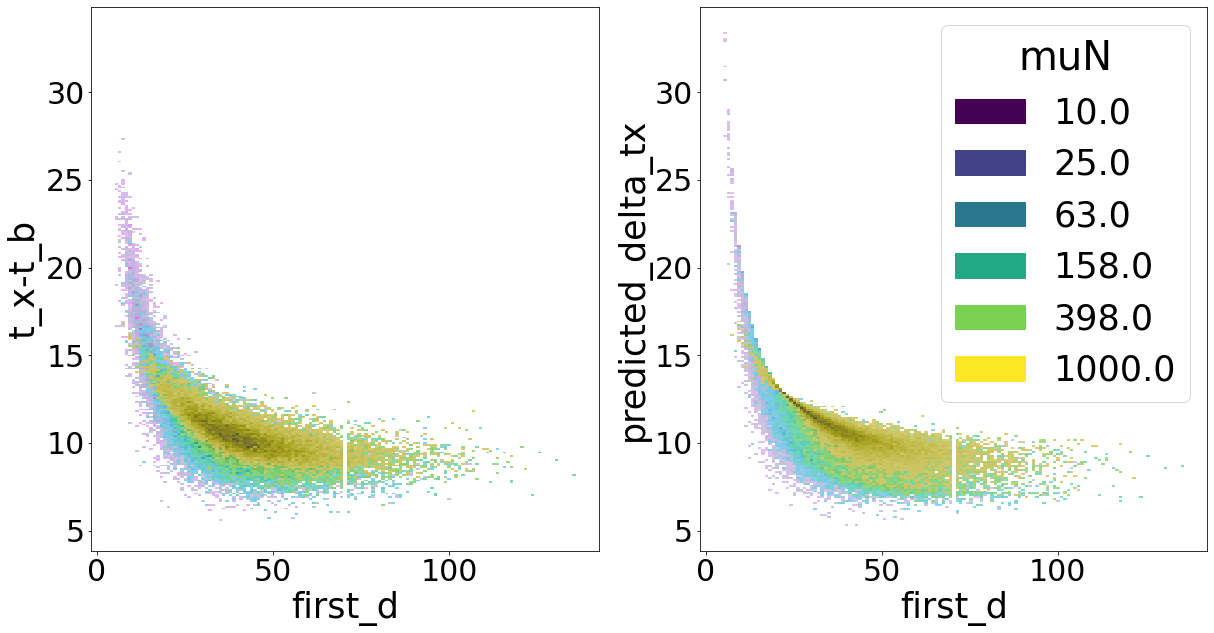

In [35]:
R0 = 2.5
xi = 20
kappa=0
#t_bins = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),100) 
t_bins = np.logspace(0, np.log(funcs.T_ext_deterministic(R0,kappa,N)), 100)

fig,ax= plt.subplots(1,2,figsize=(20,10))

qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi}')
ds = np.arange(1,qfiltered['first_d'].max())
qfiltered['t_x-t_b'] = qfiltered['t_x']-qfiltered['first_tb']
add_column_constant_frequency_intersection(qfiltered, R0, kappa, N)
sns.histplot(qfiltered, x='first_d', y= 't_x-t_b',ax=ax[0],alpha=0.9, hue='muN',palette='viridis',common_norm=False,hue_norm=mpl.colors.LogNorm(), element="step",legend=False)
# ax[0].set_yscale('log')
ax[0].set_ylim(1e1,funcs.T_ext_deterministic(R0,kappa,N))
# ax[0].plot(ds, np.log(N*funcs.y_peak(R0,kappa))/(1-np.exp(-ds/xi)))

sns.histplot(qfiltered, x='first_d', y= 'predicted_delta_tx',ax=ax[1],alpha=0.9, hue='muN',palette='viridis',common_norm=False,hue_norm=mpl.colors.LogNorm(), element="step")
# ax[1].set_yscale('log')
# ax[1].set_ylim(1e1,funcs.T_ext_deterministic(R0,kappa,N))
ax[0].set_ylim(ax[1].get_ylim())

In [36]:
qfiltered['delta_delta_tx'] = qfiltered['t_x-t_b']-qfiltered['predicted_delta_tx']

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


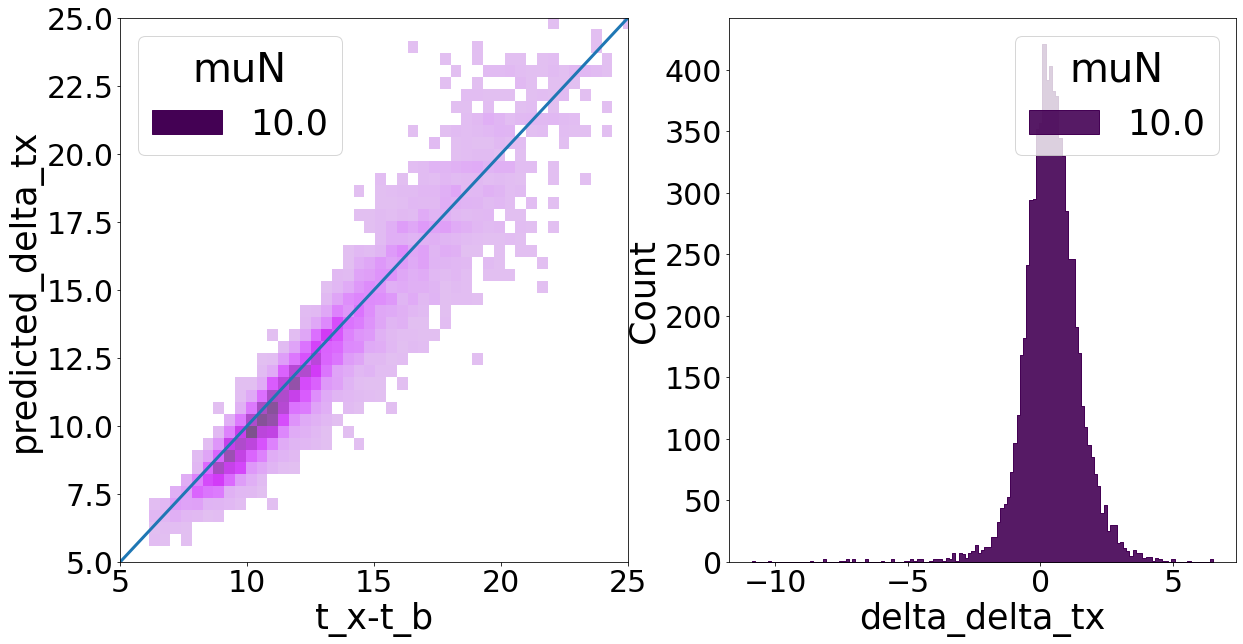

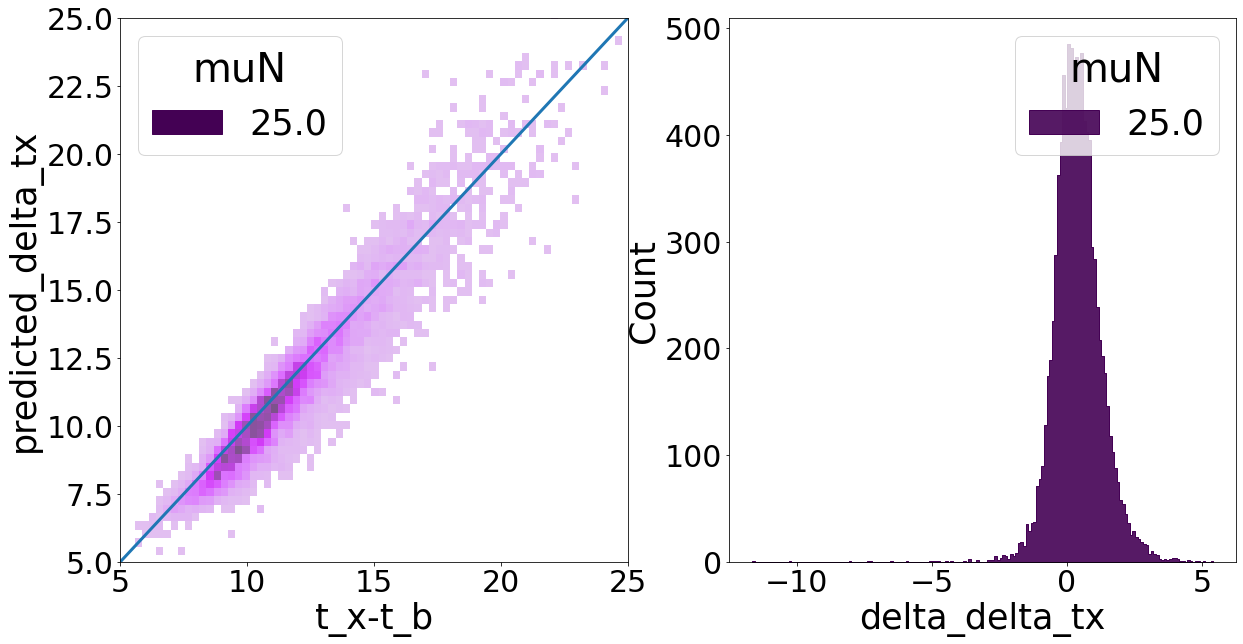

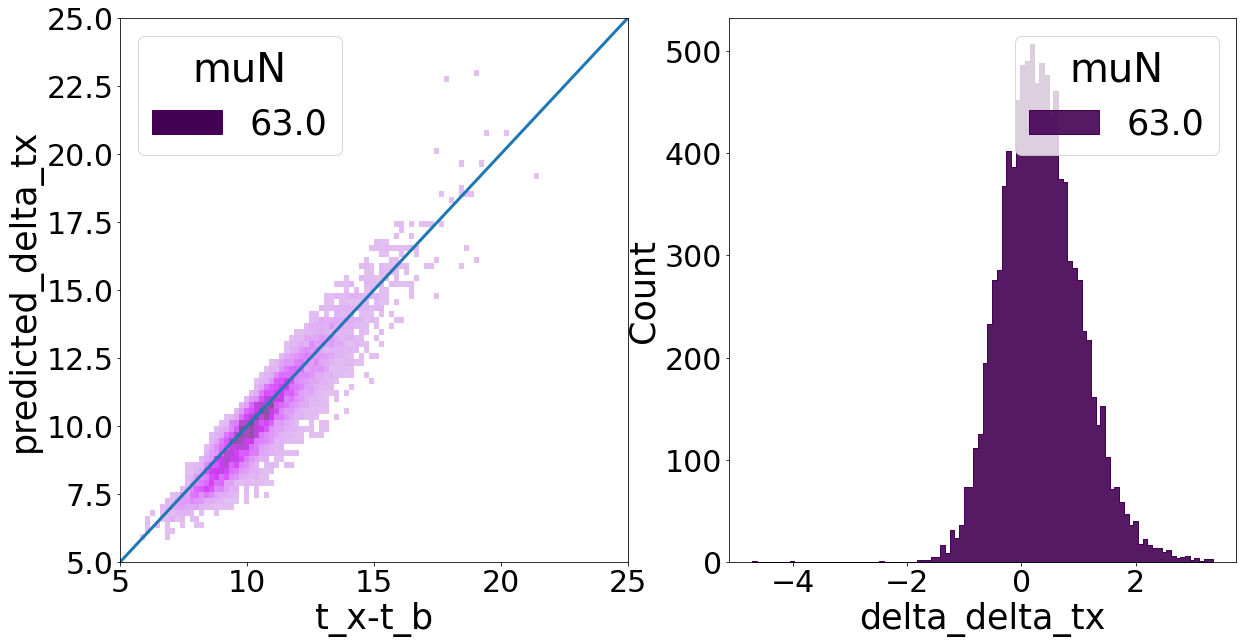

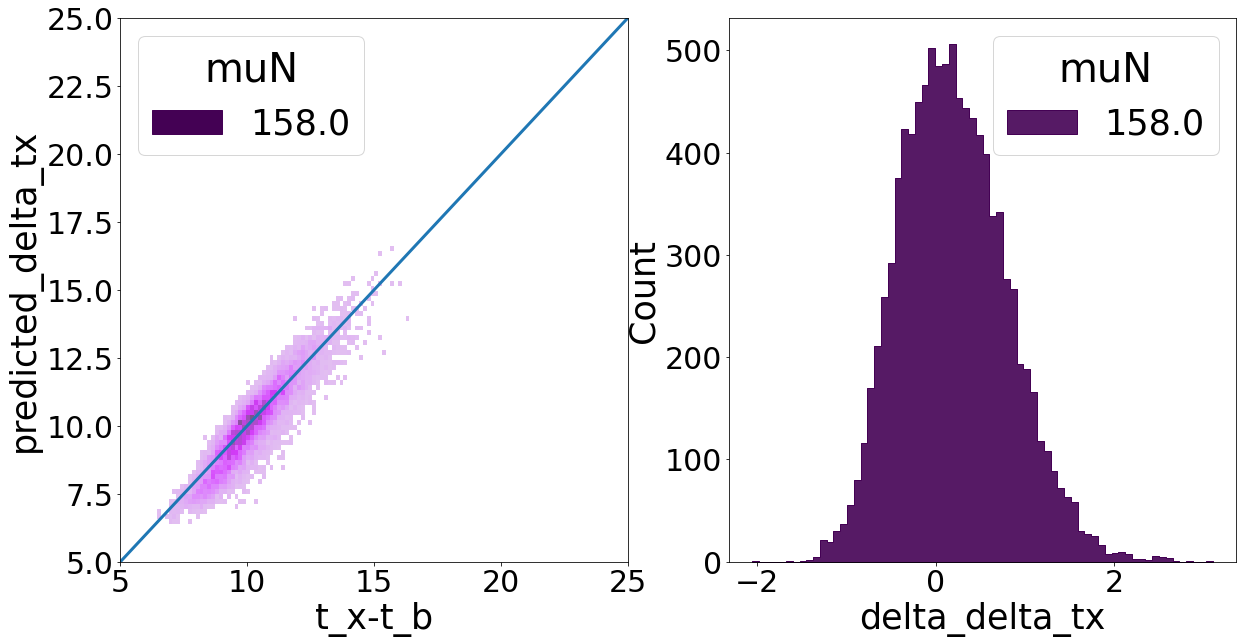

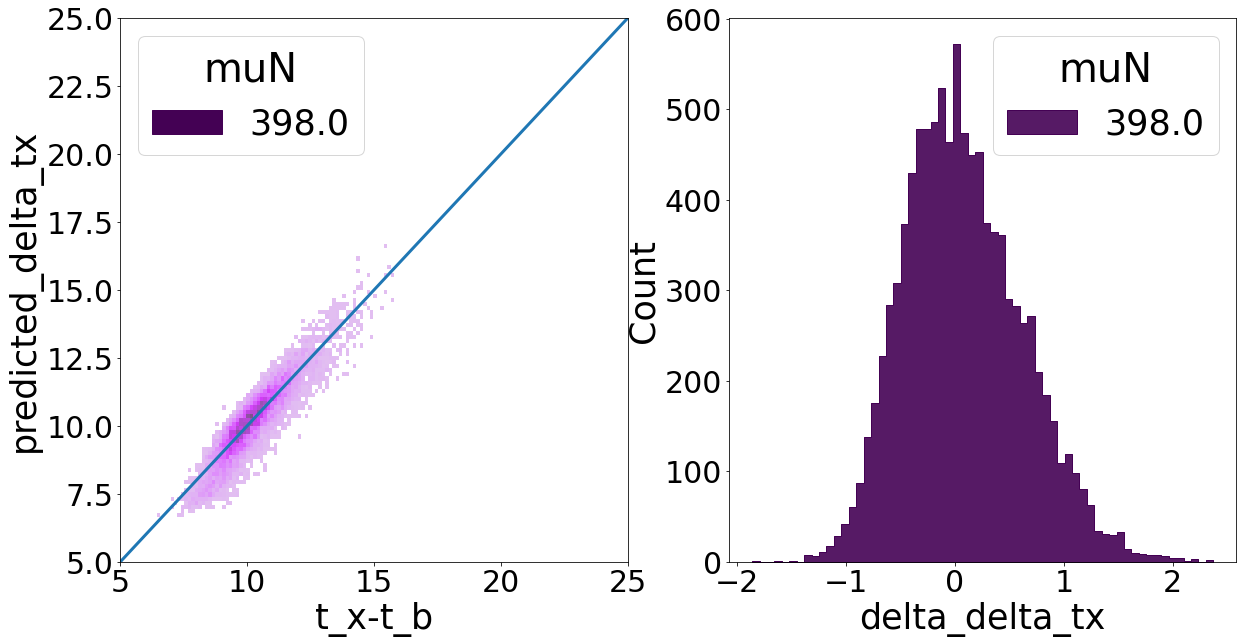

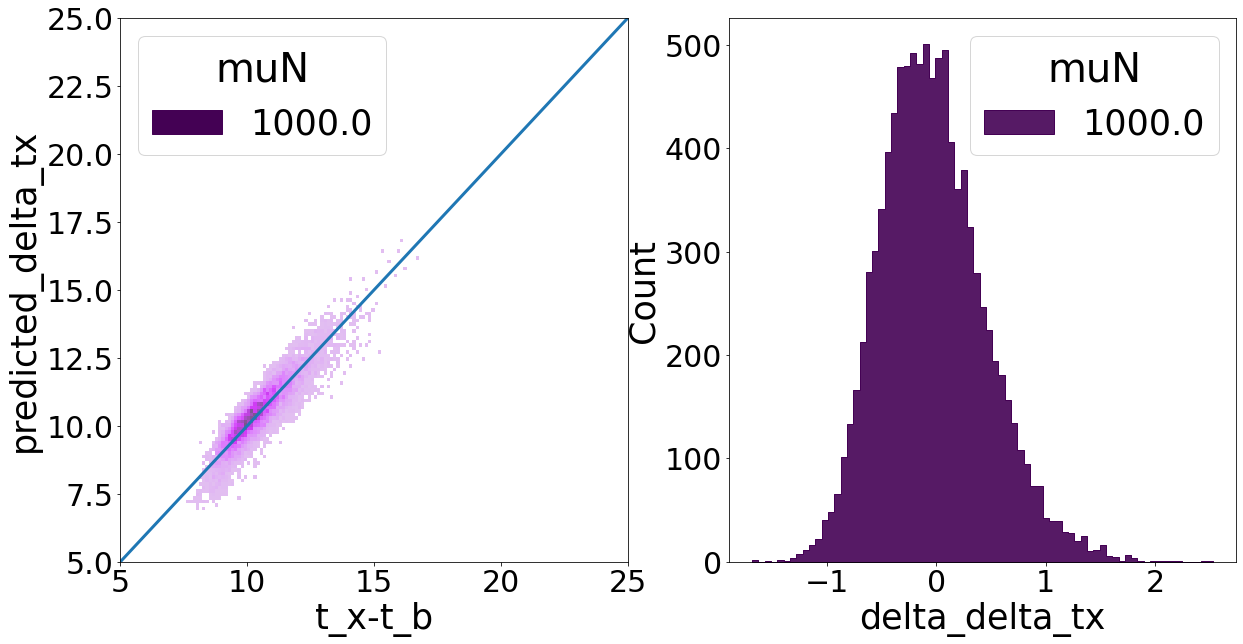

In [37]:
for mu in mu_s:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    sns.histplot(qfiltered.query(f'muN=={np.round(mu*N)}'), ax= ax[0], x='t_x-t_b', y= 'predicted_delta_tx',alpha=0.9, hue='muN',palette='viridis',common_norm=False,hue_norm=mpl.colors.LogNorm(), element="step")
    sns.histplot(qfiltered.query(f'muN=={np.round(mu*N)}'), ax= ax[1], x='delta_delta_tx',alpha=0.9, hue='muN',palette='viridis',common_norm=False,hue_norm=mpl.colors.LogNorm(), element="step")
    ax[0].plot(t_bins, t_bins)
    # ax.set_yscale('log')
    ax[0].set_ylim(5,25)
    ax[0].set_xlim(5,25)
    # ax.set_xscale('log')


NameError: name 'colors_mu' is not defined

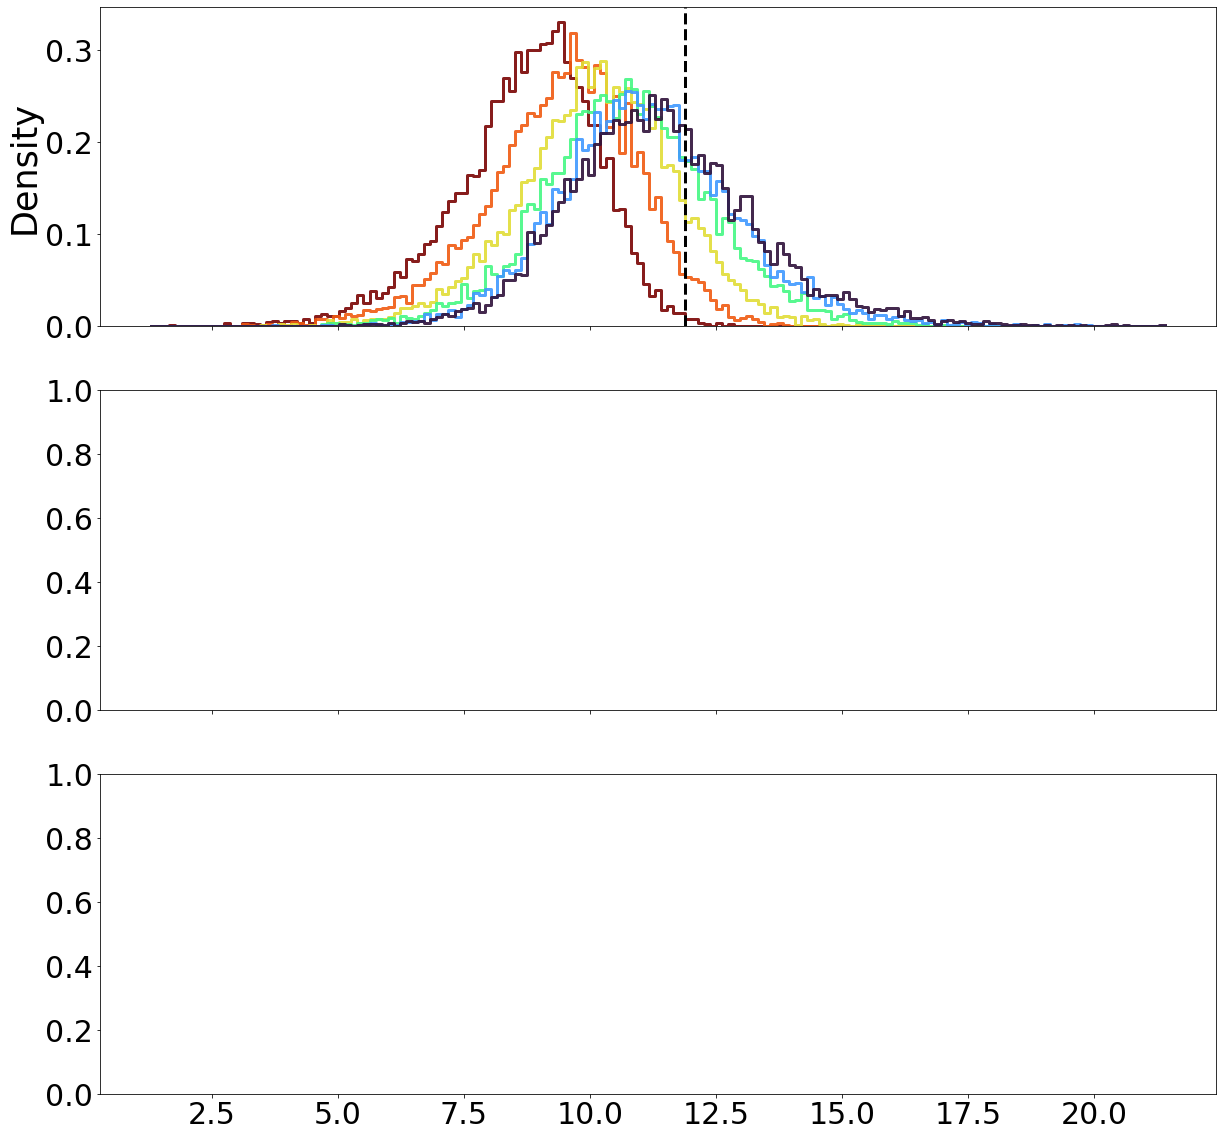

In [38]:
R0 = 2.5
xi = 20
kappa=0
#t_bins = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),100) 
t_bins = np.logspace(0, np.log(funcs.T_ext_deterministic(R0,kappa,N)), 100)

fig,ax= plt.subplots(3,1,figsize=(20,20),sharex=True)

qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi}')
ds  = np.arange(1,qfiltered['first_d'].max())

sns.histplot(qfiltered, x= 'first_tb',ax=ax[0],alpha=0.9, hue='muN',palette='turbo',common_norm=False,hue_norm=mpl.colors.LogNorm(), element="step",legend=False, fill=False, stat='density')
ax[0].axvline(funcs.t_peak(R0,N),color='k',linestyle='--')

ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T

tax = ax[1]
# tax.plot(ts_det, y, color='k',linestyle='--')

for mu in mu_s:
    tax.plot(ts_det,mu*N*y*np.exp(-mu*N*z),color= colors_mu[mu],linestyle='--')
    tax.plot(ts_det,mu*10*np.exp((R0-1)*ts_det -mu*10/(R0-1)*(np.exp((R0-1)*ts_det)-1)),color= colors_mu[mu],linestyle=':')

    tax.axvline( np.log((R0-1)/(10*mu))/(R0-1), color=colors_mu[mu],linestyle='--')

    ax[2].plot(ts_det,mu*N*z, color = colors_mu[mu],linestyle='-')
    ax[2].axvline( np.log((R0-1)/(10*mu))/(R0-1), color=colors_mu[mu],linestyle='--')


#make sure that ax and tax have 0 at same height
ax[0].set_ylim(0,ax[0].get_ylim()[1])
tax.set_ylim(0,tax.get_ylim()[1])

for a in [ax[0],tax]:
    a.set_xlim(0,20)
ax[2].set_yscale('log')
ax[2].axhline(1, color='k',linestyle='--')

In [ ]:
qfiltered.columns

Index(['RunId', 'iteration', 'Step', 'N', 'infection_rate', 'kappa', 'p_alpha',
       'mutation_rate', 'xi', 'recovery_rate', 'initial_infected', 'dt',
       'collect_freqs', 'first_tb', 'first_d', 't_x', 'chi_0', 'muN',
       'first_d_over_xi', 't_x-t_peak', 't_x-t_b', 'predicted_delta_tx',
       'chi0', 'chi0-chi_min'],
      dtype='object')

In [ ]:
qfiltered['logchi_0']=  np.log(qfiltered['chi0'])

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(-18.420680743952367, -2.3025850929940455)

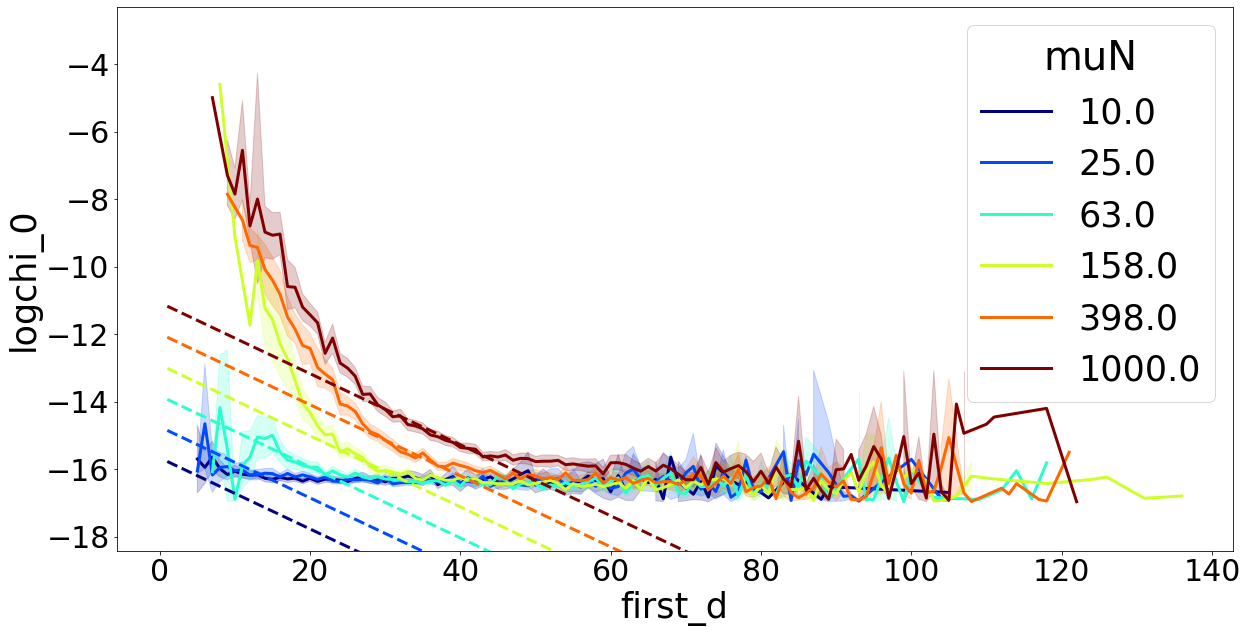

In [ ]:
R0  =
fig,ax =plt.subplots(figsize=(20,10))
colors_mu= {mu:color for mu,color in zip(mu_s,plt.cm.jet(np.linspace(0,1,len(mu_s))))}

qfiltered['chi0-chi_min'] = qfiltered['chi0']- funcs.x_min_luria_dellbruck(R0,N)
# sns.lineplot(data =qfiltered,hue='muN',x='first_d', y='chi0',palette=plt.cm.jet,legend=None, hue_norm=mpl.colors.LogNorm(),linestyle=':')
sns.lineplot(data =qfiltered,hue='muN',x='first_d', y='logchi_0',palette=plt.cm.jet,legend=legend, hue_norm=mpl.colors.LogNorm())

for mu in mu_s:
    Nmup =  N*mu* np.log(R0)/R0
    chi_tilde = (Nmup * (1-p_alpha)**ds * funcs.x_min_luria_dellbruck(R0,N))/(1 + 2*(Nmup*(1-p_alpha)**ds -1)*funcs.x_min_luria_dellbruck(R0,N))

    ax.plot(ds, np.log(chi_tilde) ,color=colors_mu[mu], linestyle='--')
ax.set_ylim(bottom = np.log(1/N), top=np.log(1e-1))

# ax.axhline(1/(N*funcs.y_peak(R0,0)), color='k', linestyle='--')
# ax.set_yscale('log')

In [ ]:
# translate to python: -(((1 - p)**(-1 + d)*R0*(-1 + (-1 + (Npop*(-1 + R0 - Log(R0)))/R0)**((1 - E**(-d/\[Xi]))/(1 - ((Npop*\[Mu]*Log(R0))/R0)**(-1/(p*\[Xi]))))))/(Npop + 2*R0 - Npop*R0 + Npop*Log(R0)))
distrib_theo = lambda d, R0, p_alpha, xi, mu, N: -(((1 - p_alpha)**(-1 + d)*R0*(-1 + (-1 + (N*(-1 + R0 - np.log(R0)))/R0)**((1 - np.exp(-d/xi))/(1 - ((N*mu*np.log(R0)/R0))**(-1/(p_alpha*xi))))))/(N + 2*R0 - N*R0 + N*np.log(R0)))

#limiting distrib: -(((1 - p)**(-1 + x/p)*R0*(-1 + (-1 + (Npop*(-1 + R0 - Log(R0)))/R0)**(1 - E**(-x/(p*\[Xi])))))/(Npop + 2*R0 - Npop*R0 + Npop*Log(R0)))
limiting_distrib = lambda d,R0,p_alpha,xi,N: -(((1 - p_alpha)**(-1 + d)*R0*(-1 + (-1 + (N*(-1 + R0 - np.log(R0)))/R0)**(1 - np.exp(-d/(xi)))))/(N + 2*R0 - N*R0 + N*np.log(R0)))

# avg x d : -((Log(10) - Log(1 + (-1 + 1/xmin)**((1 - E**(-d/\[Xi]))/(1 - R0**(1/(p*\[Xi]))/((Npop*\[Mu])**(1/(p*\[Xi]))*Log(R0)**(1/(p*\[Xi])))))))/(-9 + (-1 + 1/xmin)**((1 - E**(-d/\[Xi]))/(1 - R0**(1/(p*\[Xi]))/((Npop*\[Mu])**(1/(p*\[Xi]))*Log(R0)**(1/(p*\[Xi])))))))
avg_x_d = lambda d, R0, p_alpha, xi, mu, N: -((np.log(10) - np.log(1 + (-1 + 1/funcs.x_min_luria_dellbruck(R0,N))**((1 - np.exp(-d/xi))/(1 - R0**(1/(p_alpha*xi))/((N*mu)**(1/(p_alpha*xi))*np.log(R0)**(1/(p_alpha*xi)))))))/(-9 + (-1 + 1/funcs.x_min_luria_dellbruck(R0,N))**((1 - np.exp(-d/xi))/(1 - R0**(1/(p_alpha*xi))/((N*mu)**(1/(p_alpha*xi))*np.log(R0)**(1/(p_alpha*xi)))))))

#x_min_d = 1 + (1/xmin-1)**((1-c(d))/(1-(Nmu)**(-1/(p_alpha*xi)))
x_min_d = lambda d, R0, p_alpha, xi, mu, N: np.power(1 + (1/funcs.x_min_luria_dellbruck(R0,N)-1)**((1-np.exp(-d/xi))/(1-(N*mu)**(-1/(p_alpha*xi)))),-1)

In [ ]:
#turn off warnings
import warnings

warnings.filterwarnings('ignore')

In [ ]:
for R0 in tqdm(R0s):
    for mu in mu_s:
        fig,ax = plt.subplots(2,2, sharex= True,figsize=(20,10))
        for ix, xi in enumerate(xi_s):
            qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and muN=={np.round(mu*N)}')
            qfiltered['logchi_0']=  np.log(qfiltered['chi_0'])
            ds = np.arange(1,qfiltered['first_d'].max())
            Nmup =  N*mu* np.log(R0)/R0
            chi_tilde = (Nmup * (1-p_alpha)**ds * funcs.x_min_luria_dellbruck(R0,N))/(1 + 2*(Nmup*(1-p_alpha)**ds -1)*funcs.x_min_luria_dellbruck(R0,N))
            ax[0,ix].plot(ds, np.log(chi_tilde) ,color=colors_mu[mu], linestyle='--')
            x_min_d = np.power(1 + (1/funcs.x_min_luria_dellbruck(R0,N)-1)**((1-np.exp(-ds/xi))/(1-(N*mu)**(-1/(p_alpha*xi)))),-1)
            ax[0,ix].plot(ds, np.log(x_min_d) ,color=colors_mu[mu], linestyle=':')

            sns.lineplot(data =qfiltered, alpha=1,x='first_d', y='logchi_0', ax= ax[0,ix],color= colors_mu[mu])
            ax[0,ix].set_ylim(bottom = np.log(1/N), top=np.log(1e-1))

            sns.histplot(qfiltered, x='first_d',ax=ax[1,ix],alpha=0.9, bins=ds, color = colors_mu[mu], element="step",legend=False, stat='density')
            distrib = distrib_theo(ds, R0, p_alpha, xi, mu, N)
            distrib/= np.sum(distrib)

            limdistrb  = limiting_distrib(ds, R0, p_alpha, xi, N)
            limdistrb/= np.sum(limdistrb)

            ax[1,ix].plot(ds, distrib, color=colors_mu[mu], linestyle='--')
            ax[1,ix].plot(ds, limdistrb, color='black', linestyle=':')

            ax[1,ix].set_xlim((0,150))

            ax[0,ix].set_title(fr'$\xi={xi}$')
        fig.suptitle(fr'$R_0={R0}, \mu N={np.round(mu*N)}$')
        fig.savefig(results_folder + f'/first_distributions_R0_{R0}_muN_{np.round(mu*N)}.jpg')
        plt.close(fig)

100%|██████████| 4/4 [03:28<00:00, 52.22s/it]


In [ ]:
R0

2.5

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is tryin

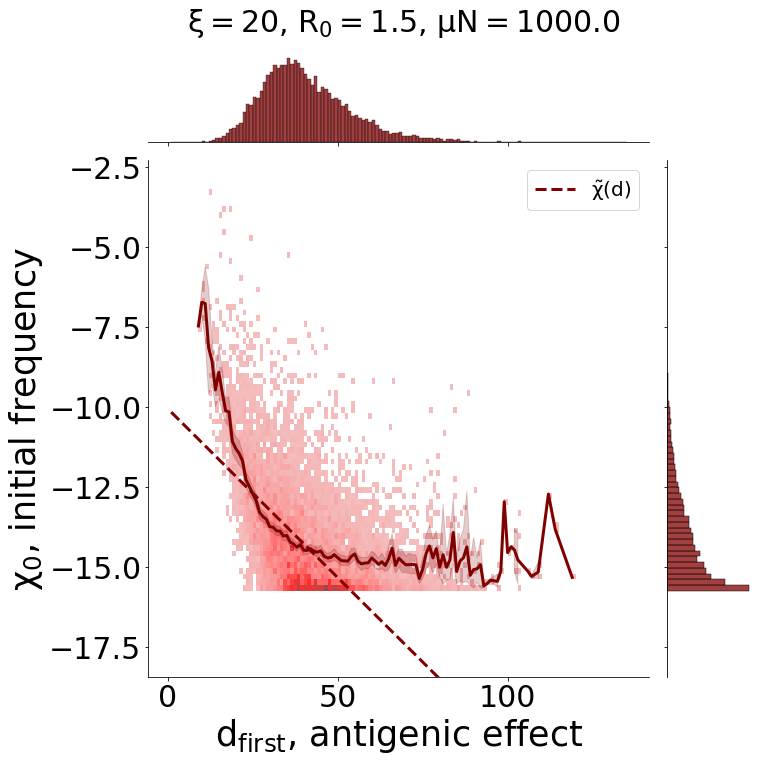

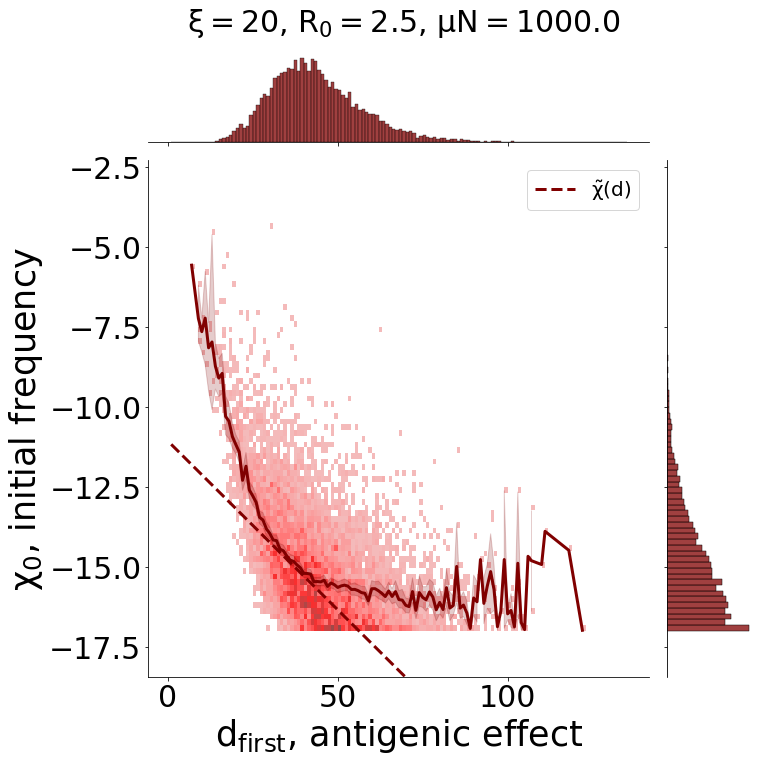

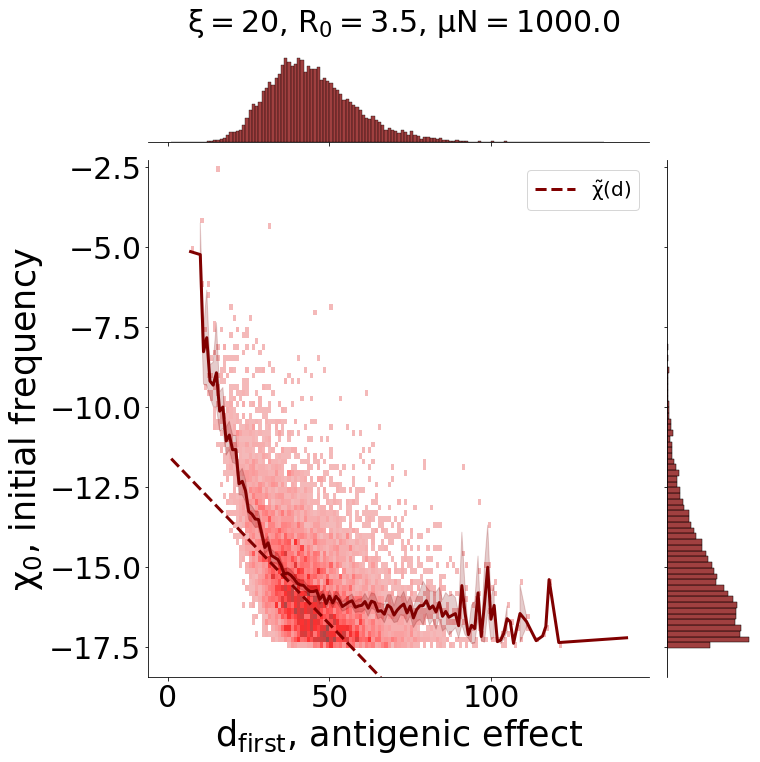

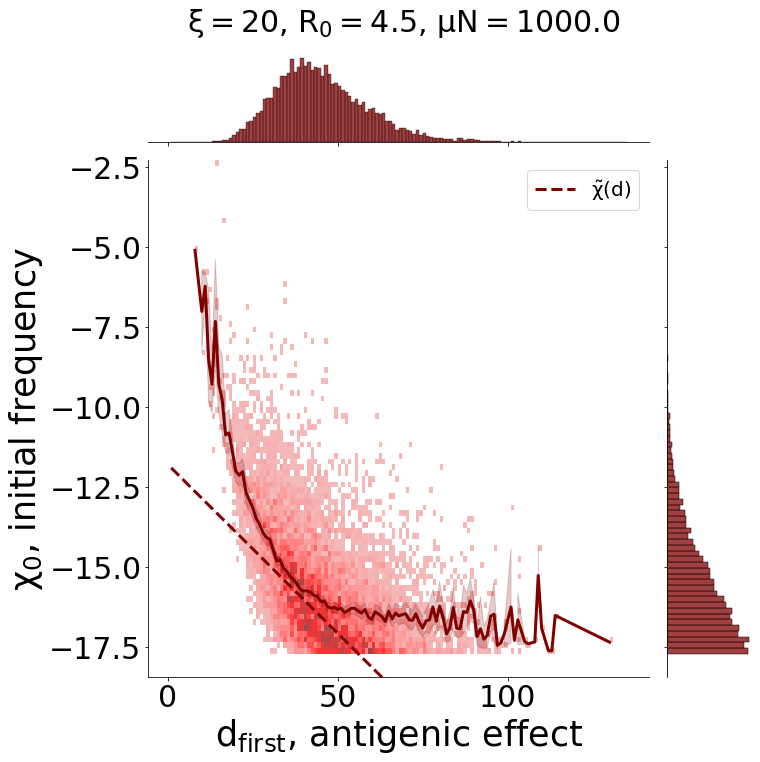

In [ ]:
xi = 20
for R0 in R0s:
    qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and muN=={np.round(mu*N)}')
    qfiltered['logchi_0']=  np.log(qfiltered['chi_0'])

    J = sns.jointplot(qfiltered, x='first_d', y='logchi_0',alpha=0.9, color = colors_mu[mu],kind='hist', bins = (ds, np.linspace(np.log(1/N),np.log(5e-1),100)), element="step",legend=False,height=10)
    sns.lineplot(data =qfiltered, alpha=1,x='first_d', y='logchi_0', ax= J.ax_joint ,color= colors_mu[mu])
    Nmup =  N*mu* np.log(R0)/R0
    chi_tilde = (Nmup * (1-p_alpha)**ds * funcs.x_min_luria_dellbruck(R0,N))/(1 + 2*(Nmup*(1-p_alpha)**ds -1)*funcs.x_min_luria_dellbruck(R0,N))
    J.ax_joint.plot(ds, np.log(chi_tilde) ,color=colors_mu[mu], linestyle='--', label = r'$\tilde{\chi}(d)$')
    J.ax_joint.set_ylim(bottom = np.log(1/N), top=np.log(1e-1))
    J.ax_joint.legend(fontsize=20)
    J.ax_joint.set_xlabel(r'$d_\mathrm{first}$, antigenic effect')
    J.ax_joint.set_ylabel(r'$\chi_0$, initial frequency')

    J.fig.suptitle(fr'$\xi={xi:.0f}$, $R_0={R0}$, $\mu N={np.round(mu*N,0)}$',y= 1.05, fontsize=30)
    plt.savefig( results_folder+f'/first_d_chi0_xi{xi}_R0{R0}_muN{np.round(mu*N,0)}.jpg', bbox_inches='tight')


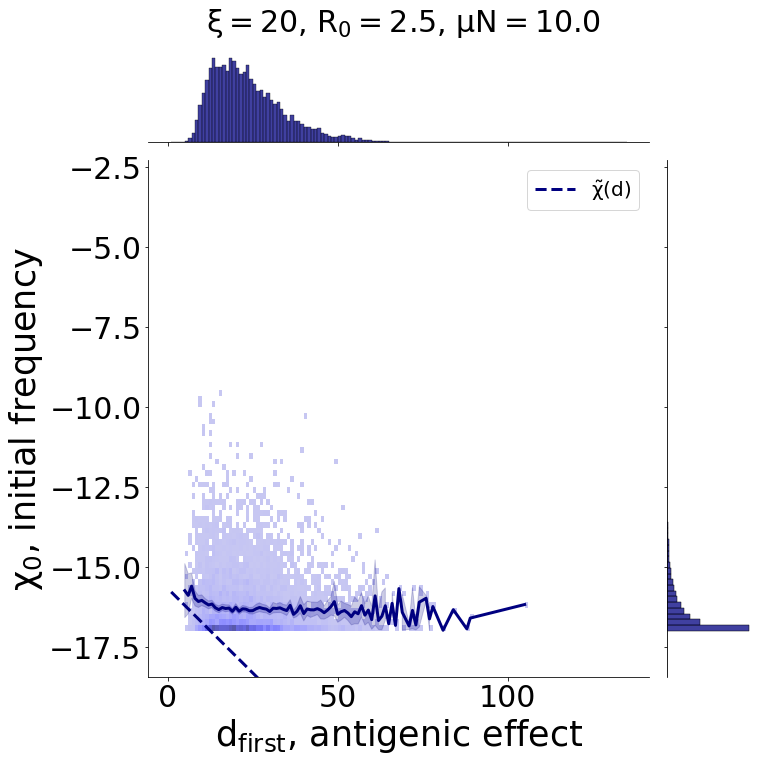

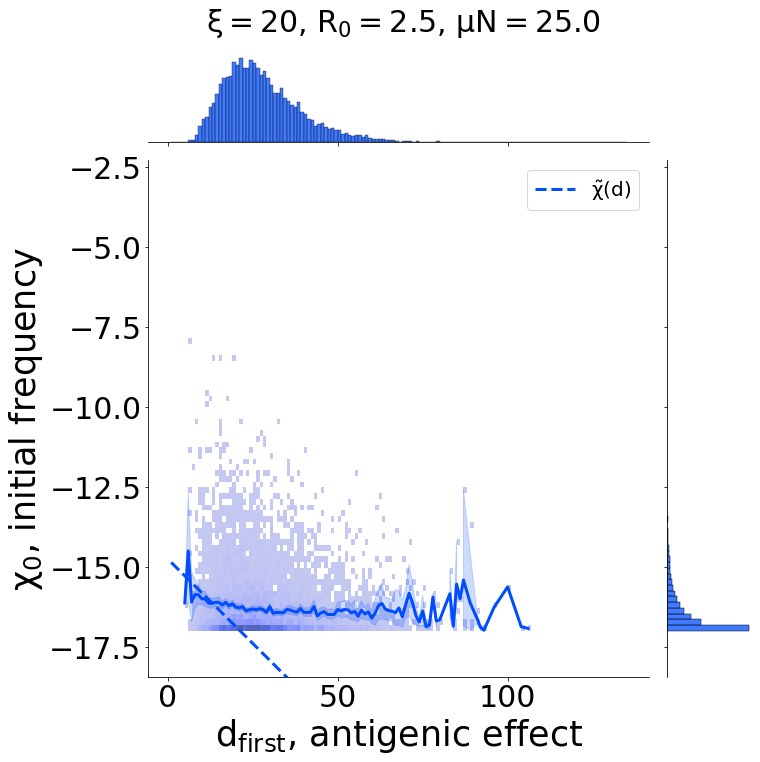

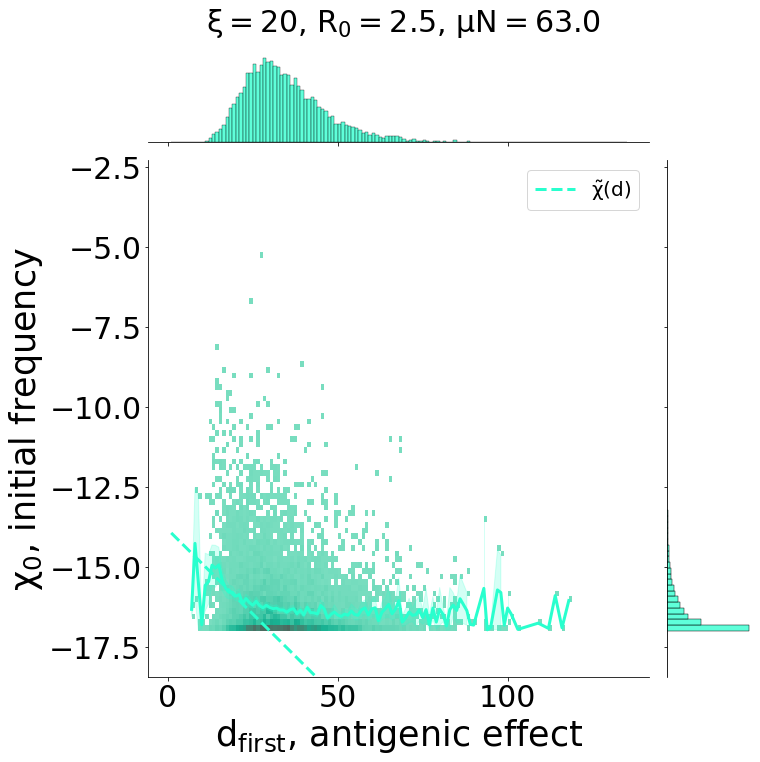

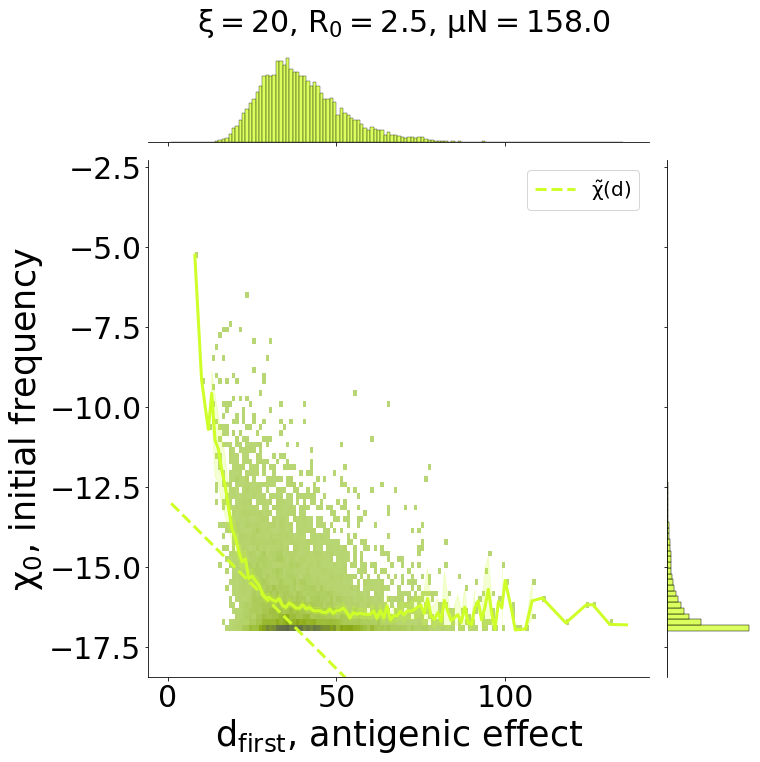

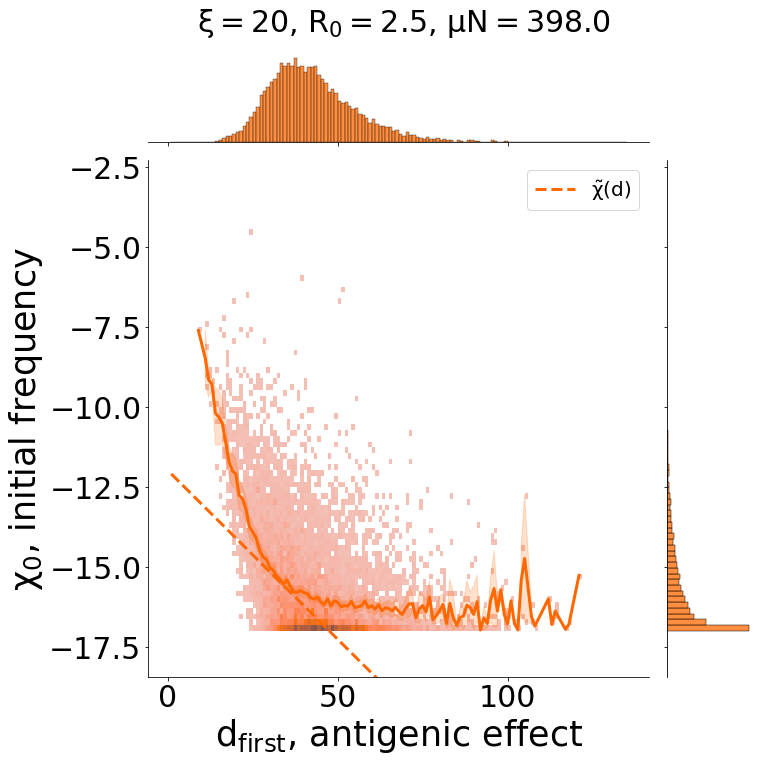

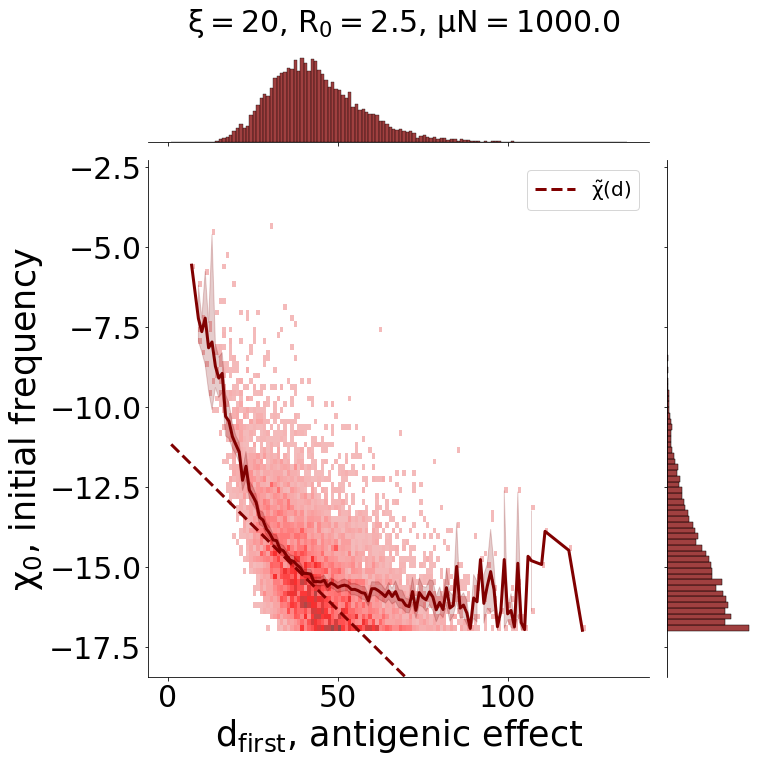

In [ ]:
xi = 20
R0 = 2.5
for mu in mu_s:
    qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and muN=={np.round(mu*N)}')
    qfiltered['logchi_0']=  np.log(qfiltered['chi_0'])

    J = sns.jointplot(qfiltered, x='first_d', y='logchi_0',alpha=0.9, color = colors_mu[mu],kind='hist', bins = (ds, np.linspace(np.log(1/N),np.log(5e-1),100)), element="step",legend=False,height=10)
    sns.lineplot(data =qfiltered, alpha=1,x='first_d', y='logchi_0', ax= J.ax_joint ,color= colors_mu[mu])
    Nmup =  N*mu* np.log(R0)/R0
    chi_tilde = (Nmup * (1-p_alpha)**ds * funcs.x_min_luria_dellbruck(R0,N))/(1 + 2*(Nmup*(1-p_alpha)**ds -1)*funcs.x_min_luria_dellbruck(R0,N))
    J.ax_joint.plot(ds, np.log(chi_tilde) ,color=colors_mu[mu], linestyle='--', label = r'$\tilde{\chi}(d)$')
    J.ax_joint.set_ylim(bottom = np.log(1/N), top=np.log(1e-1))
    J.ax_joint.legend(fontsize=20)
    J.ax_joint.set_xlabel(r'$d_\mathrm{first}$, antigenic effect')
    J.ax_joint.set_ylabel(r'$\chi_0$, initial frequency')

    J.fig.suptitle(fr'$\xi={xi:.0f}$, $R_0={R0}$, $\mu N={np.round(mu*N,0)}$',y= 1.05, fontsize=30)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


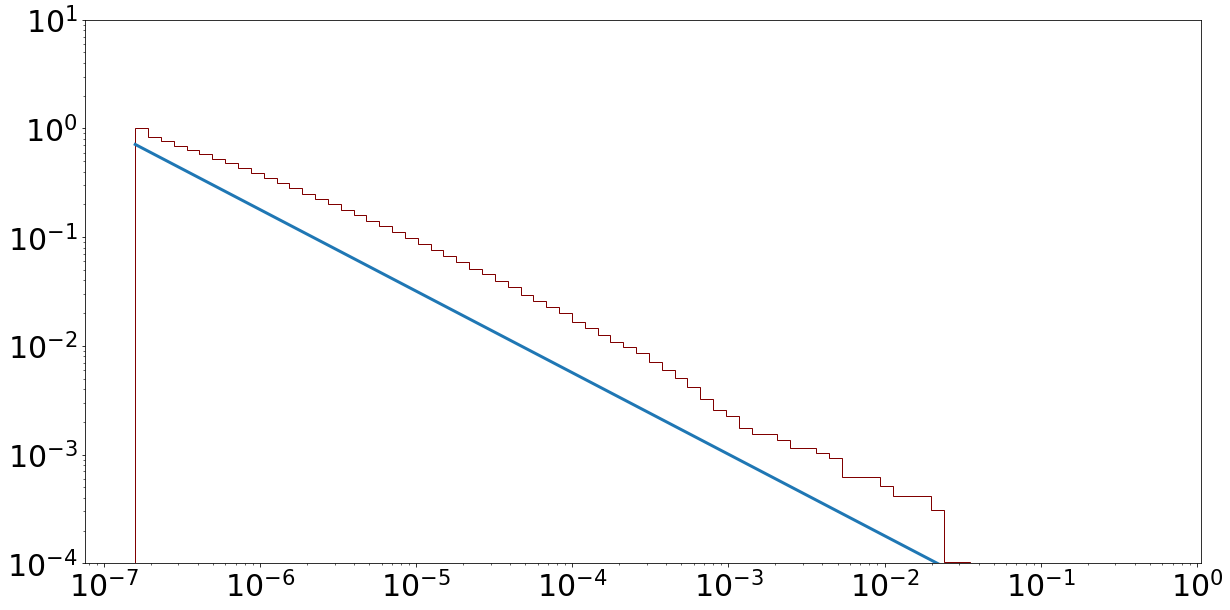

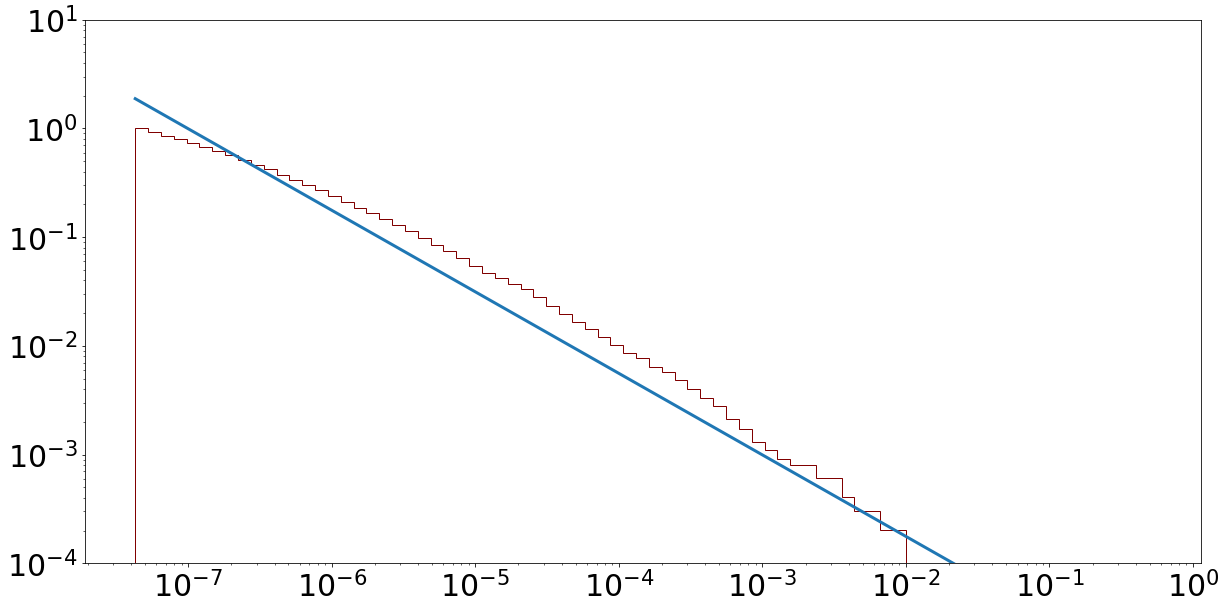

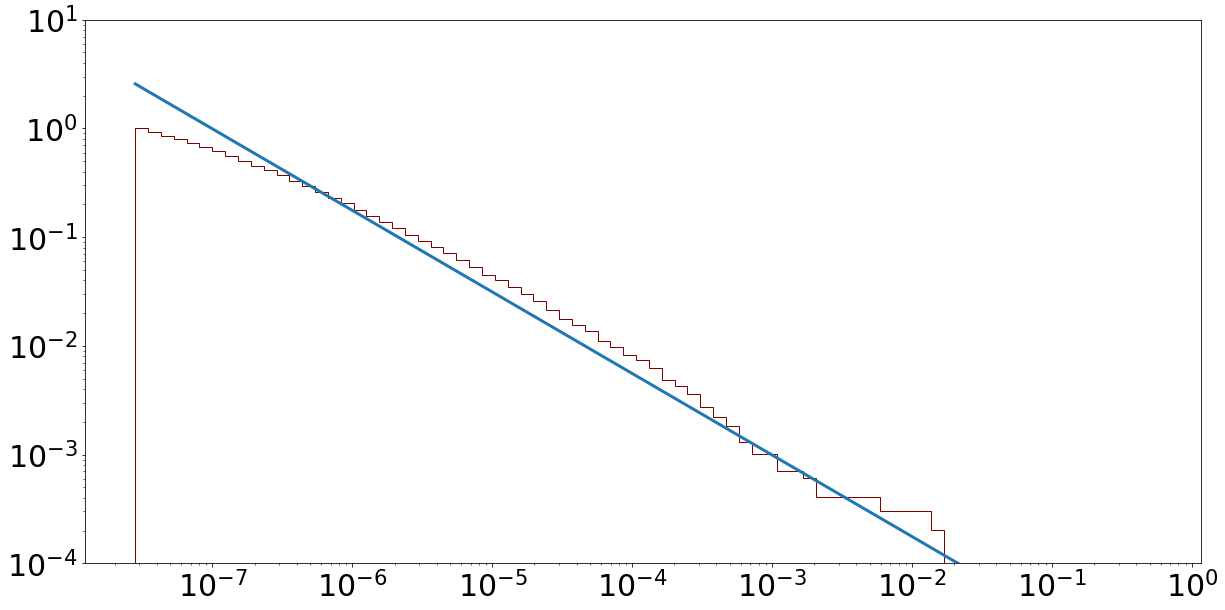

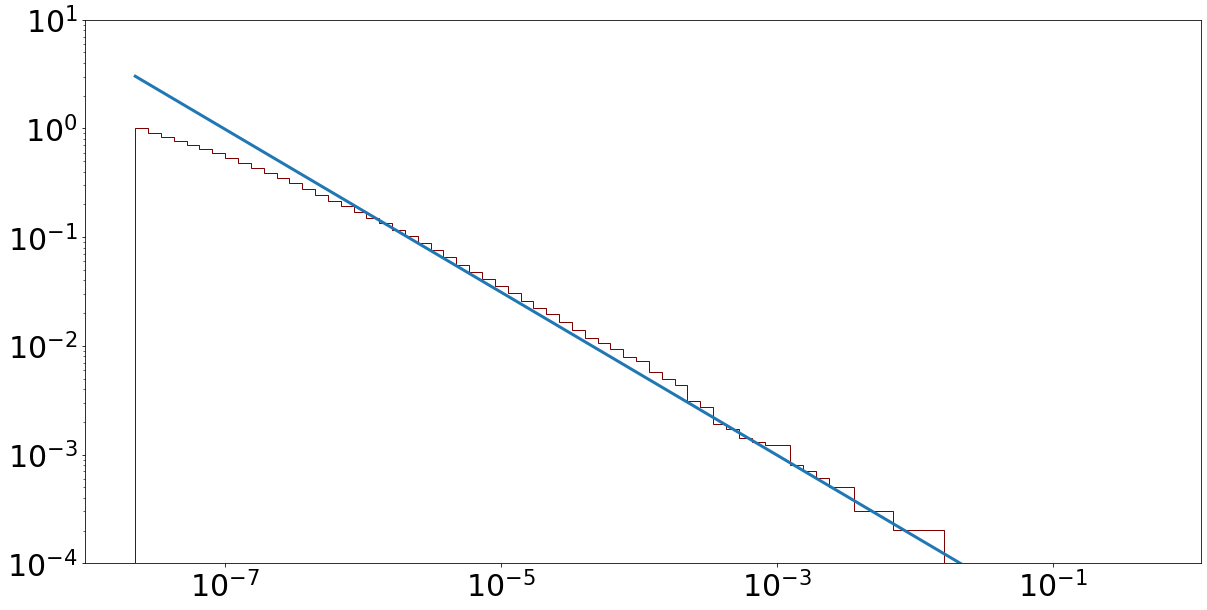

In [ ]:
for R0 in R0s:
    qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and muN=={np.round(mu*N)}')
    qfiltered['logchi_0']=  np.log(qfiltered['chi_0'])
    fig,ax = plt.subplots(figsize=(20,10))
    freqbins = np.logspace(np.log10(1/(funcs.y_peak(R0)*N)),np.log10(5e-1),80)

    plt.hist(qfiltered['chi_0'], bins=freqbins, density=True,cumulative=-1, histtype='step', color=colors_mu[mu], label = r'$\chi_0$')

    plaw = 1/(freqbins**0.75)
    plaw/= np.sum(plaw[:-1]*np.diff(freqbins))
    plt.plot(freqbins, plaw/5e4)
    # plt.plot(freqbins, np.exp(-10*freqbins))

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1e-4, top=10)




NameError: name 'mu_s' is not defined

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/dtrimcev/.py

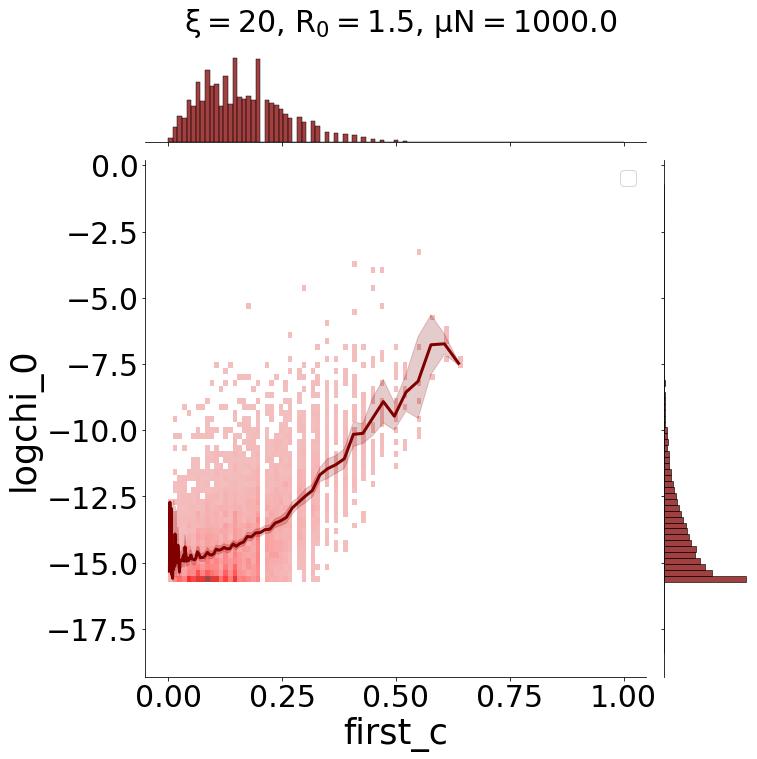

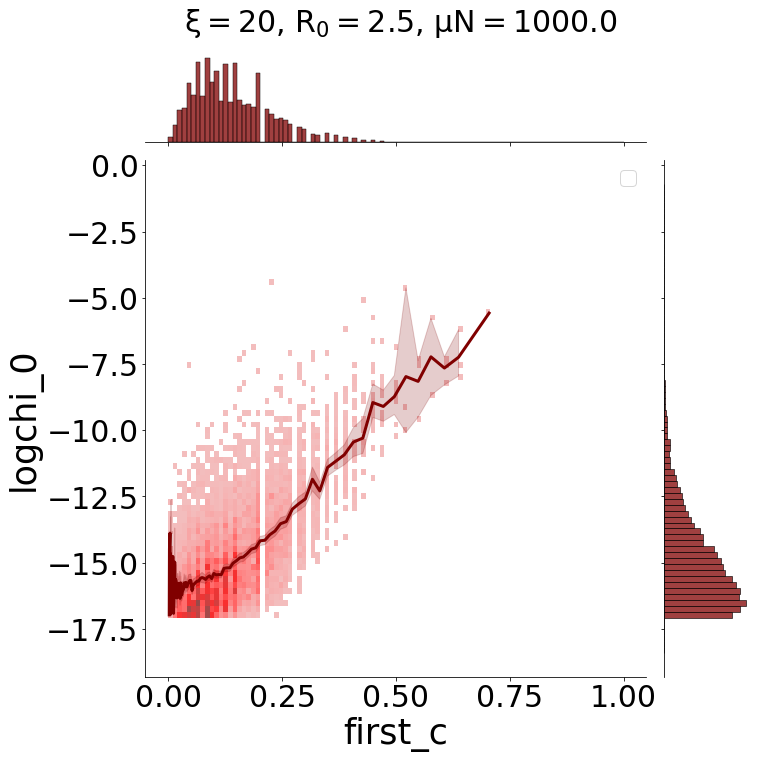

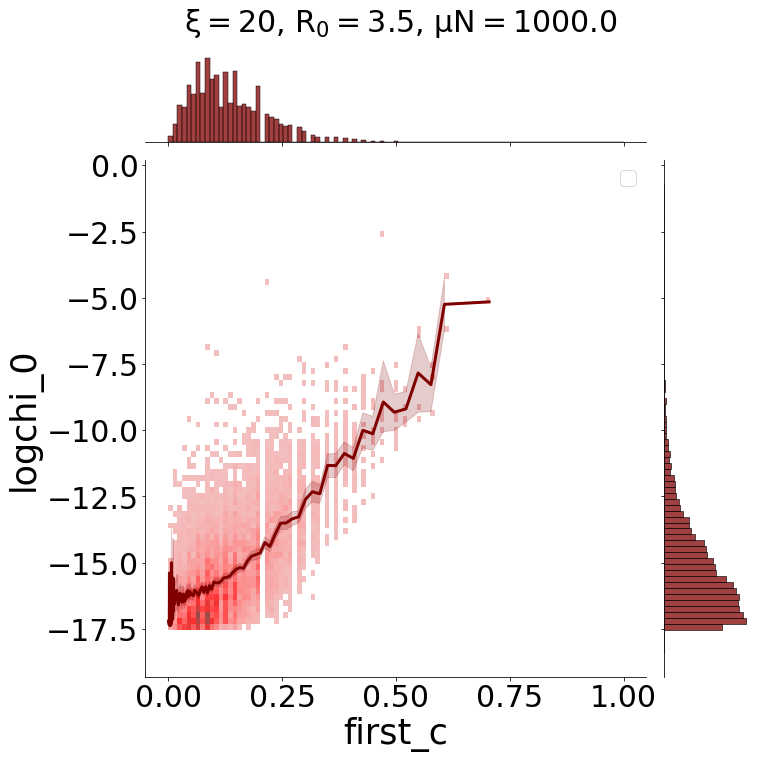

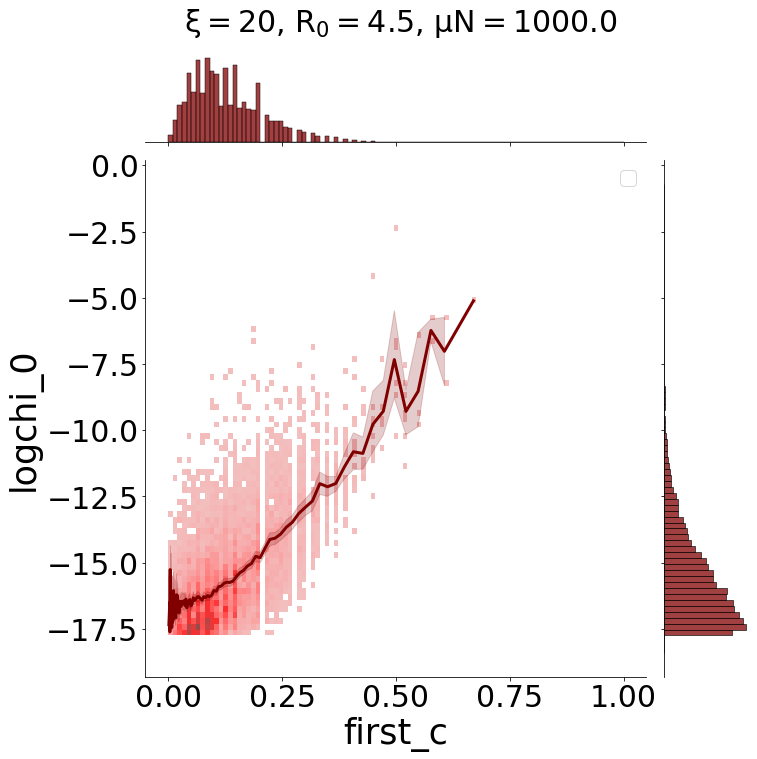

In [ ]:
xi = 20
for R0 in R0s:
    qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and muN=={np.round(mu*N)}')
    qfiltered['logchi_0']=  np.log(qfiltered['chi_0'])
    qfiltered['first_c'] = np.exp(-qfiltered['first_d']/qfiltered['xi'])
    J = sns.jointplot(qfiltered, x='first_c', y='logchi_0',alpha=0.9, color = colors_mu[mu],kind='hist', bins = (np.linspace(0,1,100), np.linspace(np.log(1/N),np.log(5e-1),80)), element="step",legend=False,height=10)
    sns.lineplot(data =qfiltered, alpha=1,x='first_c', y='logchi_0', ax= J.ax_joint ,color= colors_mu[mu])
    Nmup =  N*mu* np.log(R0)/R0
    chi_tilde = (Nmup * (1-p_alpha)**ds * funcs.x_min_luria_dellbruck(R0,N))/(1 + 2*(Nmup*(1-p_alpha)**ds -1)*funcs.x_min_luria_dellbruck(R0,N))
    # J.ax_joint.plot(ds, np.log(chi_tilde) ,color=colors_mu[mu], linestyle='--', label = r'$\tilde{\chi}(d)$')
    # J.ax_joint.set_ylim(bottom = np.log(1/N), top=np.log(1e-1))
    J.ax_joint.legend(fontsize=20)
    # J.ax_joint.set_xlabel(r'$d_\mathrm{first}$, antigenic effect')
    # J.ax_joint.set_ylabel(r'$\chi_0$, initial frequency')

    J.fig.suptitle(fr'$\xi={xi:.0f}$, $R_0={R0}$, $\mu N={np.round(mu*N,0)}$',y= 1.05, fontsize=30)
    # plt.savefig( results_folder+f'/first_d_chi0_xi{xi}_R0{R0}_muN{np.round(mu*N,0)}.jpg', bbox_inches='tight')


In [ ]:
def d_evt(mu, R0, p_alpha,N):
    return np.log((R0)/(N*mu*np.log(R0)))/np.log(1-p_alpha)

# create df for d_evt for all parameters
d_evt_df = pd.DataFrame(columns=['muN','R0','p_alpha','d_evt'])
for mu in mu_s:
    for R0 in R0s:
            d_evt_df = d_evt_df.append({'muN':np.round(mu*N),'R0':R0,'p_alpha':p_alpha,'d_evt':d_evt(mu,R0,p_alpha,N)},ignore_index=True)

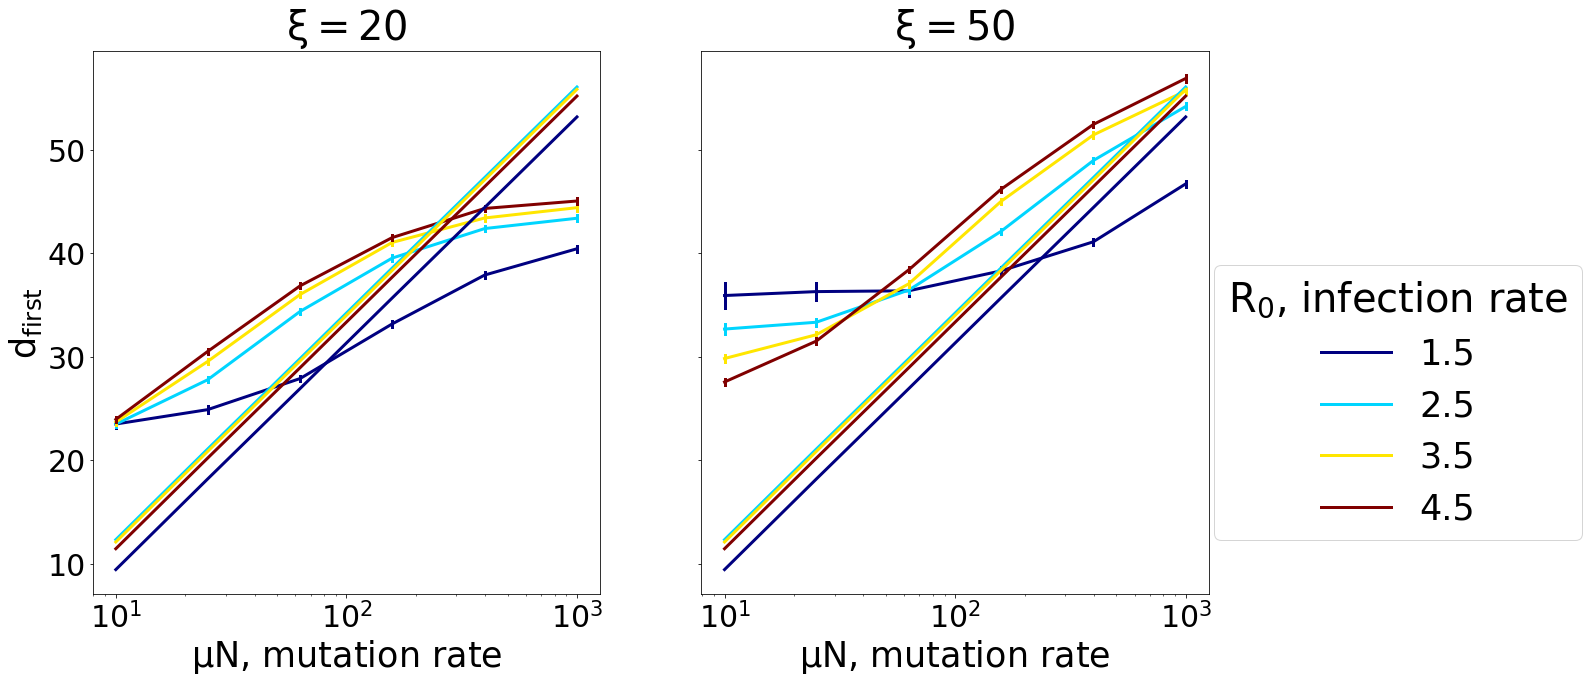

In [ ]:
colors_R0 = funcs.color_dict(R0s, plt.cm.jet)

#create a dataframe for fits 
fit_df = pd.DataFrame(columns=['xi','R0','a','b'])

fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    qfiltered = filtered_df.query(f'xi=={xi}')
    sns.lineplot(data =qfiltered,hue='infection_rate',y='first_d', x='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend)

    sns.lineplot(data= d_evt_df, hue = 'R0', y='d_evt', x='muN', ax=ax[ix], palette=plt.cm.jet,legend=None)
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    ax[ix].set_xscale('log')
for a in ax:
    
    a.set_xlabel(r'$\mu N$, mutation rate')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
ax[-1].legend(title=r'$R_0$, infection rate',loc=(1.01,.1),title_fontsize=40)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

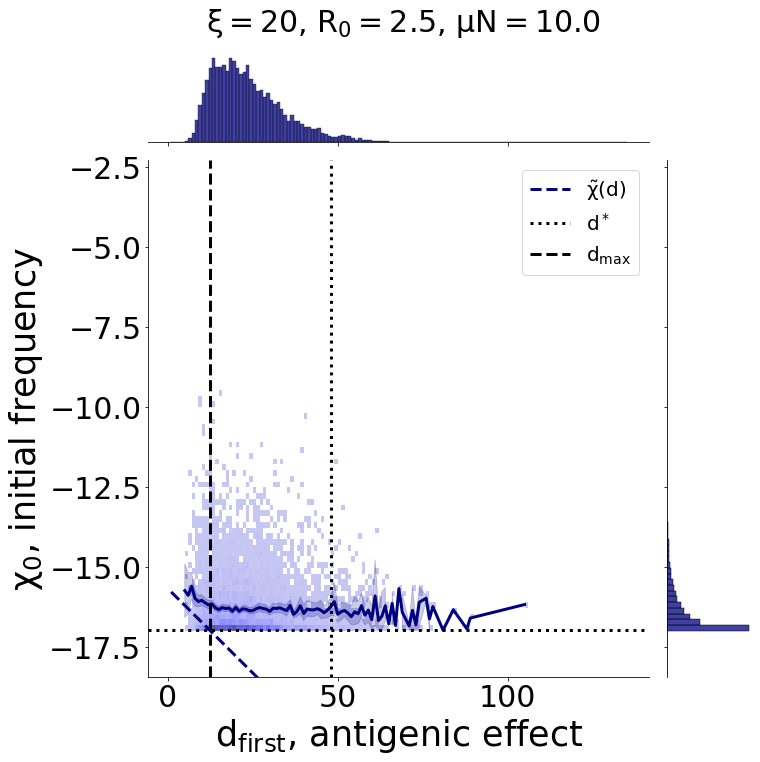

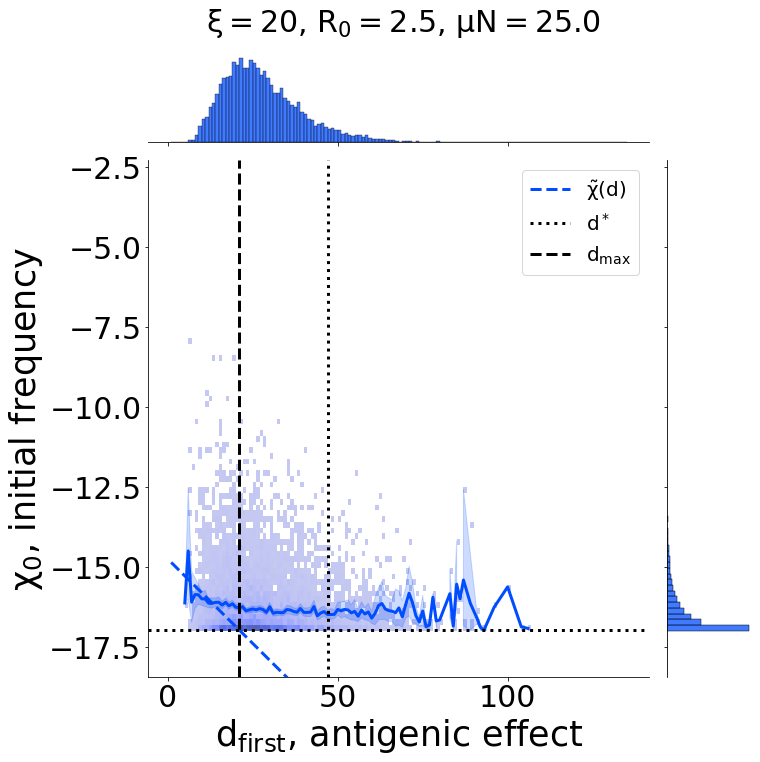

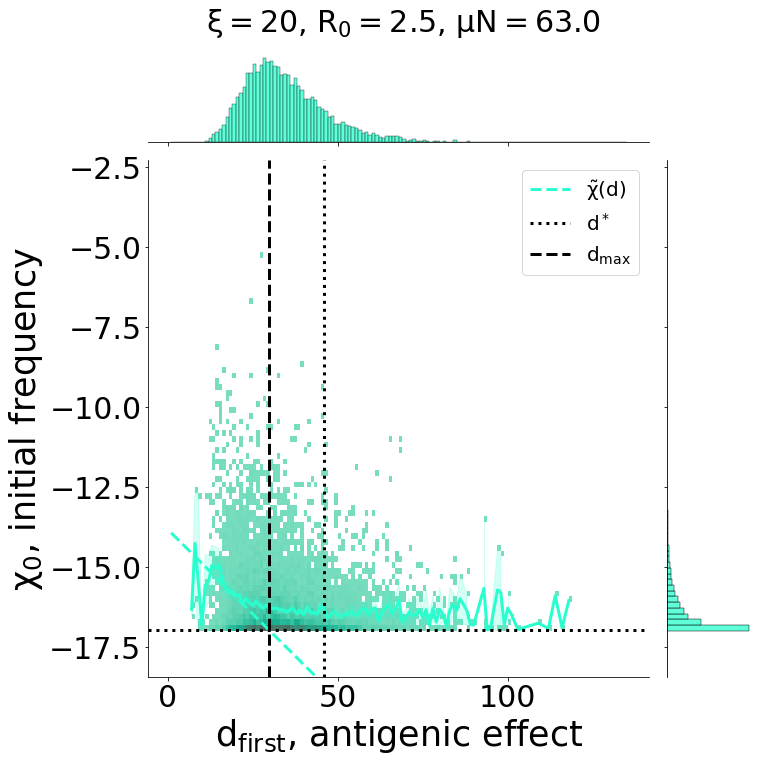

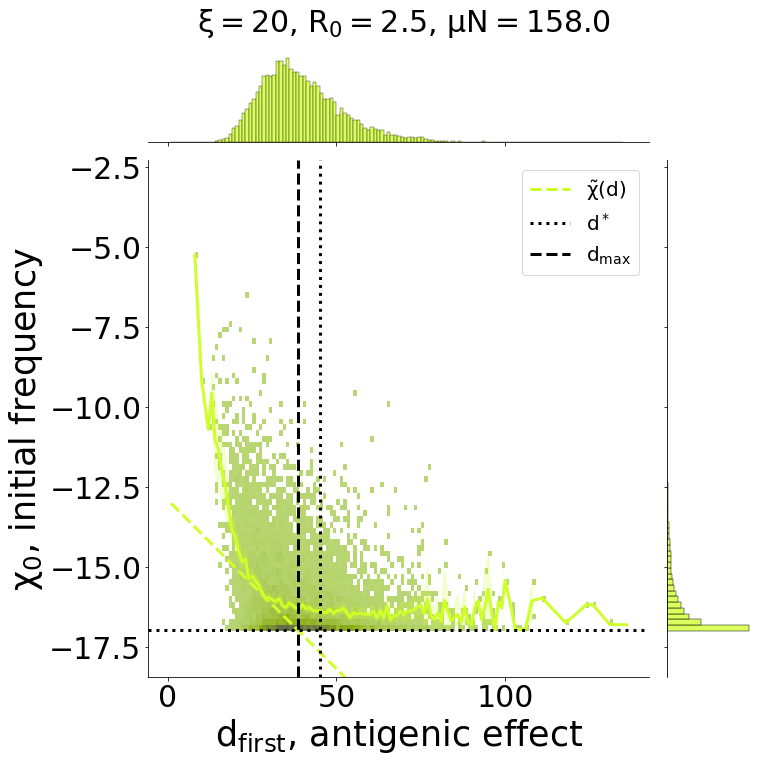

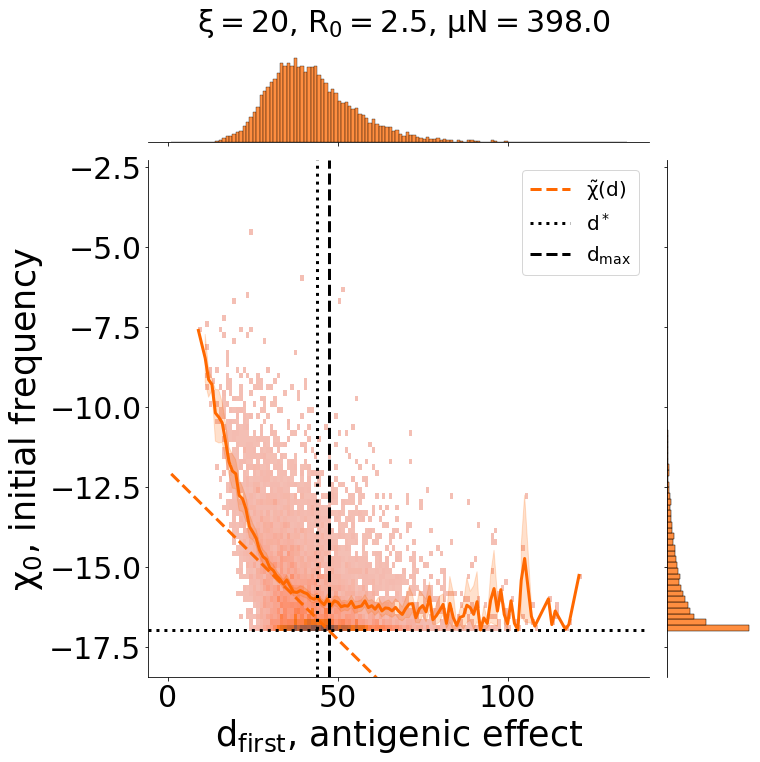

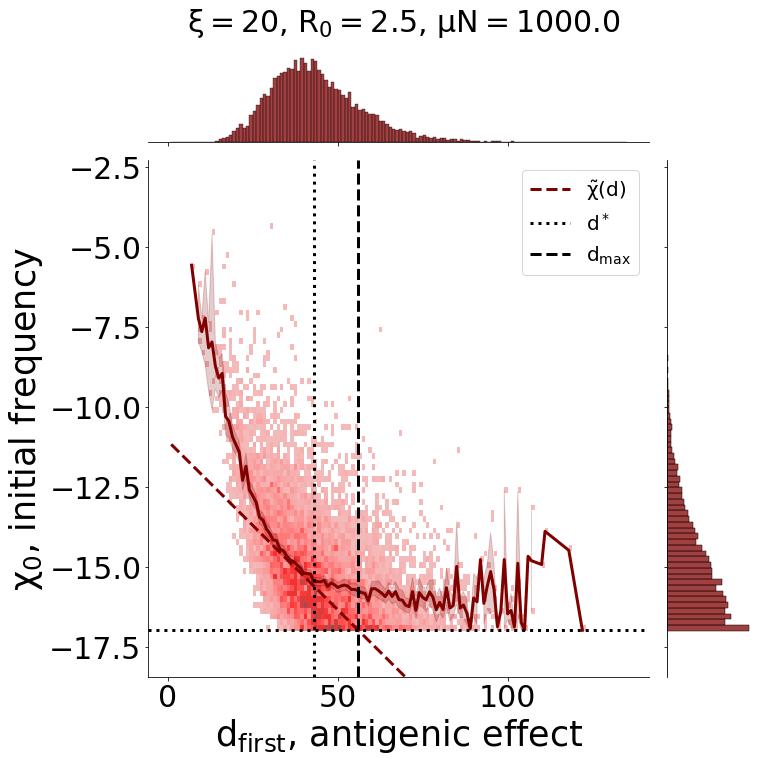

In [45]:
xi = 20
R0 = 2.5
colors_mu = funcs.color_dict(mu_s, plt.cm.jet)
for mu in mu_s:
    qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and muN=={np.round(mu*N)}')
    qfiltered['logchi_0']=  np.log(qfiltered['chi_0'])
    xmax = lambda d, p_alpha, R0, mu, N, xmin : (N*mu* np.log(R0)/R0*(1-p_alpha)**d*xmin)/(1-2*xmin+2*N*mu* np.log(R0)/R0*(1-p_alpha)**d*xmin) 
    xmax_d= np.array([xmax(d, p_alpha, R0, mu, N, funcs.x_min_luria_dellbruck(R0,N)) for d in ds])
    tp = funcs.t_peak(R0,N)
    xinf = funcs.x_inf(R0,0)
    txs_tilde = np.array([tp-np.log(xmax(d, p_alpha, R0, mu, N, funcs.x_min_luria_dellbruck(R0,N)))/((1-np.exp(-d/xi))*R0*(1-xinf)) for d in ds])
    dtx= np.gradient(txs_tilde)
    
    dstar = ds[np.argmin(np.abs(dtx[~np.isnan(dtx)]))]

    d_max_evt = -1/(np.log(1-p_alpha))*np.log(mu*N*np.log(R0)/R0)



    J = sns.jointplot(qfiltered, x='first_d', y='logchi_0',alpha=0.9, color = colors_mu[mu],kind='hist', bins = (ds, np.linspace(np.log(1/N),np.log(5e-1),100)), element="step",legend=False,height=10)
    sns.lineplot(data =qfiltered, alpha=1,x='first_d', y='logchi_0', ax= J.ax_joint ,color= colors_mu[mu])
    Nmup =  N*mu* np.log(R0)/R0
    chi_tilde = (Nmup * (1-p_alpha)**ds * funcs.x_min_luria_dellbruck(R0,N))/(1 + 2*(Nmup*(1-p_alpha)**ds -1)*funcs.x_min_luria_dellbruck(R0,N))
    J.ax_joint.plot(ds, np.log(chi_tilde) ,color=colors_mu[mu], linestyle='--', label = r'$\tilde{\chi}(d)$')
    J.ax_joint.axvline(dstar, color='black', linestyle=':', label = r'$d^*$')
    J.ax_joint.axvline(d_max_evt, color='black', linestyle='--', label = r'$d_\mathrm{max}$')
    J.ax_joint.set_ylim(bottom = np.log(1/N), top=np.log(1e-1))
    J.ax_joint.legend(fontsize=20)
    J.ax_joint.set_xlabel(r'$d_\mathrm{first}$, antigenic effect')
    J.ax_joint.set_ylabel(r'$\chi_0$, initial frequency')
    J.ax_joint.axhline(np.log(funcs.x_min_luria_dellbruck(R0,N)), color='black', linestyle=':', label = r'$\chi_\mathrm{min}$')
    J.fig.suptitle(fr'$\xi={xi:.0f}$, $R_0={R0}$, $\mu N={np.round(mu*N,0)}$',y= 1.05, fontsize=30)
    # plt.savefig( results_folder+f'/first_d_chi0_xi{xi}_R0{R0}_muN{np.round(mu*N,0)}.jpg', bbox_inches='tight')


In [54]:
d_evts_R0 = {}
d_opts_R0 = {}
for R0 in R0s:
    d_evts = []
    d_opts=  []
    for mu in mu_s:
        xmax = lambda d, p_alpha, R0, mu, N, xmin : (N*mu* np.log(R0)/R0*(1-p_alpha)**d*xmin)/(1-2*xmin+2*N*mu* np.log(R0)/R0*(1-p_alpha)**d*xmin) 
        xmax_d= np.array([xmax(d, p_alpha, R0, mu, N, funcs.x_min_luria_dellbruck(R0,N)) for d in ds])
        tp = funcs.t_peak(R0,N)
        xinf = funcs.x_inf(R0,0)
        txs_tilde = np.array([tp-np.log(xmax(d, p_alpha, R0, mu, N, funcs.x_min_luria_dellbruck(R0,N)))/((1-np.exp(-d/xi))*R0*(1-xinf)) for d in ds])
        dtx= np.gradient(txs_tilde)
        
        dstar = ds[np.argmin(np.abs(dtx[~np.isnan(dtx)]))]

        d_max_evt = -1/(np.log(1-p_alpha))*np.log(mu*N*np.log(R0)/(R0*(1-p_alpha)))

        d_opts.append(dstar)
        d_evts.append(d_max_evt)
    d_evts_R0[R0] = d_evts
    d_opts_R0[R0] = d_opts


In [50]:
from scipy import stats


mode = lambda m: stats.mode(m)[0][0]


In [51]:
colors_R0 = funcs.color_dict(R0s, plt.cm.inferno)

filtered_df['scaled_first_d'] = filtered_df['first_d']*filtered_df['p_alpha']

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


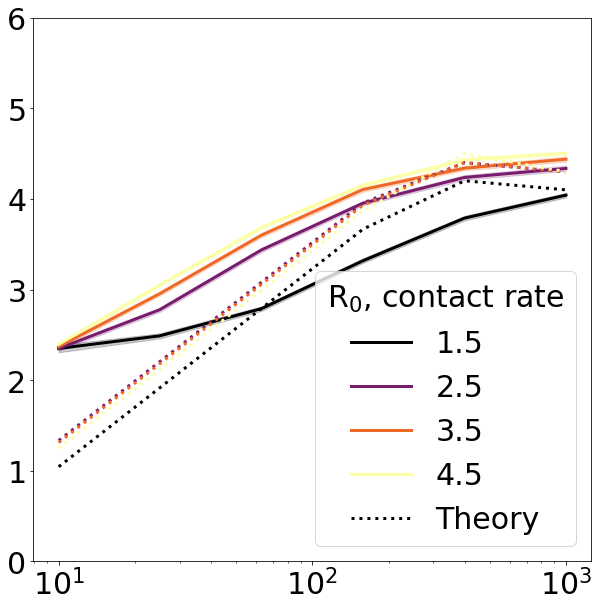

In [55]:
fig,ax= plt.subplots(figsize=(10,10))
# plt.plot(mu_s*N, d_opts, label = r'$d^*$',alpha=.5)
# plt.plot(mu_s*N, d_evts, label = r'$d_\mathrm{max}$',alpha=.5)
d_eff = np.minimum(d_opts, d_evts)
# plt.plot(mu_s*N, d_eff, label = r'$d_\mathrm{eff}$', color='black', linestyle='--')
sns.lineplot(data = filtered_df.query(f'xi=={xi}'), x='muN',
              y='scaled_first_d', ax=ax,alpha=1, hue='infection_rate',estimator =np.mean, legend=True, palette= colors_R0, )
for R0 in R0s:
    # plt.plot(mu_s*N, d_evts_R0[R0], label = r'$d_\mathrm{max}$',alpha=.5)
    # plt.plot(mu_s*N, d_opts_R0[R0], label = r'$d^*$',alpha=.5, color = colors_R0[R0])
    d_eff = np.minimum(d_opts_R0[R0], d_evts_R0[R0])
    plt.plot(mu_s*N, d_eff*p_alpha 
             ,linestyle=':',color = colors_R0[R0])
#lineplot of most common first_d
# sns.lineplot(data = filtered_df.query(f'infection_rate == {R0} and xi=={xi}'), x='muN', y='first_d', ax=ax,alpha=1, color='black', label = r'$d_\mathrm{first}$')

plt.ylim(0,6)

plt.xlabel(r'')
plt.ylabel(r'')
handles, labels = ax.get_legend_handles_labels()
handles+= [plt.Line2D([0], [0], color='black', linestyle=':', label = r'Theory')]
plt.legend(title=f'$R_0$, contact rate', handles=handles, fontsize=30, title_fontsize=30)
ax.set_xscale('log')
plt.savefig(results_folder + f'/first_d_xi_{xi}.pdf', bbox_inches='tight')


<AxesSubplot:xlabel='logchi_0', ylabel='first_d'>

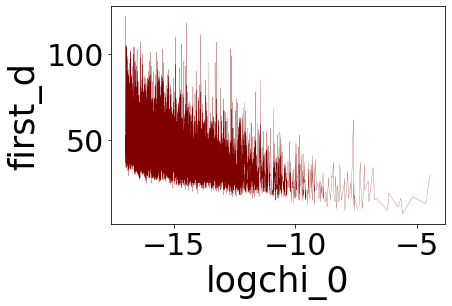

In [ ]:
sns.lineplot(data =qfiltered, alpha=1,y='first_d', x='logchi_0' ,color= colors_mu[mu],lw=.2)

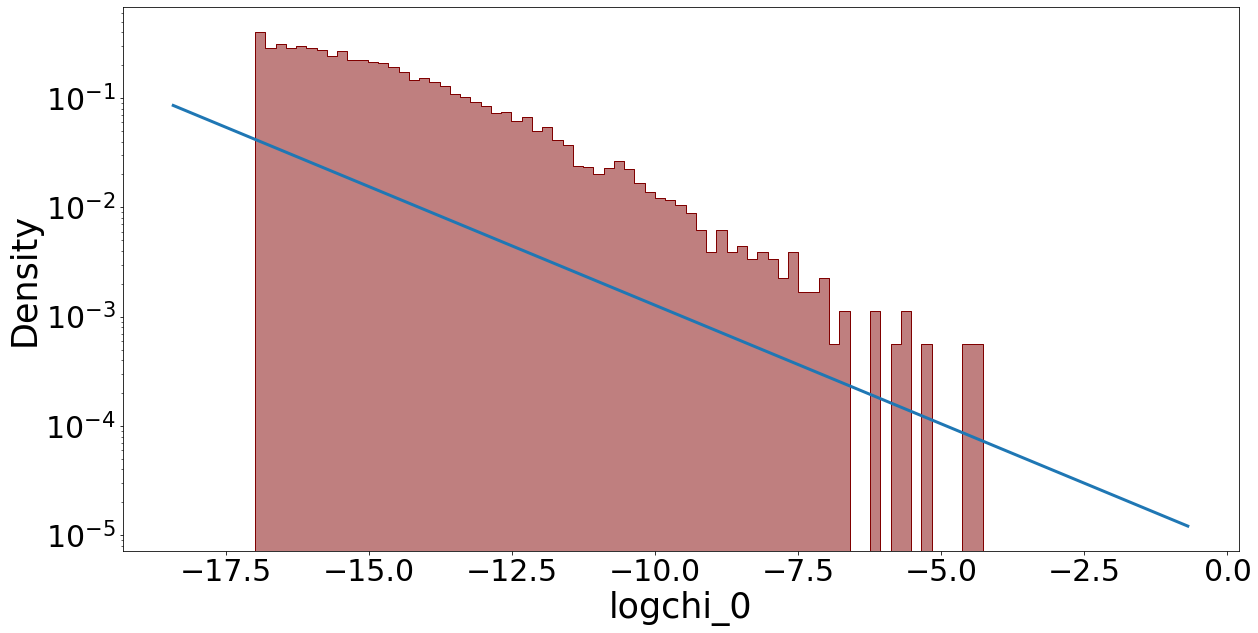

In [ ]:
fig,ax =plt.subplots(figsize=(20,10))
logx_bins = np.linspace(np.log(1/N),np.log(5e-1),100)
sns.histplot(qfiltered, x='logchi_0',alpha=0.5, bins= logx_bins, color = colors_mu[mu], element="step",legend=False,stat='density',common_norm=False)
ax.set_yscale('log')

exp_curve = np.exp(-0.5*logx_bins)
exp_curve = exp_curve/np.sum(exp_curve)
ax.plot(logx_bins, exp_curve)


(0.01, 165079680.94254258)

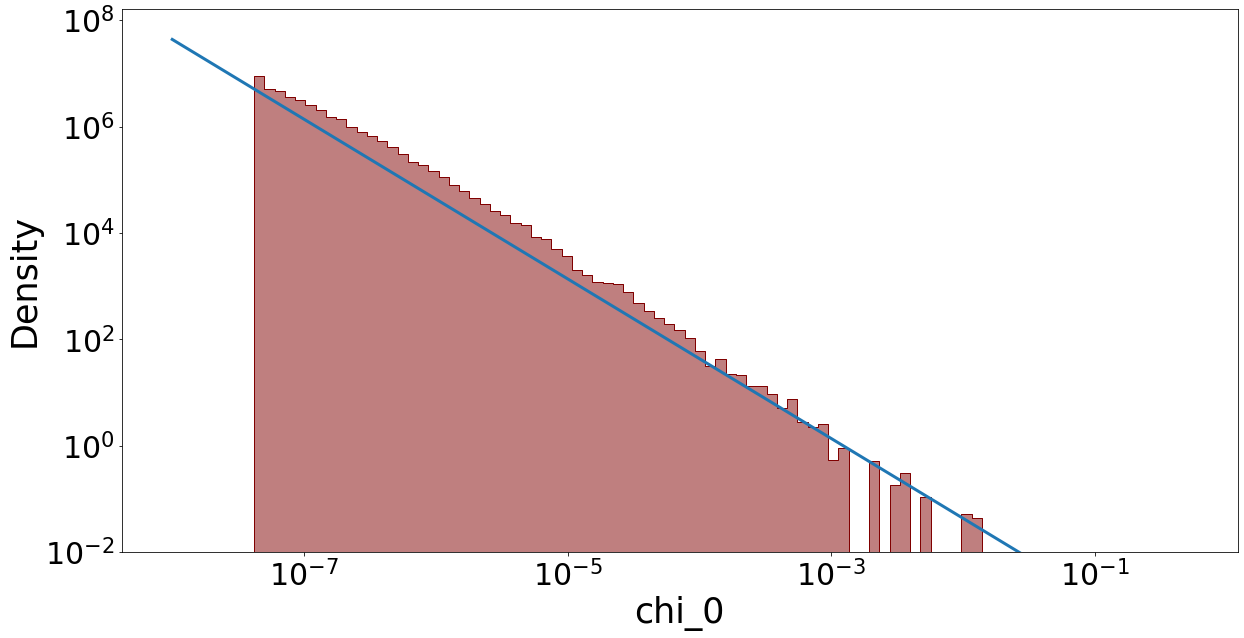

In [ ]:
fig,ax =plt.subplots(figsize=(20,10))
linx_bins = np.logspace(np.log10(1/N),np.log10(5e-1),100)
sns.histplot(qfiltered, x='chi_0',alpha=0.5, bins= linx_bins, color = colors_mu[mu], element="step",legend=False,stat='density',common_norm=False)
ax.set_yscale('log')
ax.set_xscale('log')

plaw = linx_bins**(-1.5)
dxs = np.diff(linx_bins)
plaw = plaw/np.sum(plaw[:-1]*dxs)
# plaw = plaw/np.sum(plaw*)
ax.plot(linx_bins, plaw)
ax.set_ylim(bottom=1e-2)
# exp_curve = np.exp(-0.5*logx_bins)
# exp_curve = exp_curve/np.sum(exp_curve)
# ax.plot(logx_bins, exp_curve)

In [ ]:
def interpolated_chi0(means_df, mu*N):
    means_df_ds = means_df.query(f'muN=={mu*N}')['first_d'].values
    means_df_chi0 = means_df.query(f'muN=={mu*N}')['chi0'].values

    return interp1d(means_df_ds, means_df_chi0)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


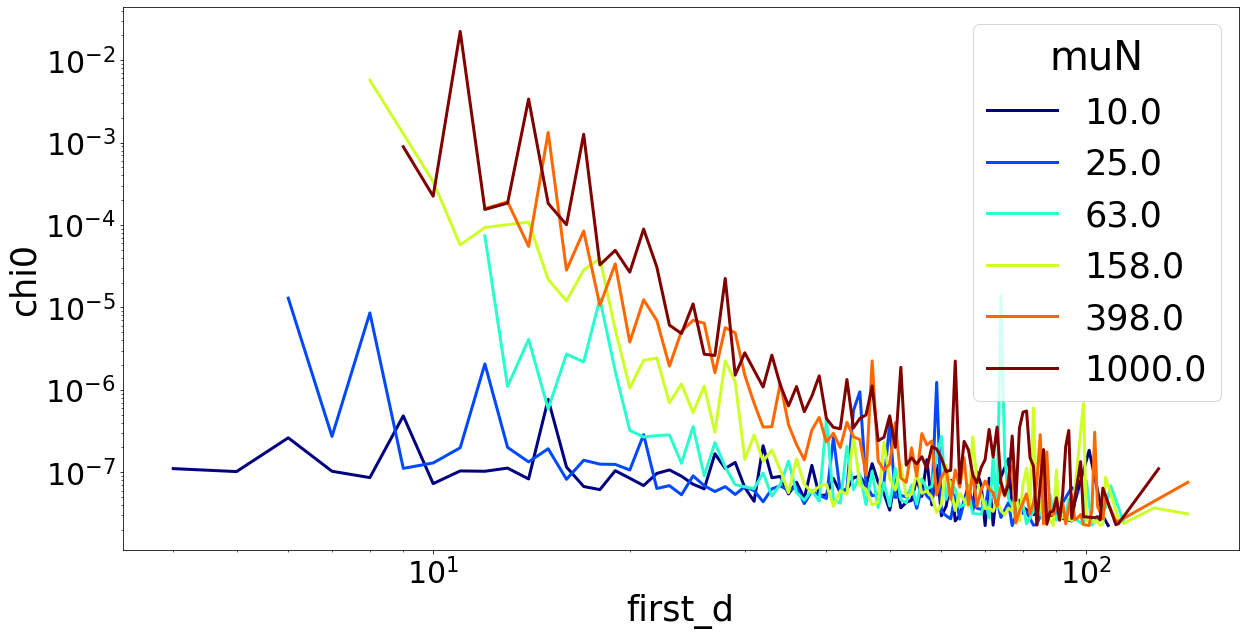

In [ ]:
#get dataframe of average chi_0 for each muN
mu = mu_s[-1]
R0=  R0s[-1]
xi = xi_s[0]
qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi}')
add_column_constant_frequency_intersection(qfiltered, R0, kappa, N)

means_df = qfiltered.groupby(['muN','first_d']).mean().reset_index()



fig,ax= plt.subplots(1,1,figsize=(20,10))
sns.lineplot(data =means_df,hue='muN',x='first_d', y='chi0',palette=plt.cm.jet,legend=legend, hue_norm=mpl.colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='first_d', ylabel='t_x-t_b'>

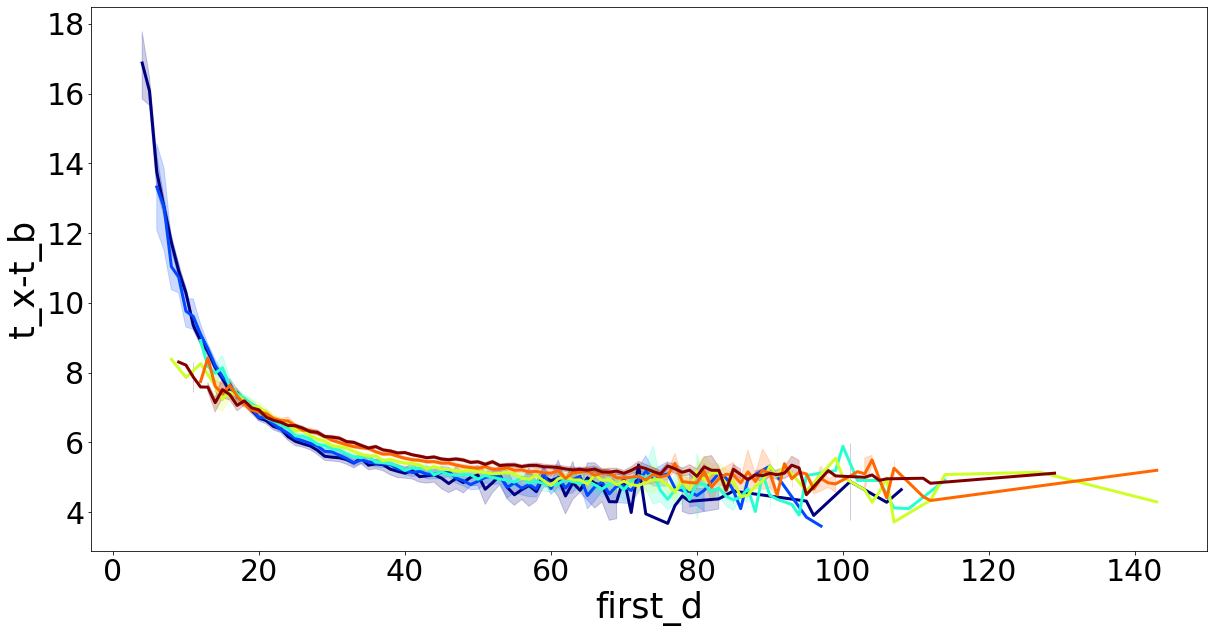

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,10))
means_df['predicted_tx'] = means_df.apply(lambda row: funcs.t_peak(R0,N)+np.log((1-row['chi0']*funcs.s_d_infinity(R0,row['first_d'],xi))/(row['chi0']*funcs.s_d_infinity(R0,row['first_d'],xi)))/funcs.s_d_infinity(R0,row['first_d'],xi), axis=1)
# sns.lineplot(data =means_df,hue='muN',x='first_d', y='predicted_tx',palette=plt.cm.jet,legend=legend, hue_norm=mpl.colors.LogNorm())
qfiltered['t_x-t_b'] = qfiltered['t_x']-qfiltered['first_tb']
sns.lineplot(data =qfiltered,hue='muN',x='first_d', y='t_x-t_b',palette=plt.cm.jet,legend=False, hue_norm=mpl.colors.LogNorm())
# ax.set_yscale('log')
# ax.set_xscale('log')

(-0.026944444444444438, 6.065833333333333, 0.001, 1.0)

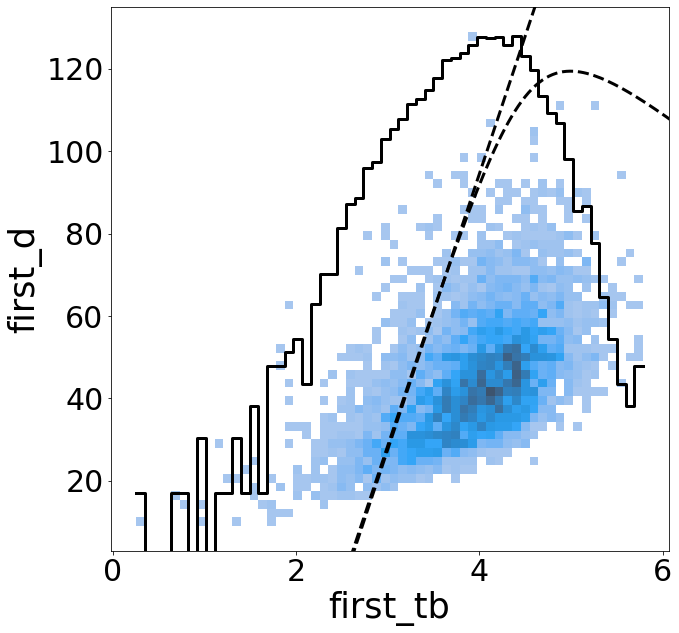

In [ ]:

mu = mu_s[-1]
R0=  R0s[-1]
xi = xi_s[0]
qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi}')
fig,ax= plt.subplots(1,1,figsize=(10,10))
sns.histplot(qfiltered.query(f'muN=={np.round(mu*N)}'),x='first_tb',
             y='first_d')


x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,0)).T

tax  = ax.twinx()
xlim = ax.get_xlim()
tax.plot(ts_det, y,color='k', linestyle='--')
tax.plot(ts_det, y[0]*np.exp((R0-1)*ts_det),color='k', linestyle='--')
sns.histplot(qfiltered.query(f'muN=={np.round(mu*N)}'),x='first_tb', ax= tax, stat='density', element="step", fill=False, color='k', linewidth=3)
tax.set_xlim(xlim)
tax.set_yscale('log')
tax.set_ylim(1e-3,1)
tax.axis('off')

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


(-2.0, 2.5)

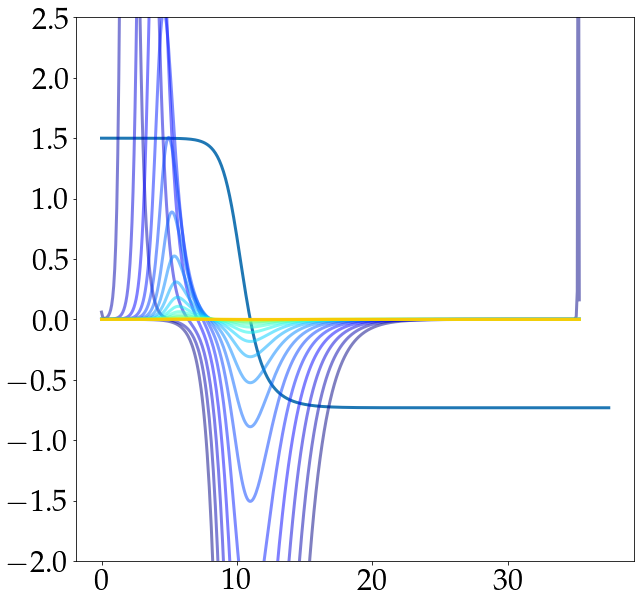

In [ ]:
colors_d = {d:plt.cm.jet(d/filtered_df['first_d'].max()) for d in ds}


plt.figure(figsize=(10,10))
# plt.plot(ts_det, y_func(ts_det))
# plt.plot(ts_det, y_func(ts_det)**2, color= 'black',linestyle='--')
plt.plot(ts_det, R0*x_func(ts_det)-1)
for d in ds[::5]:
    plt.plot(ts_det, mu*N*(yx(ts_det, d,R0,xi,N )-y_func(ts_det))*(1-p_alpha)**d,color = colors_d[d],alpha=.5)

    # plt.plot(ts_det, y_func(ts_det) * txx(ts_det,d,R0,xi,N),color = colors_d[d],alpha=.5,linestyle='--')
# plt.plot(ts_det, zx(ts_det, 1,R0,xi,N ))
# plt.yscale('log')
plt.ylim(-2,R0)

In [ ]:
#deactivate warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
all_params = list(funcs.product(R0s,mu_s,xi_s))
#if pdata_df already exists, load it. Otherwise, create it
try:
    pdata_df = pd.read_feather(f'{results_folder}/pdata_df.feather')
except FileNotFoundError:
    pdata_df = pd.DataFrame()
    for x in tqdm(all_params):
        R0,mu,xi = x
        qdata = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and mutation_rate=={mu}')
        ds = np.arange(1,qdata['first_d'].max()+1)
        for d in ds:
            pdata_df = pdata_df.append({'R0':R0,'xi':xi,'mu':mu,'d':d,'pdata':p_d_func(d,R0,p_alpha,xi,mu,N)},ignore_index=True)
    pdata_df.to_feather(f'{results_folder}/pdata_df.feather')

  0%|          | 0/48 [00:00<?, ?it/s]/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 48/48 [29:21<00:00, 36.69s/it]


In [ ]:
all_params

[(1.5, 1e-08, 20.0),
 (1.5, 1e-08, 50.0),
 (1.5, 1e-07, 20.0),
 (1.5, 1e-07, 50.0),
 (1.5, 1e-06, 20.0),
 (1.5, 1e-06, 50.0),
 (2.5, 1e-08, 20.0),
 (2.5, 1e-08, 50.0),
 (2.5, 1e-07, 20.0),
 (2.5, 1e-07, 50.0),
 (2.5, 1e-06, 20.0),
 (2.5, 1e-06, 50.0),
 (3.5, 1e-08, 20.0),
 (3.5, 1e-08, 50.0),
 (3.5, 1e-07, 20.0),
 (3.5, 1e-07, 50.0),
 (3.5, 1e-06, 20.0),
 (3.5, 1e-06, 50.0),
 (4.5, 1e-08, 20.0),
 (4.5, 1e-08, 50.0),
 (4.5, 1e-07, 20.0),
 (4.5, 1e-07, 50.0),
 (4.5, 1e-06, 20.0),
 (4.5, 1e-06, 50.0)]

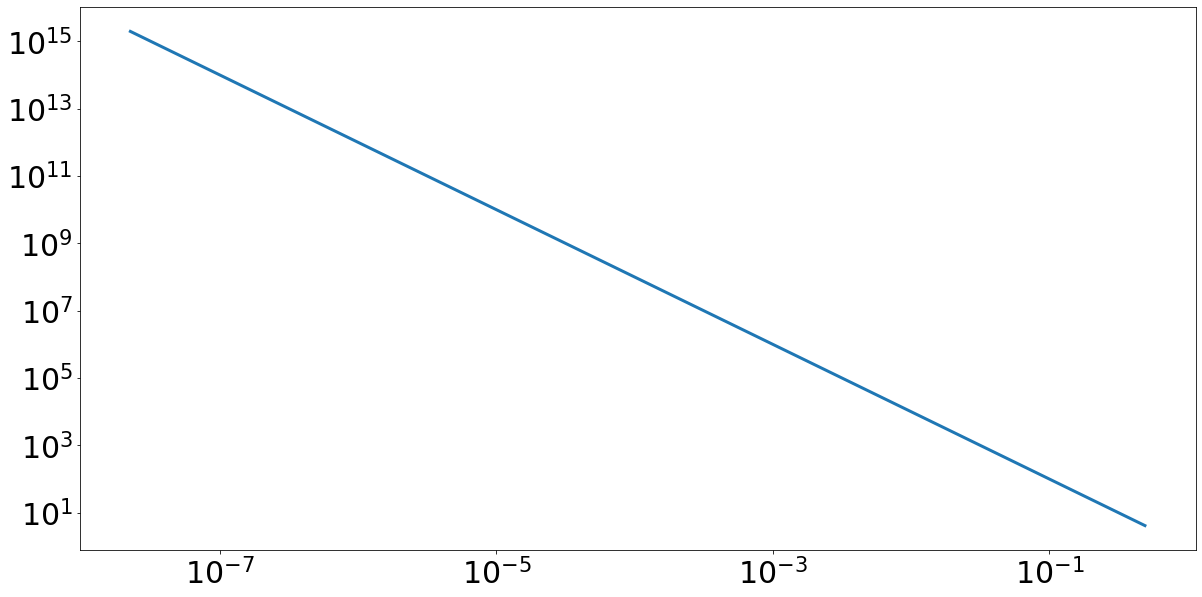

In [ ]:
chi_s = np.logspace(np.log10(xmin), np.log10(.5), 1000)
dchi_s = np.diff(chi_s)
chi_s = chi_s[:-1]

fig,ax =plt.subplots(figsize=(20,10))
plt.plot(chi_s, chi_s**(-2))
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
#translate to python with x0-> chi_s: 1 - ((1 - E**(-R0))*(1 - p)**(-1 - (d*Log(2))/Log(x0))*R0*(-2 + p*(2 + (p*x0**((1 + (d*Log(2))/Log(x0))/d)*((-1 + p)*(-1 - (d*Log(2))/Log(x0)) - (d*x0**(1/d)*Log(2))/Log(x0)))/(-1 + p + x0**(1/d))**2 + (2*d*Log(2))/Log(x0))))/(p*\[Xi])
totest=

1.0170756442174358

In [ ]:
#translate to python with x0-> chi_s, Log-> np.log, E-> np.e, p->p_alpha, d->d , \[Xi]->xi  :  1 - (2*R0*(-1 + x0**(1/d))*((-1 + p)*(-1 + p + E**(1/\[Xi])*(1 - 2**(d/(\[Xi]*Log(x0)))*p)) + E**(1/\[Xi])*(-1 + E**(1/\[Xi]) + p - 2**(d/(\[Xi]*Log(x0)))*p)*x0**(1/d))*xmin*zinf)/((1 - p)**((d*Log(2))/Log(x0))*(-1 + E**(1/\[Xi]) + p)*(-1 + p + x0**(1/d))*(-1 + p + E**(1/\[Xi])*x0**(1/d))*(-1 + 2*xmin))
totest= 1- (2*R0*(-1 + chi_s**(1/d))*((-1 + p_alpha)*(-1 + p_alpha + np.e**(1/xi)*(1 - 2**(d/(xi*np.log(chi_s)))*p_alpha)) + np.e**(1/xi)*(-1 + np.e**(1/xi) + p_alpha - 2**(d/(xi*np.log(chi_s)))*p_alpha)*chi_s**(1/d))*xmin*zinf)/((1 - p_alpha)**((d*np.log(2))/np.log(chi_s))*(-1 + np.e**(1/xi) + p_alpha)*(-1 + p_alpha + chi_s**(1/d))*(-1 + p_alpha + np.e**(1/xi)*chi_s**(1/d))*(-1 + 2*xmin))


1.29556803273698e-06
1.6047134925669442e-06
1.9457748341578328e-06
2.4044639570548365e-06
2.9595089836142775e-06
3.5852934606307217e-06
4.427366447084643e-06
5.441948024263633e-06
6.582907871617104e-06
8.08804587386145e-06


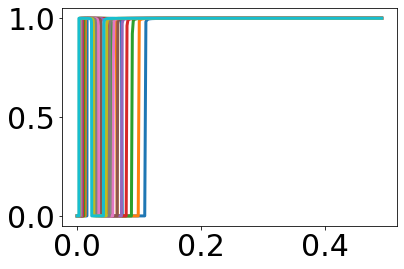

In [ ]:


xmin = funcs.x_min_luria_dellbruck(R0,N)

z_inf = 1- funcs.x_inf(R0,0)


Z = 1/xmin - 2
for d in ds[20:30]:
    exps = d*np.log(0.5)/np.log(chi_s)
    #totest= 1- ((1 - np.exp(-R0))*(1 - p_alpha)**(-1 - (d*np.log(2))/np.log(chi_s))*R0*(-2 + p_alpha*(2 + (p_alpha*chi_s**((1 + (d*np.log(2))/np.log(chi_s))/d)*((-1 + p_alpha)*(-1 - (d*np.log(2))/np.log(chi_s)) - (d*chi_s**(1/d)*np.log(2))/np.log(chi_s)))/(-1 + p_alpha + chi_s**(1/d))**2 + (2*d*np.log(2))/np.log(chi_s))))/(p_alpha*xi)
    totest = 1- (2*R0*(-1 + chi_s**(1/d))*((-1 + p_alpha)*(-1 + p_alpha + np.e**(1/xi)*(1 - 2**(d/(xi*np.log(chi_s)))*p_alpha)) + np.e**(1/xi)*(-1 + np.e**(1/xi) + p_alpha - 2**(d/(xi*np.log(chi_s)))*p_alpha)*chi_s**(1/d))*xmin*z_inf)/((1 - p_alpha)**((d*np.log(2))/np.log(chi_s))*(-1 + np.e**(1/xi) + p_alpha)*(-1 + p_alpha + chi_s**(1/d))*(-1 + p_alpha + np.e**(1/xi)*chi_s**(1/d))*(-1 + 2*xmin))
    totest= np.maximum(totest,0)*(totest<1)
    plt.plot(chi_s, totest**(N*mu) )
    print(np.sum(totest* chi_s**(-2)*dchi_s)/Z)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
def p_d_binomial(d, R0, p_alpha, xi, mu, N ):
    xmin = funcs.x_min_luria_dellbruck(R0,N)
    chi_s = np.logspace(np.log10(xmin), np.log10(.5), 1000)
    # chi_s = np.linspace(xmin, .5, 1000)
    dchi_s = np.diff(chi_s)
    chi_s = chi_s[:-1]
    exps = d*np.log(0.5)/np.log(chi_s)
    Z = 1/xmin - 2

    z_inf= 1-funcs.x_inf(R0,0)
    N_est= N*mu

    #totest= 1 + (R0-1)/(R0*Z)*(2*(-1 + chi_s**(1/d)))/((1 - p_alpha)**((d*2*np.log(2))/np.log(chi_s))*(-1 + p_alpha + chi_s**(1/d)))
    #totest= 1- ((z_inf) *(1 - p_alpha)**(-1 - (d*np.log(2))/np.log(chi_s))*R0*(-2 + p_alpha*(2 + (p_alpha*chi_s**((1 + (d*np.log(2))/np.log(chi_s))/d)*((-1 + p_alpha)*(-1 - (d*np.log(2))/np.log(chi_s)) - (d*chi_s**(1/d)*np.log(2))/np.log(chi_s)))/(-1 + p_alpha + chi_s**(1/d))**2 + (2*d*np.log(2))/np.log(chi_s))))/(p_alpha*xi)
    totest=  1- (2*R0*(-1 + chi_s**(1/d))*((-1 + p_alpha)*(-1 + p_alpha + np.e**(1/xi)*(1 - 2**(d/(xi*np.log(chi_s)))*p_alpha)) + np.e**(1/xi)*(-1 + np.e**(1/xi) + p_alpha - 2**(d/(xi*np.log(chi_s)))*p_alpha)*chi_s**(1/d))*xmin*z_inf)/((1 - p_alpha)**((d*np.log(2))/np.log(chi_s))*(-1 + np.e**(1/xi) + p_alpha)*(-1 + p_alpha + chi_s**(1/d))*(-1 + p_alpha + np.e**(1/xi)*chi_s**(1/d))*(-1 + 2*xmin))
    totest= np.maximum(totest,0)*(totest<1)

    to_integrate = np.power(chi_s,-2) *np.power(totest,N_est)
    

    p_d = funcs.rho_d(d,p_alpha) * np.sum(to_integrate*dchi_s)/Z
    return p_d
pdata_binomial_df = pd.DataFrame()
all_params = list(funcs.product(R0s,mu_s,xi_s))
for x in tqdm(all_params):
    R0,mu,xi = x
    qdata = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and mutation_rate=={mu}')
    ds = np.arange(1,qdata['first_d'].max()+1)
    for d in ds:
        pdata_binomial_df = pdata_binomial_df.append({'R0':R0,'xi':xi,'mu':mu,'d':d,'pdata':p_d_binomial(d,R0,p_alpha,xi,mu,N)},ignore_index=True)
    
#normalize the probabilities
pdata_binomial_df['pdata'] = pdata_binomial_df.groupby(['R0','xi','mu'])['pdata'].transform(lambda x: x/x.sum())



100%|██████████| 48/48 [00:15<00:00,  3.14it/s]


<AxesSubplot:xlabel='d', ylabel='pdata'>

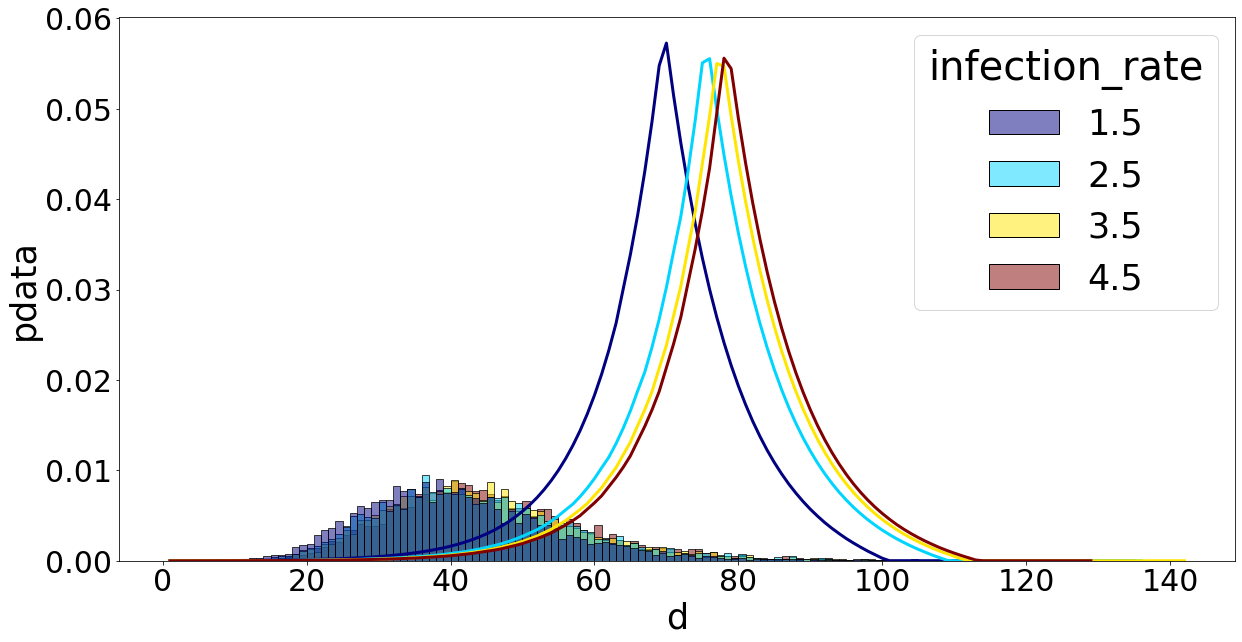

In [ ]:
fig,ax= plt.subplots(figsize=(20,10))
sns.lineplot(data=pdata_binomial_df.query(f'mu=={mu_s[-1]} and xi=={xi_s[0]}'),x='d',y='pdata',hue='R0',palette=colors_R0)
sns.histplot(data=filtered_df.query(f'mutation_rate=={mu_s[-1]} and xi=={xi_s[0]}'),x='first_d',hue='infection_rate', bins =ds,palette=colors_R0,stat='probability',alpha=0.5,ax=ax)

In [ ]:
#get the average d for each parameter set of pdata_binomial_df

avg_d_binomial_df = pdata_binomial_df.groupby(['R0','xi','mu']).apply(lambda x: np.sum(x['d']*x['pdata']))
avg_d_binomial_df = avg_d_binomial_df.reset_index()
avg_d_binomial_df.columns = ['R0','xi','mu','avg_d']
avg_d_binomial_df['muN'] = np.round(avg_d_binomial_df['mu']*N)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


<AxesSubplot:xlabel='muN', ylabel='avg_d'>

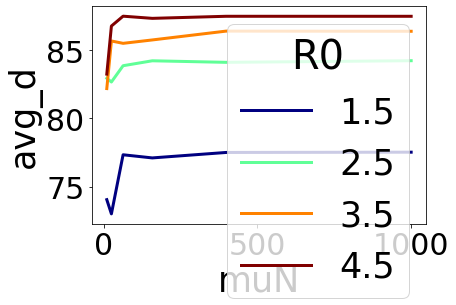

In [ ]:
sns.lineplot(data =avg_d_binomial_df.query(f'xi=={xi}'), hue='R0',y='avg_d', x='muN',palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


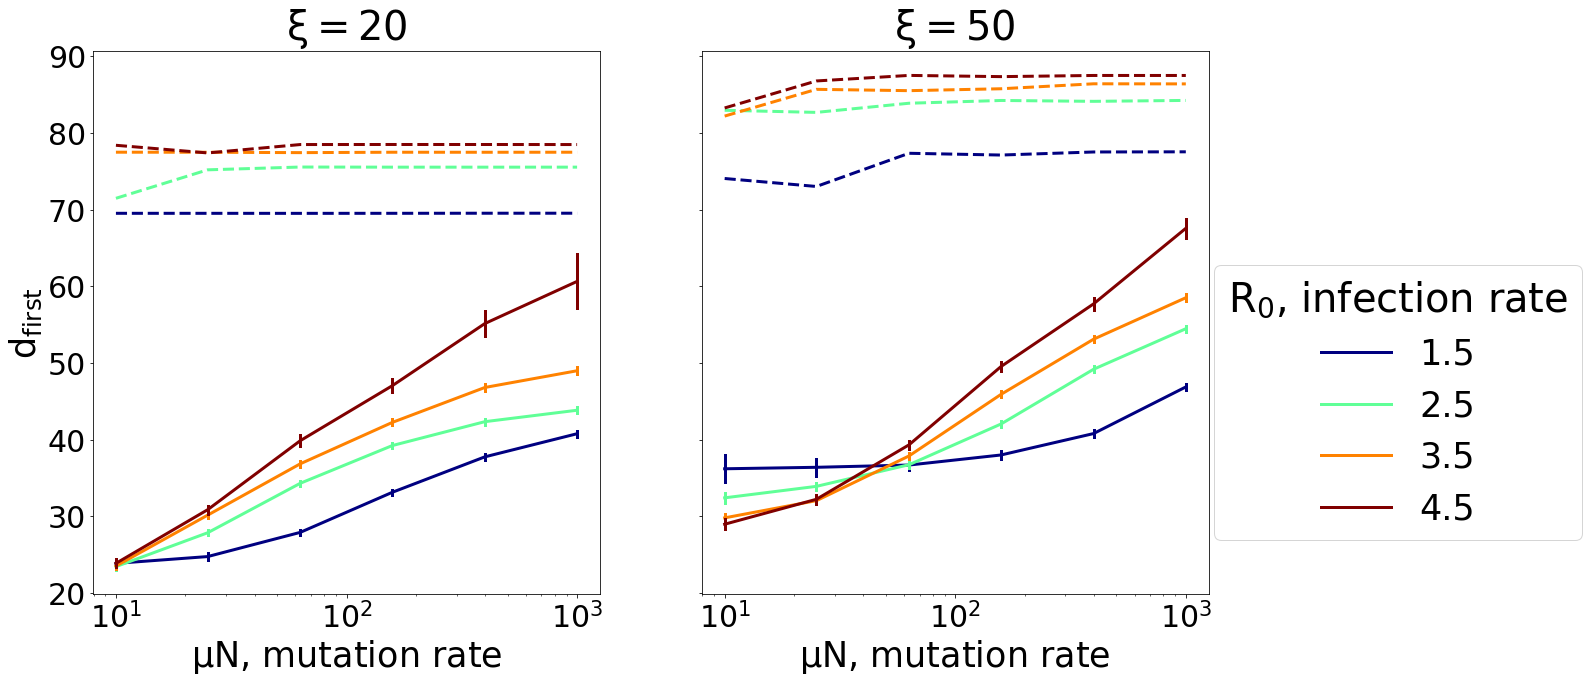

In [ ]:
colors_R0 = funcs.color_dict(R0s, plt.cm.jet)

#create a dataframe for fits 
fit_df = pd.DataFrame(columns=['xi','R0','a','b'])

fig,ax =plt.subplots(1,len(xi_s), figsize=(len(xi_s)*10,10),sharey=True)
for ix,xi in enumerate(xi_s):
    if ix == len(xi_s)-1:
        legend = 'auto'
    else:
        legend=  None
    qfiltered = filtered_df.query(f'xi=={xi} and first_tb>{funcs.t_peak(R0,N)}')
    sns.lineplot(data =qfiltered,hue='infection_rate',y='first_d', x='muN', ax= ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=legend, hue_norm=mpl.colors.LogNorm())

    sns.lineplot(data =avg_d_binomial_df.query(f'xi=={xi}'), hue='R0',y='avg_d', x='muN', ax=ax[ix],palette=plt.cm.jet, err_style="bars", errorbar=("se", 2),legend=False, hue_norm=mpl.colors.LogNorm(), linestyle='--')
    ax[ix].set_title(fr'$\xi={xi:.0f}$', fontsize=40)
    ax[ix].set_xscale('log')
for a in ax:
    
    a.set_xlabel(r'$\mu N$, mutation rate')

    a.set_ylabel(r'$d_{\mathrm{first}}$')
    
ax[-1].legend(title=r'$R_0$, infection rate',loc=(1.01,.1),title_fontsize=40)

In [ ]:
#if pdata_alt_df already exists, load it. Otherwise, create it
try:
    pdata_alt_df = pd.read_feather(f'{results_folder}/pdata_alt_df.feather')
except FileNotFoundError:
    pdata_alt_df = pd.DataFrame()
    for x in tqdm(all_params):
        R0,mu,xi = x
        qdata = filtered_df.query(f'infection_rate == {R0} and xi=={xi} and mutation_rate=={mu}')
        ds = np.arange(1,qdata['first_d'].max()+1)
        for d in ds:
            pdata_alt_df = pdata_alt_df.append({'R0':R0,'xi':xi,'mu':mu,'d':d,'pdata':p_d_func_alt(d,R0,p_alpha,xi,mu,N)},ignore_index=True)
    pdata_alt_df.to_feather(f'{results_folder}/pdata_alt_df.feather')

100%|██████████| 48/48 [1:03:03<00:00, 78.82s/it] 


In [ ]:
pdata_df['muN'] = pdata_df['mu']*N
pdata_alt_df['muN'] = pdata_alt_df['mu']*N

In [ ]:
# for every R0,xi,mu, normalize pdata_df such that sum(pdata) = 1
for x in tqdm(funcs.product(R0s,mu_s,xi_s)):
    R0,mu,xi = x
    qdata = pdata_df.query(f'R0 == {R0} and xi=={xi} and mu=={mu}')
    pdata_df.loc[qdata.index,'pdata'] = qdata['pdata']/qdata['pdata'].sum()

24it [00:00, 95.37it/s] 


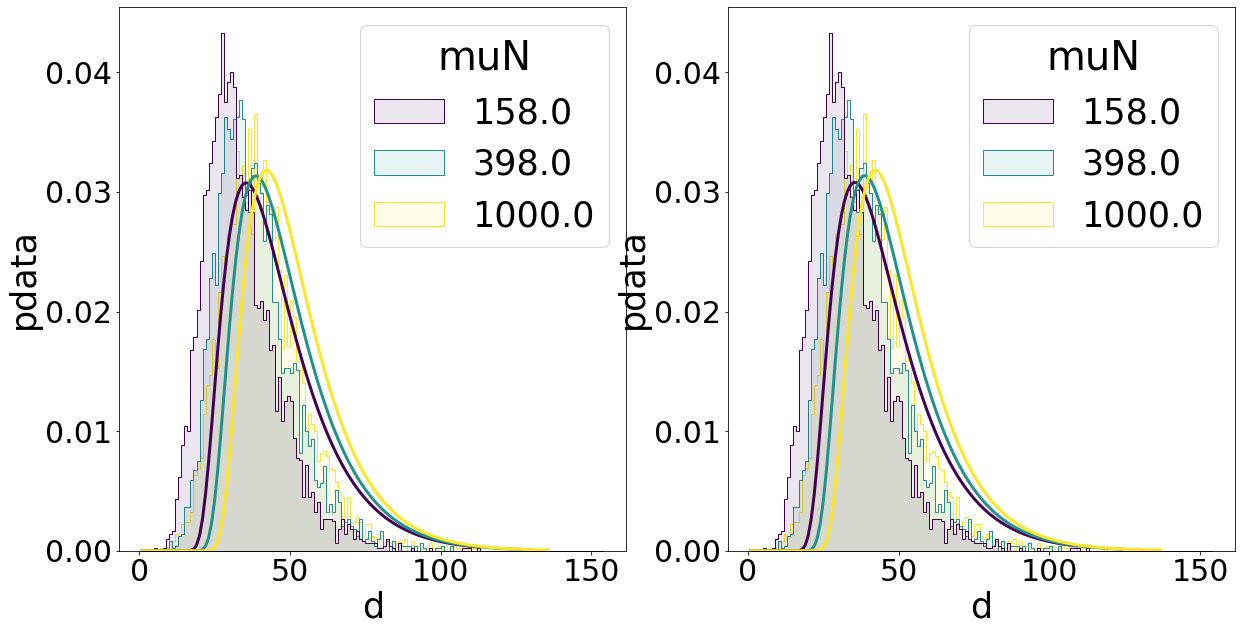

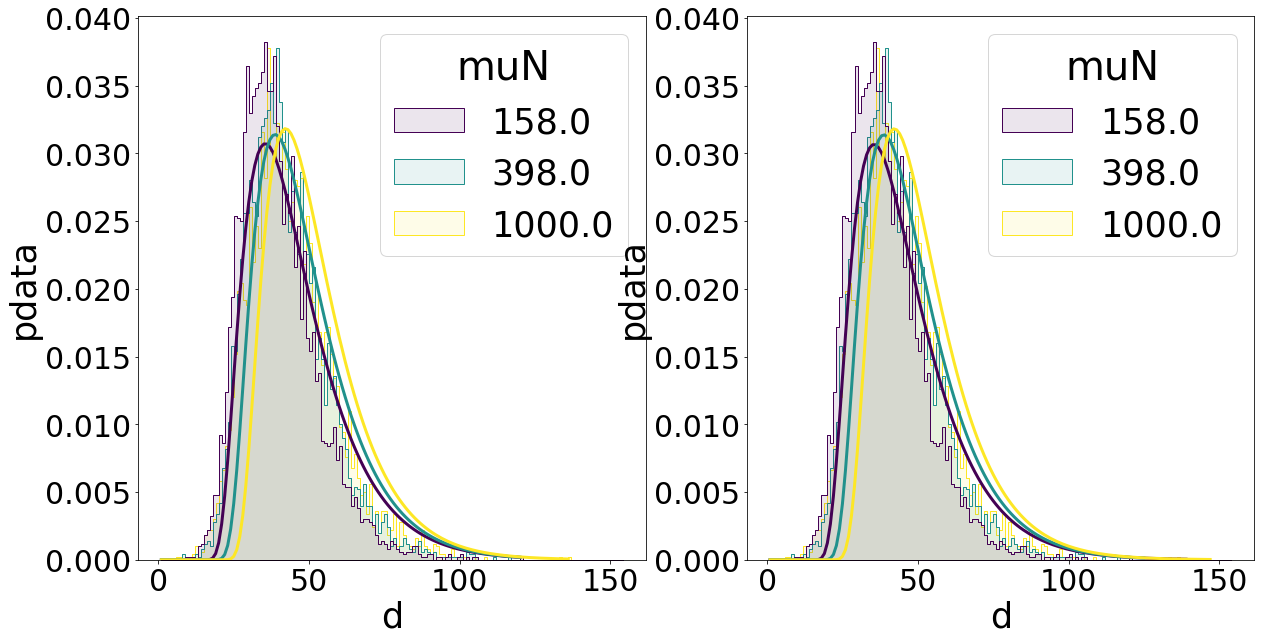

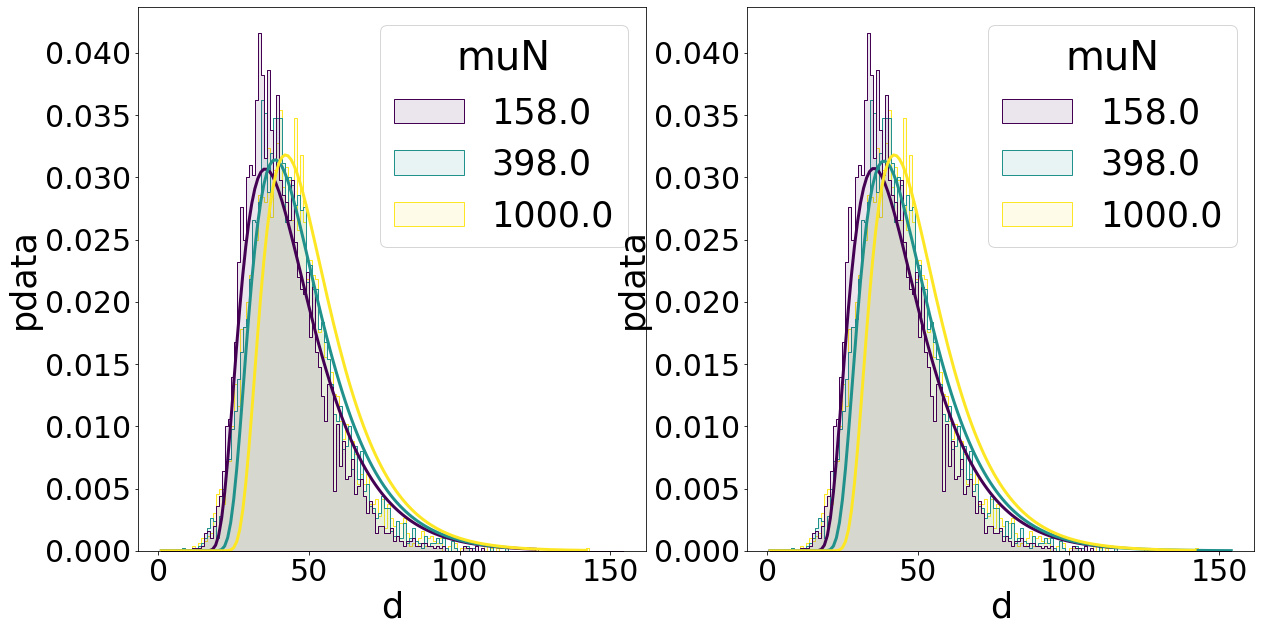

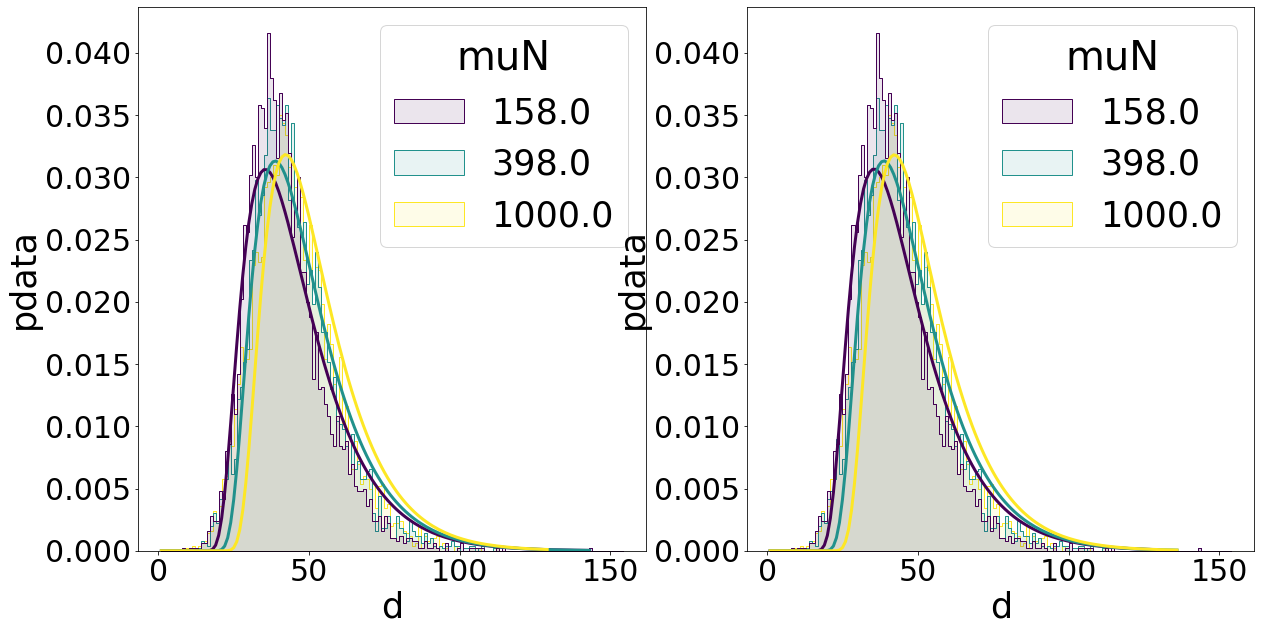

In [ ]:
pdata_binomial_df['muN'] = pdata_binomial_df['mu']*N
for R0 in R0s:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    ds = np.arange(1,filtered_df['first_d'].max()+1)
    for ix,xi in enumerate(xi_s):
        qpdata = pdata_binomial_df.query(f'R0=={R0} and xi=={xi} and muN>100')
        # qpdata_alt = pdata_alt_df.query(f'R0=={R0} and xi=={xi}')
        qfiltered = filtered_df.query(f'infection_rate == {R0} and xi=={xi_s[0]} and muN>100')
        sns.lineplot(qpdata,x='d',y='pdata',hue='muN',ax= ax[ix],palette='viridis',hue_norm=mpl.colors.LogNorm())
        sns.histplot(qfiltered, x='first_d',stat='probability',bins=ds,ax=ax[ix],alpha=0.1, hue='muN',palette='viridis',common_norm=False,hue_norm=mpl.colors.LogNorm(), element="step")

In [ ]:
d=10
vv=  funcs.rho_d(d,p_alpha)*mu*N* y* np.exp(-mu*N*zx(ts_det, d,R0,xi,N )*(1-p_alpha)**d)

dt*np.sum(vv[~np.isnan(vv)])

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


6.343371166151465e-06

In [ ]:
color_mus = {mu:plt.cm.jet(mu/mu_s.max()) for mu in mu_s}

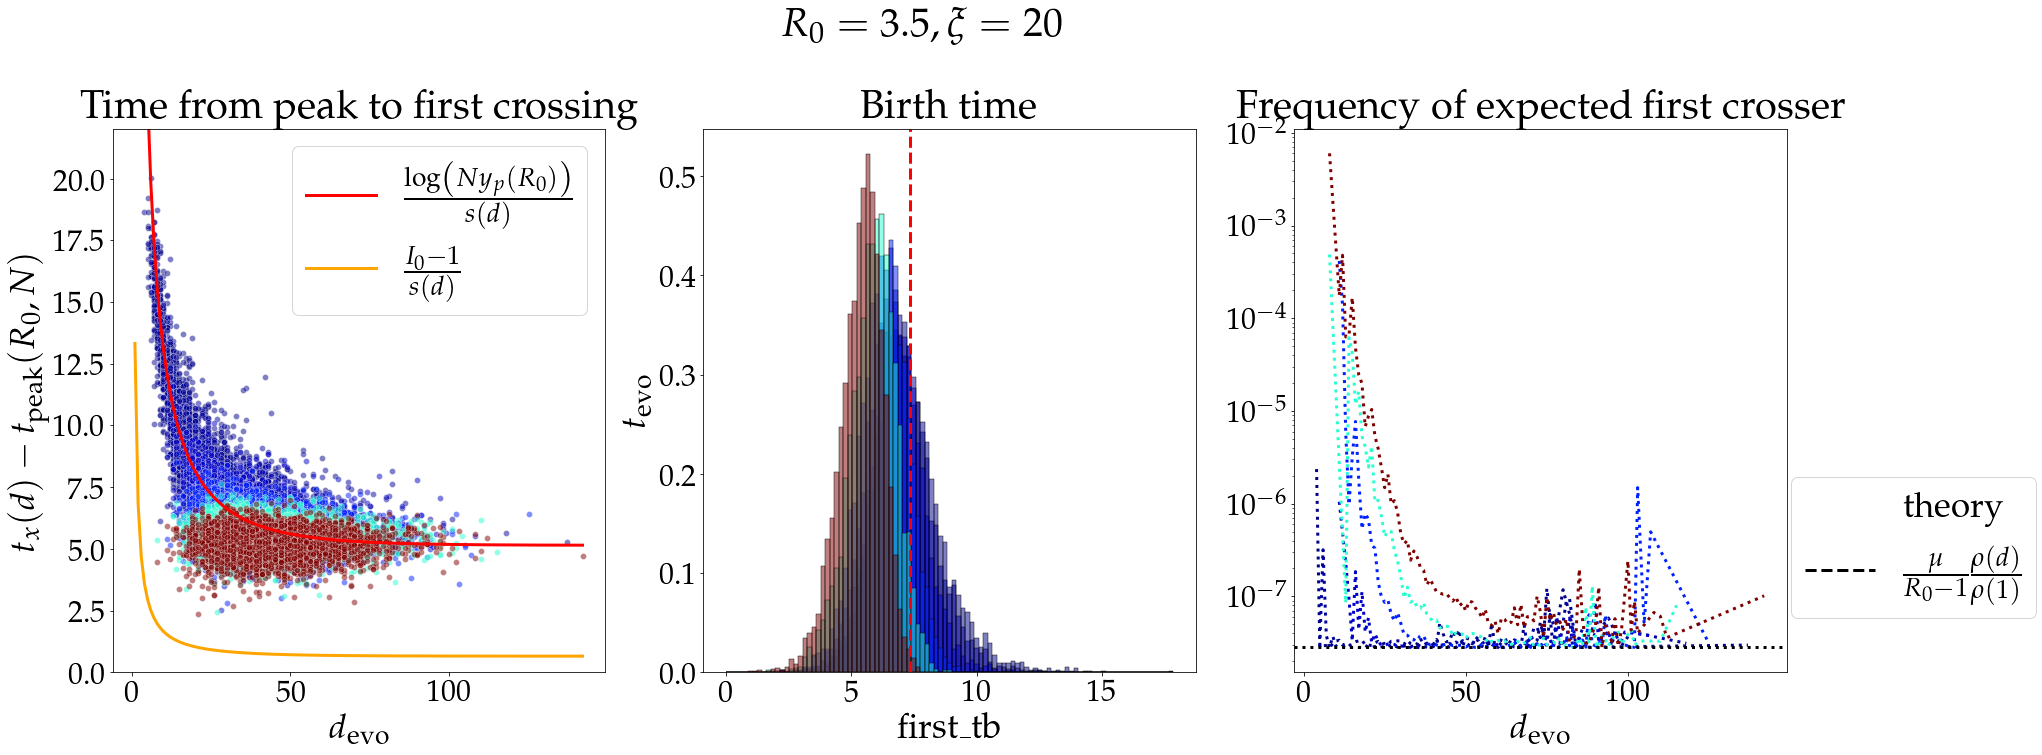

In [ ]:
#for a given R0, mu and xi do the 2d histogram of tx-tpeak and first_d
I0=10
R0 = 3.5
mu = mu_s[-1]
xi = xi_s[0]

T = funcs.T_ext_deterministic(R0,0,N)
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,0)).T

y_func = interp1d(ts_det,y)
N = datadf['N'].unique()[0]

first_t_bins = np.linspace(0,np.max(filtered_df.query(f'infection_rate == {R0} and xi=={xi}'))['first_tb'],100)
ds = np.arange(1,filtered_df.query(f'infection_rate == {R0} and xi=={xi}')['first_d'].max()+1)
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].plot(ds,np.log(N*funcs.y_peak(R0))/funcs.s_d_infinity(R0,ds,xi,0),color='red', label =r'$\frac{\log \left( N  y_p(R_0)\right)}{s(d)}$')
ax[0].plot(ds,np.log(I0-1)/funcs.s_d_infinity(R0,ds,xi,0),color='orange',label =r'$\frac{I_0-1}{s(d)}$')
for mu in mu_s:
    qdata = filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')
    sns.scatterplot(data=qdata,y='t_x-t_peak',x='first_d',ax=ax[0],color= color_mus[mu],alpha=.5)

    ds = np.arange(1,qdata['first_d'].max())
    ylim = ax[0].get_ylim()
    I0 = 10
    
    ax[0].set_ylim(top=ylim[1],bottom=0)

    sns.histplot(qdata,x='first_tb',ax=ax[1],stat='density',bins=first_t_bins,alpha=.5,color=color_mus[mu])
    # sns.histplot(qdata,x='first_tb',ax=ax[1],hue='first_d',bins=20,stat='density',alpha=.5)
    

    ds_hist= np.array(sorted(qdata['first_d'].unique()))
    #get the average tb for each d
    avg_tb= qdata.groupby('first_d')['first_tb'].mean()
    
    x_tb=  1/(I0*np.exp(avg_tb*(R0-1)))


    # ax[2].plot(ds_hist,x_tb,color = color_mus[mu],label=fr'$\mu N={np.round(mu*N):.0e}$',alpha=.5)
    
    # ax[2].plot(ds_hist, mu/(R0-1) * funcs.rho_d(ds_hist,p_alpha)/funcs.rho_d(1,p_alpha) ,color=color_mus[mu],linestyle='--')
    ax[2].plot(ds_hist, 1/(N*y_func(avg_tb)) ,color=color_mus[mu],linestyle=':')

    

ax[1].axvline(funcs.t_peaks(R0,N),color='red',linestyle='--')
ax[0].set_title('Time from peak to first crossing')
ax[0].set_ylabel(r'$t_x(d)-t_\mathrm{peak}(R_0,N)$')
ax[0].set_xlabel(r'$d_{\mathrm{evo}}$')
ax[1].set_title('Birth time')
ax[1].set_ylabel(r'$t_\mathrm{evo}$')
ax[2].set_yscale('log')
ax[2].set_title('Frequency of expected first crosser')
ax[2].set_xlabel(r'$d_{\mathrm{evo}}$')
ax[2].axhline(1/(N*funcs.y_peak(R0)),color='black',linestyle=':')
handles, labels = ax[2].get_legend_handles_labels()
handles +=[ Line2D([0], [0], color='black', linestyle=''),Line2D([0], [0], color='black', linestyle='--')]
labels += [ 'theory' ,r'$\frac{\mu}{R_0-1} \frac{\rho(d)}{\rho(1)} $']
ax[2].legend(handles,labels,loc=(1.01,.1),title_fontsize=40)
ax[0].set_ylim(0, 1.1*np.max(filtered_df.query(f'infection_rate == {R0} and xi=={xi}'))['t_x-t_peak'])
fig.suptitle(fr'$R_0={R0:.1f}, \xi={xi:.0f}$', fontsize=40, y=1.05)
plt.savefig(results_folder+'/'+f'first_crosser_R0_{R0:.1f}_xi_{xi:.0f}.jpg',bbox_inches='tight')
# plt.close()
# ax[2].legend(loc=(1.01,.1),title_fontsize=40)

<AxesSubplot:xlabel='first_tb', ylabel='Density'>

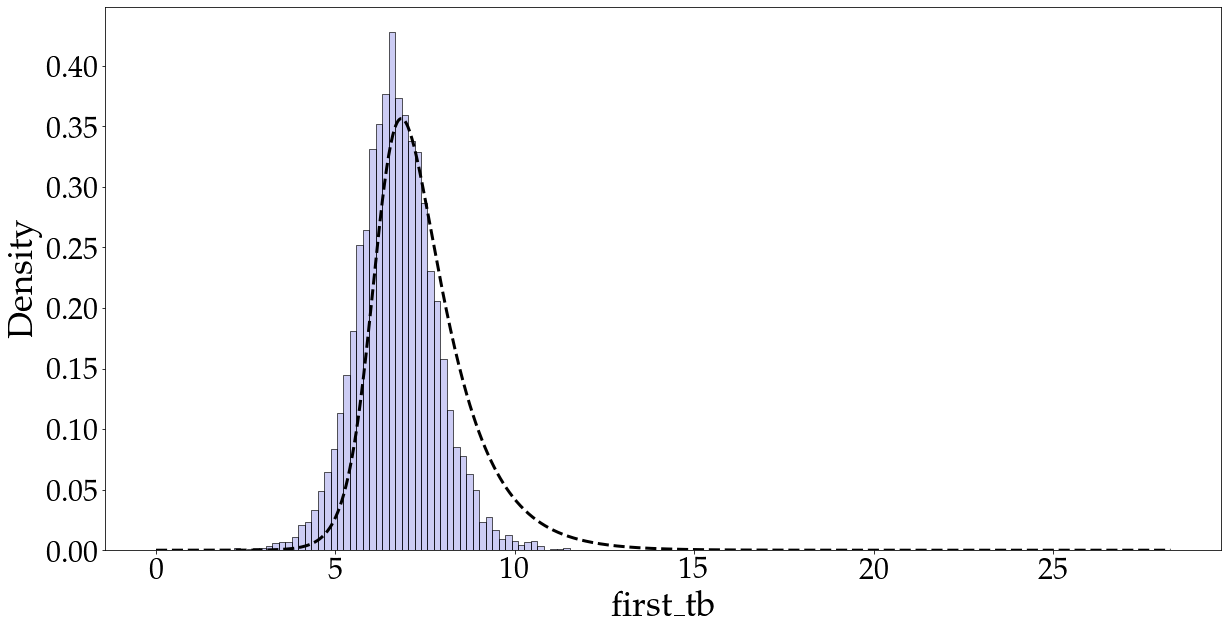

In [ ]:
fig,ax =plt.subplots(figsize=(20,10))
R0 = 3.5
mu = mu_s[2]
xi = xi_s[0]

qdata = filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')
ax.plot(ts_det,y_func(ts_det),color='black',linestyle='--')

sns.histplot(qdata,x='first_tb',ax=ax,stat='density',bins=first_t_bins,alpha=.2,color=color_mus[mu])

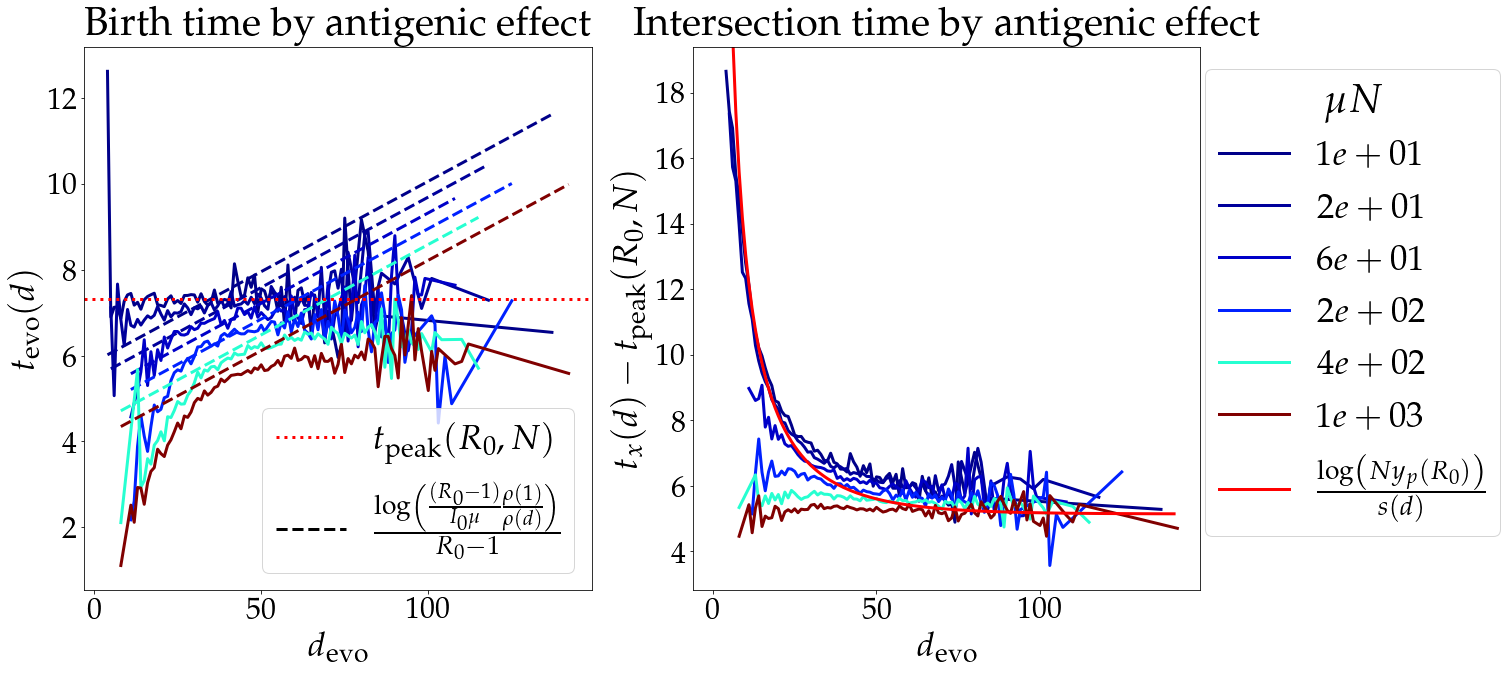

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
for mu in mu_s:
    qdata = filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')
    ds_hist=  np.array(sorted(qdata['first_d'].unique()))
    avg_tb = qdata.groupby('first_d')['first_tb'].mean()
    avg_tx = qdata.groupby('first_d')['t_x-t_peak'].mean()
    ax[0].plot(ds_hist,avg_tb,color=color_mus[mu])
    ax[1].plot(ds_hist,avg_tx,color=color_mus[mu],label = fr'${np.round(mu*N):.0e}$')

    expected_t_first = np.log((R0-1)/(I0*mu)* funcs.rho_d(1,p_alpha)/funcs.rho_d(ds_hist,p_alpha))/(R0-1)
    ax[0].plot(ds_hist, expected_t_first,color=color_mus[mu],linestyle='--') 

ylim = ax[1].get_ylim()
ax[1].plot(ds,np.log(N*funcs.y_peak(R0))/funcs.s_d_infinity(R0,ds,xi,0),color='red', label =r'$\frac{\log \left( N  y_p(R_0)\right)}{s(d)}$')
ax[1].set_ylim(ylim)

ax[0].axhline(funcs.t_peaks(R0,N),color='red',linestyle=':', label = r'$t_\mathrm{peak}(R_0,N)$')
handles0, labels0 = ax[0].get_legend_handles_labels()
handles0 +=[ Line2D([0], [0], color='black', linestyle='--')]
labels0 += [ r'$\frac{\log \left( \frac{(R_0-1)}{I_0 \mu} \frac{\rho(1)}{\rho(d)}\right)}{R_0-1}$']
ax[0].legend(handles0,labels0,loc='lower right',title_fontsize=40)

ax[1].legend(title=r'$\mu N$',loc=(1.01,.1),title_fontsize=40)

ax[0].set_title('Birth time by antigenic effect')
ax[1].set_title('Intersection time by antigenic effect')

ax[0].set_xlabel(r'$d_{\mathrm{evo}}$')
ax[1].set_xlabel(r'$d_{\mathrm{evo}}$')

ax[0].set_ylabel(r'$t_\mathrm{evo}(d)$')
ax[1].set_ylabel(r'$t_x(d)-t_\mathrm{peak}(R_0,N)$')

plt.savefig(results_folder+'/'+f'birth_time_by_d_R0_{R0:.1f}_xi_{xi:.0f}.jpg',bbox_inches='tight')

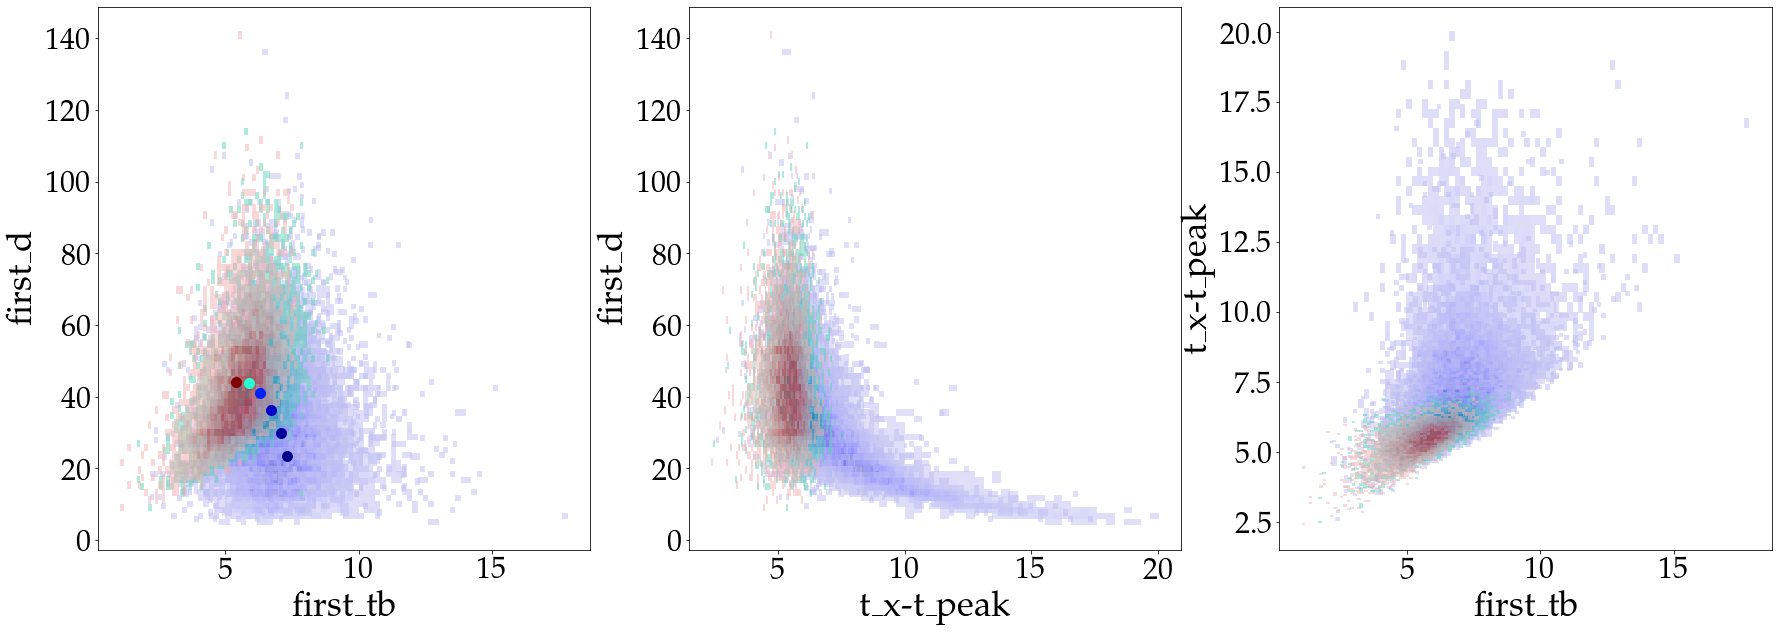

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
for mu in mu_s:
    qdata = filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')
    sns.histplot(qdata, x= 'first_tb', y= 'first_d', stat='density', alpha=.5, color=color_mus[mu],ax= ax[0])

    avg_first_tb = qdata['first_tb'].mean()
    avg_first_d = qdata['first_d'].mean()
    ax[0].plot(avg_first_tb,avg_first_d,'o',color=color_mus[mu],label=fr'$\mu N={np.round(mu*N):.0e}$', ms=10)
    sns.histplot(qdata, x= 't_x-t_peak', y= 'first_d', stat='density', alpha=.5, color=color_mus[mu],ax= ax[1])
    sns.histplot(qdata, y= 't_x-t_peak', x= 'first_tb', stat='density', alpha=.5, color=color_mus[mu],ax= ax[2])

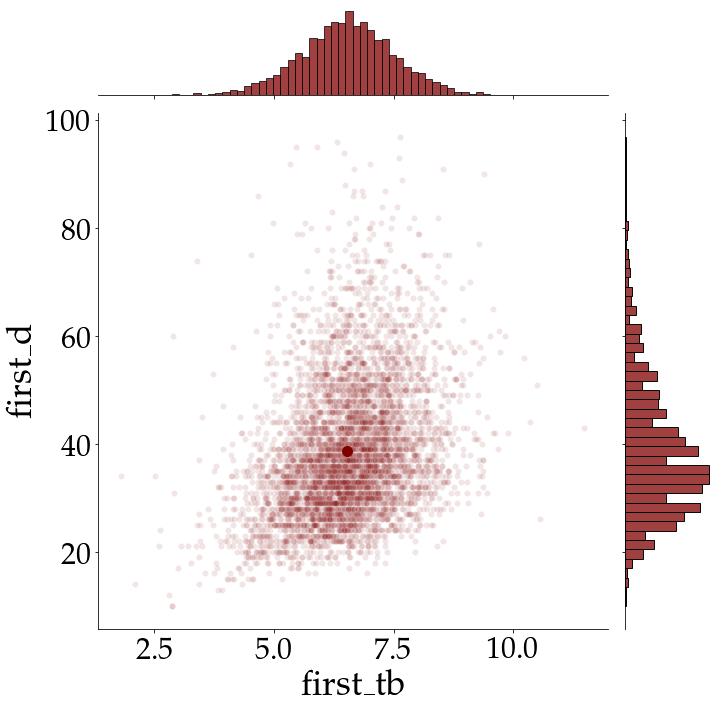

In [ ]:
g = sns.jointplot(qdata, x= 'first_tb', y= 'first_d', alpha=.1, color=color_mus[mu],height=10)
g.ax_joint.plot(avg_first_tb,avg_first_d,'o',color=color_mus[mu],label=fr'$\mu N={np.round(mu*N):.0e}$', ms=10)

In [ ]:
import scipy.stats as spst

In [ ]:
xi_styles = {xi_s[0]:':',xi_s[1]:'--'}

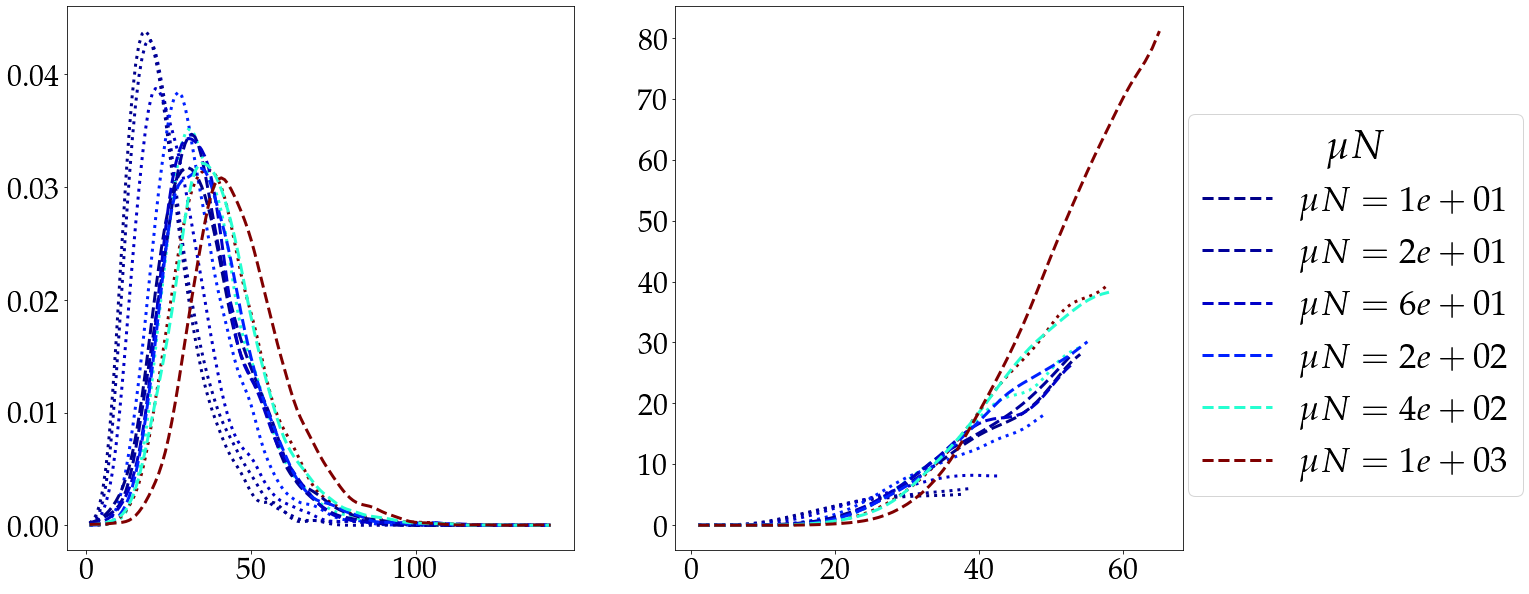

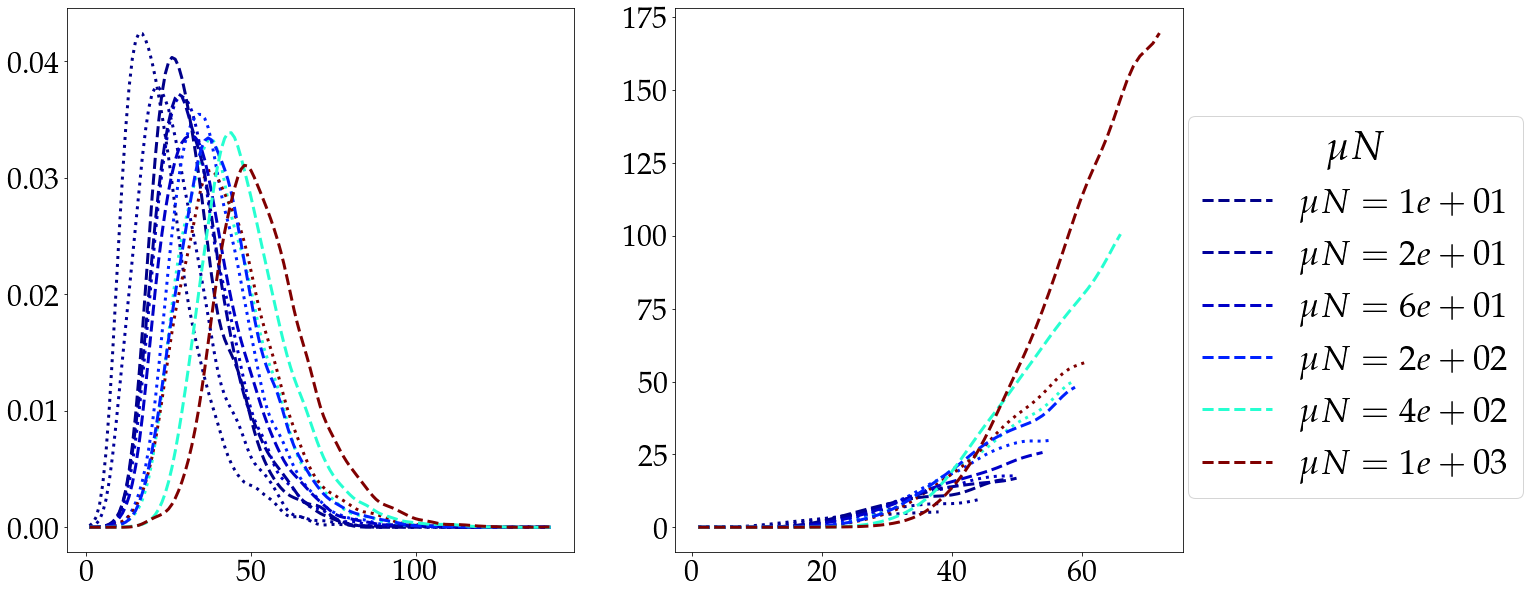

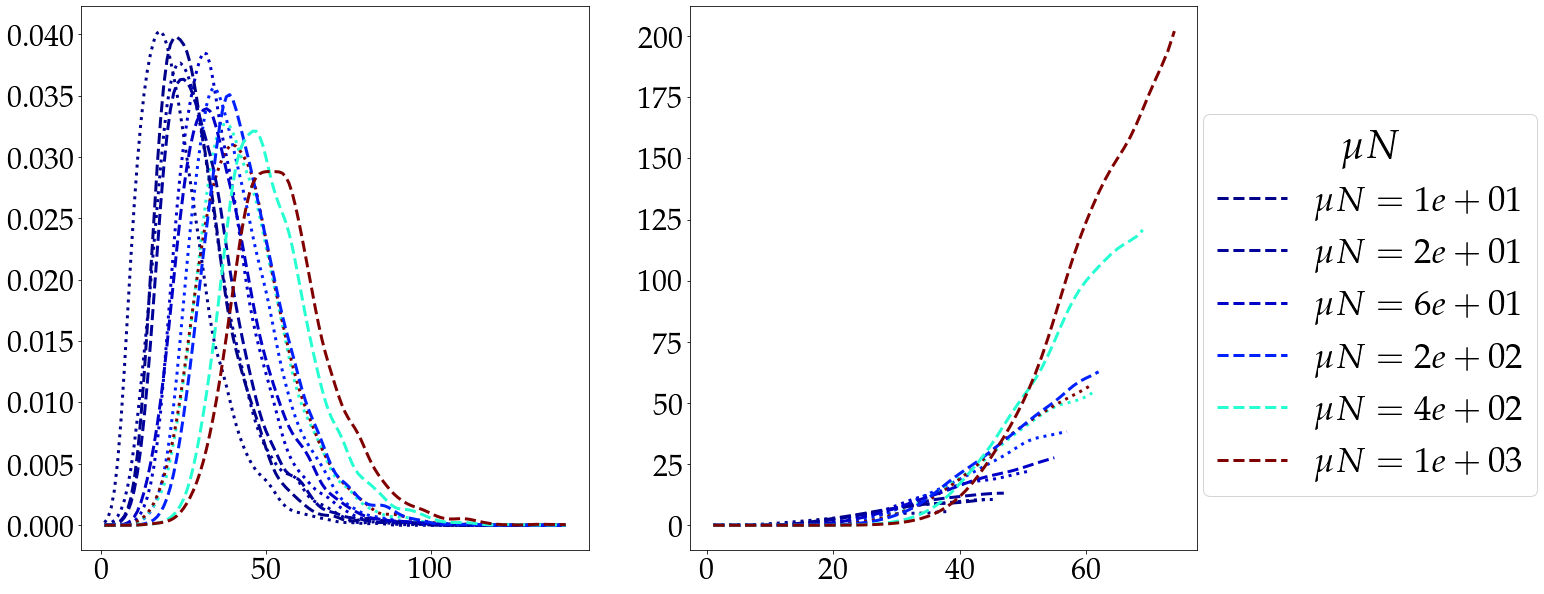

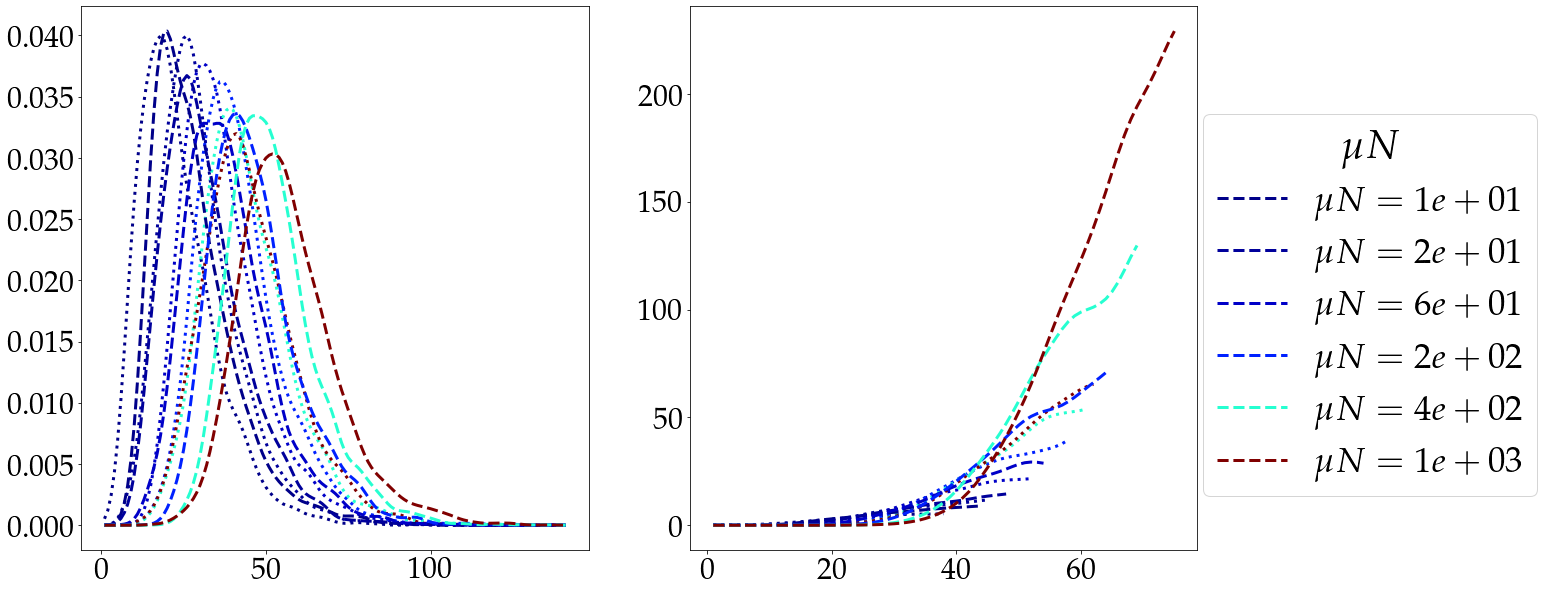

In [ ]:
R0, xi = 3.5, 20
for R0 in R0s:
    fig, ax = plt.subplots(1,2,figsize=(20,10) )
    for xi in xi_s:
        for mu in mu_s:
            qdata = filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')

            # get kde of first_d
            kde = spst.gaussian_kde(qdata['first_d'])
            # the x values for the kde are the ds
            x_kde = ds
            # the y values are the kde evaluated at the ds
            y_kde = kde(x_kde)
            # plot the kde
            y_cum = np.cumsum(y_kde)
            ax[0].plot(x_kde,y_kde, color = color_mus[mu],linestyle=xi_styles[xi])
            # sns.histplot(qdata, x= 'first_d', stat='density', alpha=.5, color=color_mus[mu], bins = ds,ax = ax[0])
            
            post = y_kde/funcs.rho_d(x_kde,p_alpha)
            ax[1].plot(ds[y_cum<.9],post[y_cum<.9],color=color_mus[mu], label=fr'$\mu N={np.round(mu*N):.0e}$',linestyle=xi_styles[xi])
    #legend in ax[1] only with non repeating labels
    handles, labels = ax[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),title=r'$\mu N$',loc=(1.01,.1),title_fontsize=40)
    # ax[1].legend(title=r'$\mu N$',loc=(1.01,.1),title_fontsize=40)
    
    # ax[1].set_yscale('log')

In [ ]:
T = funcs.T_ext_deterministic(R0,0,N)
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,0)).T

In [ ]:
#import interp1d
from scipy.interpolate import interp1d

In [ ]:
y_func = interp1d(ts_det,y)

In [ ]:
N = datadf['N'].unique()[0]

In [ ]:
#function that realizes the formula : \chi_\mu = \frac{1}{N\left( 1- x_{0} \mathrm{e}^{ -\frac{R_{0}}{N\mu\tilde{\rho(d)}} }  - \frac{1}{\tilde{\rho}(d)} \right)}
def chi_mu(d,R0, p_alpha,mu,N,I0):
    rho_tilde = funcs.rho_d(d,p_alpha)#/funcs.rho_d(1,p_alpha)
    x0 = 1-I0/N
    return 1/(N*(1- x0*np.exp(-R0/(N*mu*rho_tilde))-1/(N*mu*rho_tilde)))

(1e-16, 0.01)

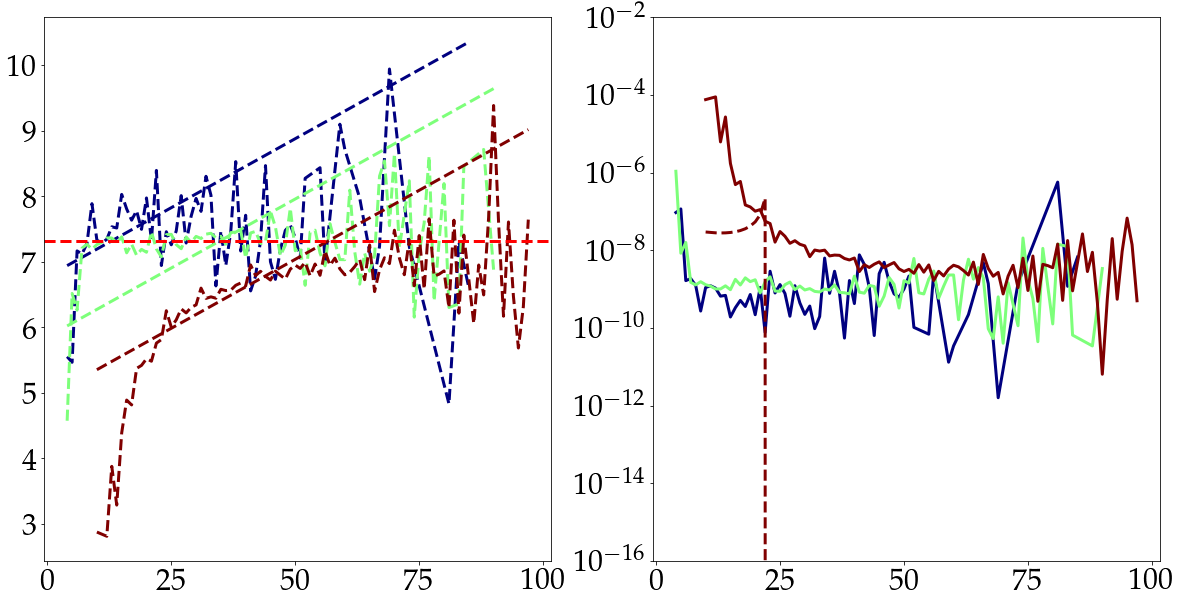

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
for mu in mu_s:
    qdata = filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')
    ds = np.arange(1,qdata['first_d'].max())
    # sns.histplot(qdata,x='first_tb',ax=ax[1],stat='density',bins=first_t_bins,alpha=.5,color=color_mus[mu])
    ds_hist= np.array(sorted(qdata['first_d'].unique()))
    #get the average tb for each d
    avg_tb= qdata.groupby('first_d')['first_tb'].mean()
    x_first_theo = mu/(R0-1) * funcs.rho_d(ds_hist,p_alpha)/funcs.rho_d(1,p_alpha)
    
    expected_t_first = np.log((R0-1)/(I0*mu)* funcs.rho_d(1,p_alpha)/funcs.rho_d(ds_hist,p_alpha))/(R0-1)
    ax[0].plot(ds_hist, expected_t_first,color=color_mus[mu],linestyle='--') 
    ax[0].plot(ds_hist, avg_tb,color=color_mus[mu],linestyle='--')

    # ax[1].plot(ds_hist, x_first_theo,color=color_mus[mu],linestyle='--')
    ax[1].plot(ds_hist, chi_mu(ds_hist,R0, p_alpha,mu,N,10),color=color_mus[mu],linestyle='--')
    # ax[1].plot(ds_hist, 1/(N*y_func(avg_tb)),color=color_mus[mu],linestyle='--')
    x_tb=  1/(I0*np.exp(avg_tb*(R0-1)))


    ax[1].plot(ds_hist,x_tb,color = color_mus[mu],label=fr'$\mu N={np.round(mu*N):.0e}$')
ax[0].axhline(funcs.t_peaks(R0,N),color='red',linestyle='--')
ax[1].set_yscale('log')
ax[1].set_ylim(1/(N**2),1e-2)

In [ ]:
N

10000

In [ ]:
def get_p_evo_from_df(R0,mu,xi, datadf):
    dpdf = datadf.query(f'infection_rate =={R0} & mutation_rate=={mu} & xi=={xi}')
    return 1-len(dpdf[datadf.isin([np.inf, -np.inf]).any(axis=1)])/len(dpdf)

if not os.path.exists(results_name+'p_evo_df.feather'):
    p_evo_df = pd.DataFrame.from_dict({i:(mu,xi,r ,get_p_evo_from_df(r,mu,xi,datadf)) for i,(mu,xi,r) in enumerate(funcs.product(mu_s,xi_s,R0s))},orient='index', columns=['mu','xi','R0','p_evo'])
    p_evo_df.to_feather(results_name+'p_evo_df.feather')
else:
    p_evo_df = pd.read_feather(results_name+'p_evo_df.feather')
    

<AxesSubplot:xlabel='R0', ylabel='p_evo'>

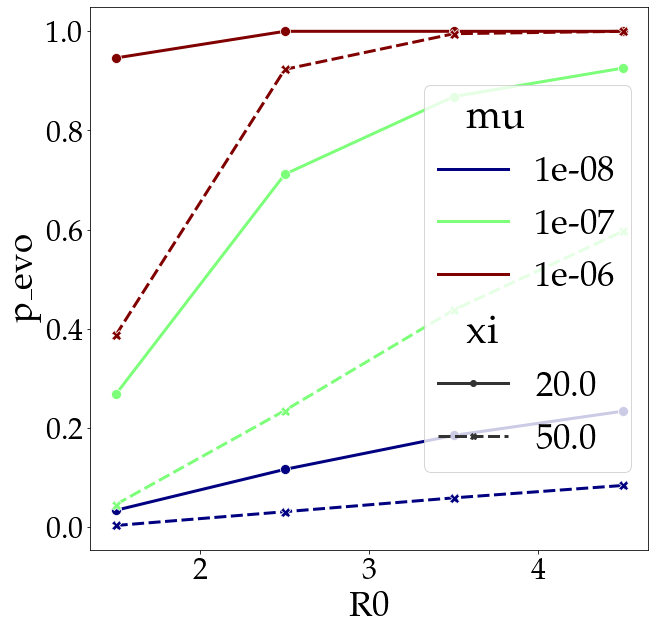

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=p_evo_df,x='R0',y='p_evo',hue='mu',style='xi',markers=True,palette=color_mus, ms =10  )

In [ ]:
filtered_df.query(f'infection_rate == {R0} and muN == {np.round(mu*N)} and xi == {xi}')

RunId  iteration   Step         N  infection_rate  kappa  p_alpha  \
206      106          4  32776  10000000             2.5      0      0.1   
221      178          7  32776  10000000             2.5      0      0.1   
238       34          1  32776  10000000             2.5      0      0.1   
239       10          0  32776  10000000             2.5      0      0.1   
259       82          3  32776  10000000             2.5      0      0.1   
...      ...        ...    ...       ...             ...    ...      ...   
11917  11938        497  32776  10000000             2.5      0      0.1   
11932  11914        496  32776  10000000             2.5      0      0.1   
11955  11962        498  32776  10000000             2.5      0      0.1   
11962  11986        499  32776  10000000             2.5      0      0.1   
11976  11890        495  32776  10000000             2.5      0      0.1   

       mutation_rate    xi  recovery_rate  initial_infected    dt  \
206          0.00001  20.0              1                10  None   
221          0.00001  20.0              1                10  None   
238          0.00001  20.0              1                10  None   
239          0.00001  20.0              1                10  None   
259          0.00001  20.0              1                10  None   
...              ...   ...            ...               ...   ...   
11917        0.00001  20.0              1                10  None   
11932        0.00001  20.0              1                10  None   
11955        0.00001  20.0              1                10  None   
11962        0.00001  20.0              1                10  None   
11976        0.00001  20.0              1                10  None   

       collect_freqs  first_tb  first_d     t_x    muN  first_d_over_xi  \
206            False     9.619     24.0  19.647  100.0             1.20   
221            False     7.752     31.0  17.383  100.0             1.55   
238            False     7.435     42.0  17.154  100.0             2.10   
239            False     7.435     42.0  17.154  100.0             2.10   
259            False     9.427     30.0  17.671  100.0             1.50   
...              ...       ...      ...     ...    ...              ...   
11917          False    10.472     31.0  18.462  100.0             1.55   
11932          False     8.509     50.0  16.645  100.0             2.50   
11955          False     9.604     27.0  18.852  100.0             1.35   
11962          False     9.466     42.0  18.291  100.0             2.10   
11976          False     5.603     60.0  15.431  100.0             3.00   

       t_x-t_peak  
206      9.300434  
221      7.036434  
238      6.807434  
239      6.807434  
259      7.324434  
...           ...  
11917    8.115434  
11932    6.298434  
11955    8.505434  
11962    7.944434  
11976    5.084434  

[500 rows x 19 columns]